# NaiveB MemoryB

# Setup imports

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# external dependencies
import os
import sys
import gc
import functools
notebook_path = os.path.abspath('.')
root_path = os.path.abspath(os.path.join(notebook_path, '..'))
sys.path.insert(0, root_path)
# import custom modules
import schidden
from schidden import utils, files, vis

# basic imports
import json
import pprint
import pickle
import logging
import math
from tqdm.auto import tqdm, trange

# scientific python
import matplotlib.pylab as plt
import seaborn as sns
import numpy as np
import scipy as sp
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.cluster import KMeans
import sklearn.metrics
from scipy.stats import describe as describe_stats
RAND_SEED = 28
np.random.seed(RAND_SEED)

# Scanpy modules
import scanpy as sc
import anndata



logger = logging.getLogger()
#utils.matplotlib_settings()
utils.print_module_versions([sc, anndata, schidden])
vis.matplotlib_settings()
import warnings
warnings.filterwarnings("ignore")

scanpy              : 1.9.3
anndata             : 0.8.0
schidden            : beta_25.03.23


## Load the data

In [3]:
EXP_NUM = 49
PUCK_NUMBER = f'naiveB_1900_memoryB_{EXP_NUM:d}'
# '49', '100', '154', '211', '271', '335', '403', '475', '552', '633', '721', '814', '915', '1023', '1140', '1267', '1404', '1555'

at_data_dir = functools.partial(os.path.join, root_path, files.DATA_DIR, PUCK_NUMBER)
at_results_dir = functools.partial(os.path.join, root_path, files.RESULT_DIR, PUCK_NUMBER)


print(f'Reading data from {at_data_dir()}')
print(f'Generating results at {at_results_dir()}')

np_data = files.load_npz(at_data_dir('citeseq_rna_preprocessed_data.npz'))
adata = sc.read(at_data_dir('citeseq_rna_adata.h5ad'))

batch = pd.read_csv(at_data_dir('batch.csv'))['x'].values
perturbed = pd.read_csv(at_data_dir('celltype.csv'))['x'].values
adata.obs['batch'] = batch.astype('str')
adata.obs['perturbed'] = perturbed
log_normalized_expression_ng = adata.X
raw_counts_allgenes = pd.read_csv(at_data_dir('counts_allgenes.csv'))
adata.layers['lognorm'] = adata.X
adata.layers['counts'] = raw_counts_allgenes.values
adata

Reading data from /home/beangoben/github/LabelCorrection/raw_data/naiveB_1900_memoryB_49
Generating results at /home/beangoben/github/LabelCorrection/results/naiveB_1900_memoryB_49


AnnData object with n_obs × n_vars = 1949 × 17009
    obs: 'barcodes', 'n_genes', 'percent_mito', 'n_counts', 'leiden', 'batch', 'perturbed'
    var: 'gene_ids', 'mean', 'std'
    uns: 'leiden', 'neighbors', 'pca', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'lognorm', 'counts'
    obsp: 'connectivities', 'distances'

## Ablation study - examine the effect of the perturbation strength

In [8]:
W_m = 1
if W_m!=1:
    adata, adata_hybrid = schidden.datasets.make_adata_with_hybrid_perturbed_cells(adata,                                                                         W_m = W_m)
    adata_work = adata_hybrid.copy()
else:
    adata_work = adata.copy()

dataset_name = f'{PUCK_NUMBER} hybrid {W_m}' if W_m!=1 else f'{PUCK_NUMBER}'
os.makedirs(at_results_dir(), exist_ok=True)
os.makedirs(at_results_dir('pdf'), exist_ok=True)
os.makedirs(at_results_dir('svg'), exist_ok=True)
print(f'Generating results at {output_path}')

Generating results at /home/beangoben/github/LabelCorrection/results/naiveB_1900_memoryB_49


## HiDDEN Utility functions

## Choose optimal NUM_PCS

  0%|          | 0/59 [00:00<?, ?it/s]

Optimal number of PCs via max KS is 49 with a KS=0.175 (p=9.317e-14)


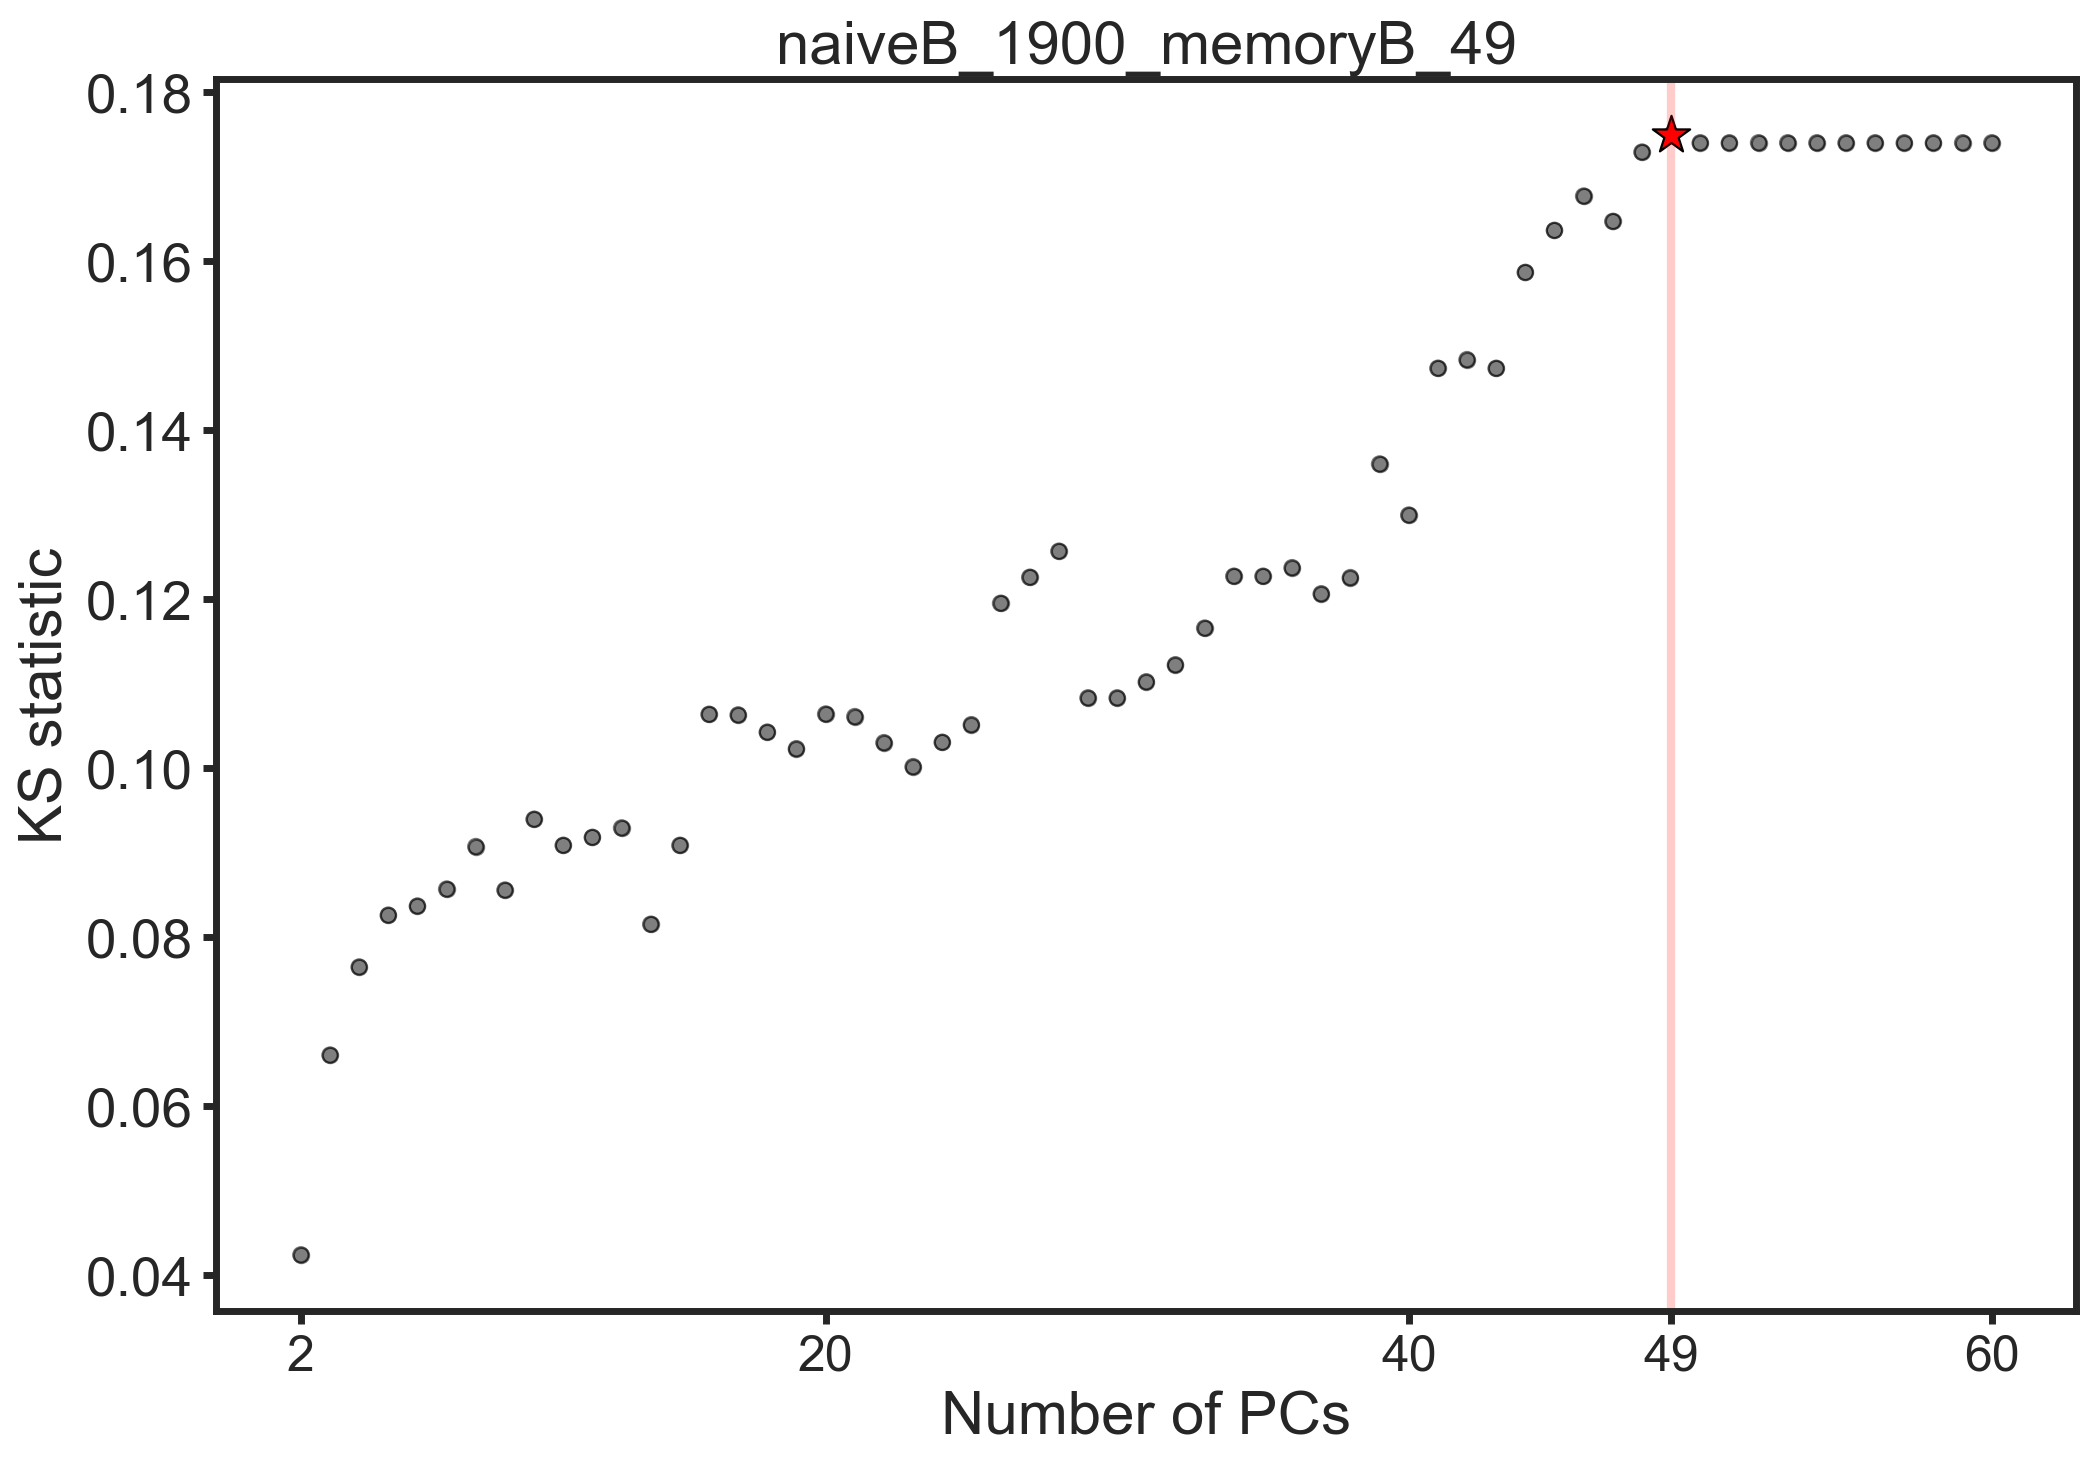

Optimal number of PCs via min KS pval is 49 with a KS=0.175 (p=9.317e-14)


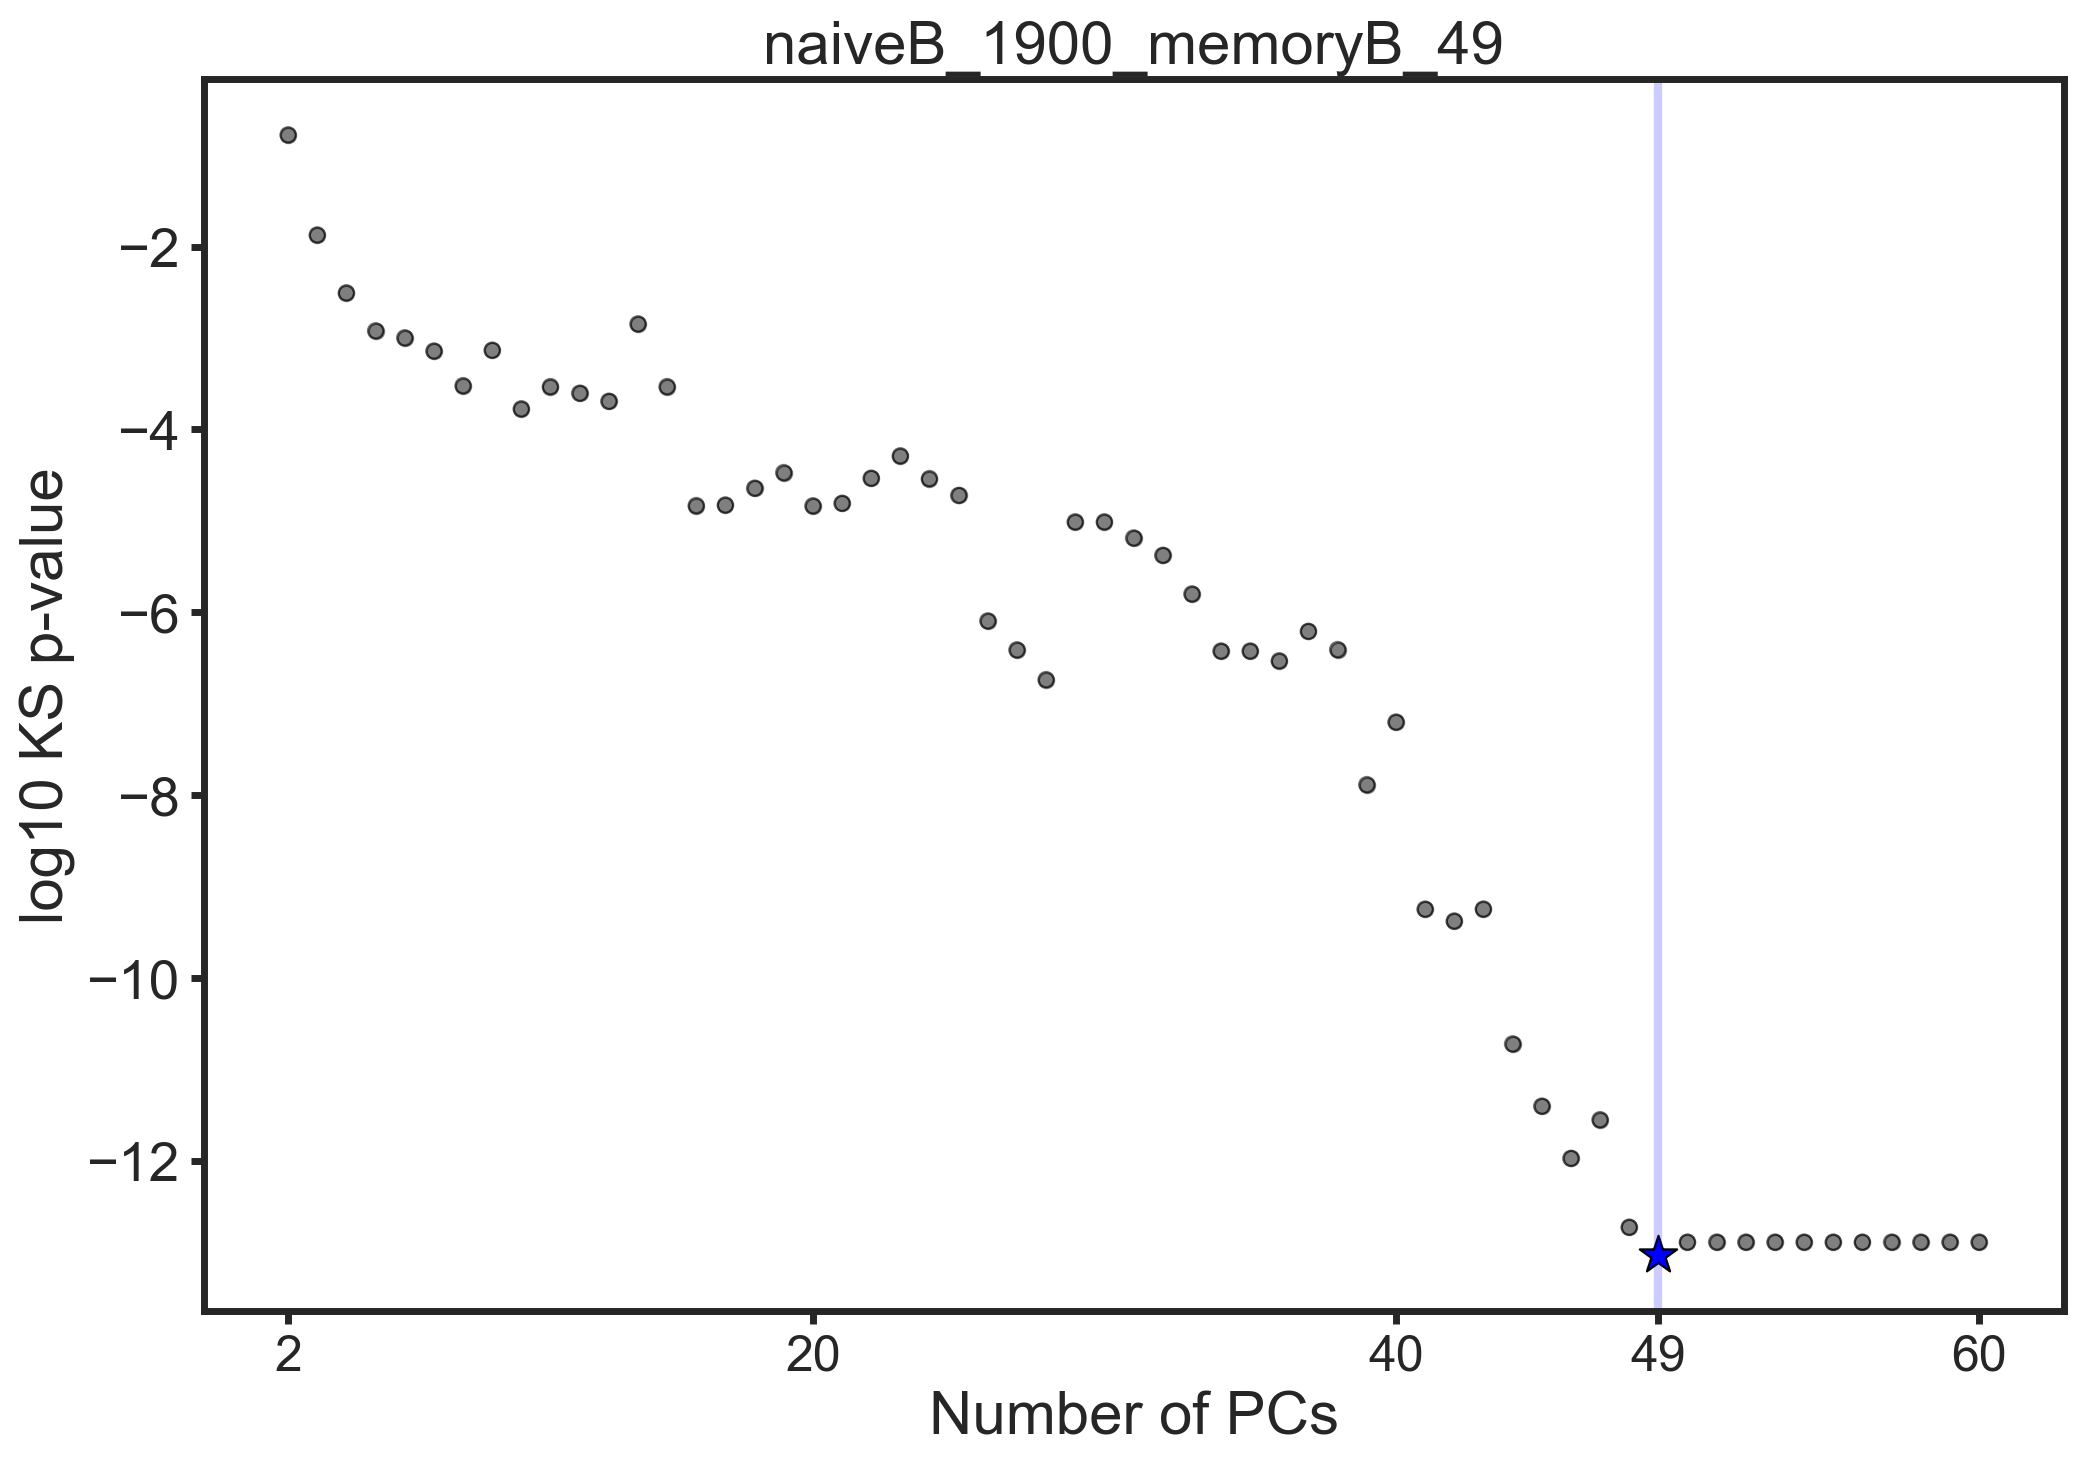

In [9]:
pc_nums, pc_ks, ks_pvals = schidden.models.determine_pcs_heuristic(adata_work)
max_index = np.argmax(pc_ks)
optimal_pc = pc_nums[max_index]
optimal_ks = pc_ks[max_index]
optimal_ks_pval = ks_pvals[max_index]

print(f"Optimal number of PCs via max KS is {optimal_pc} "
      f"with a KS={optimal_ks:.3f} (p={optimal_ks_pval:.3e})")

title_str = dataset_name
plt.scatter(pc_nums, pc_ks, s=30, c='k', alpha=0.5)
plt.scatter(pc_nums, pc_ks, s=30, c='none', alpha=0.5, edgecolors='k')
plt.axvline(x = optimal_pc, color = 'r', alpha=0.2)
plt.scatter(optimal_pc, 
            optimal_ks, 
            s=200, c='r', marker='*', edgecolors='k')
plt.xticks([2, 20, 40, 60] + [optimal_pc], fontsize=18)
plt.xlabel('Number of PCs')
plt.ylabel('KS statistic')
plt.title(title_str)
vis.save_fig_results(at_results_dir(f'ChoosingoptimalNUM_PCS_KS_{title_str}'))
plt.show()

min_index = np.argmin(ks_pvals)
optimal_pc = pc_nums[min_index]
optimal_ks = pc_ks[min_index]
optimal_ks_pval = ks_pvals[min_index]

print(f"Optimal number of PCs via min KS pval is {optimal_pc} "
      f"with a KS={optimal_ks:.3f} (p={optimal_ks_pval:.3e})")

plt.scatter(pc_nums, np.log10(ks_pvals), s=30, c='k', alpha=0.5)
plt.scatter(pc_nums, np.log10(ks_pvals), s=30, c='none', alpha=0.5, edgecolors='k')
plt.axvline(x = optimal_pc, color = 'b', alpha=0.2)
plt.scatter(optimal_pc, 
            np.log10(optimal_ks_pval), 
            s=200, c='b', marker='*', edgecolors='k')
plt.xticks([2, 20, 40, 60] + [optimal_pc], fontsize=18)
plt.xlabel('Number of PCs')
plt.ylabel('log10 KS p-value')
plt.title(title_str)
vis.save_fig_results(at_results_dir(f'ChoosingoptimalNUM_PCS_KSpval_{title_str}'))
plt.show()

## Run with a chosen value for NUM_PCS

In [11]:
optimal_NUM_PCS_dict = files.load_npz('../figures/ablation/optimal_NUM_PCS_KS_dict.npz')
NUM_PCS = int(optimal_NUM_PCS_dict[dataset_name])

In [16]:
title_str = f'{dataset_name} {NUM_PCS} PCs' 
adata_work.obs['batch'] = adata_work.obs['batch'].astype('int').values
p_hat, new_labels = schidden.models.pca_logistic_kmeans(adata_work, NUM_PCS)
adata_work.obs['new_labels'] = new_labels.values

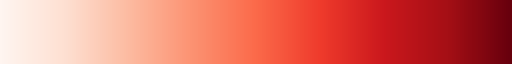

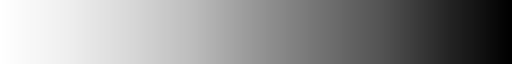

In [20]:
reds_palette = sns.color_palette('Reds', as_cmap=True)
display(reds_palette)
greys_palette = sns.color_palette('Greys', as_cmap=True)
greys_palette

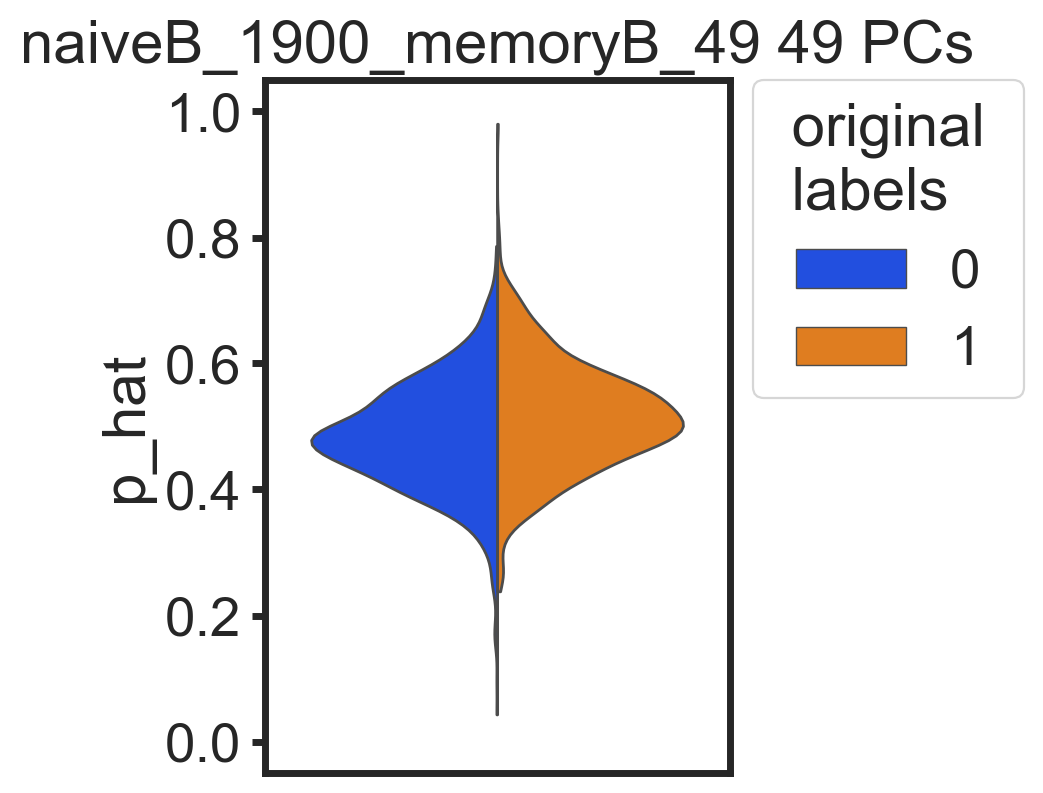

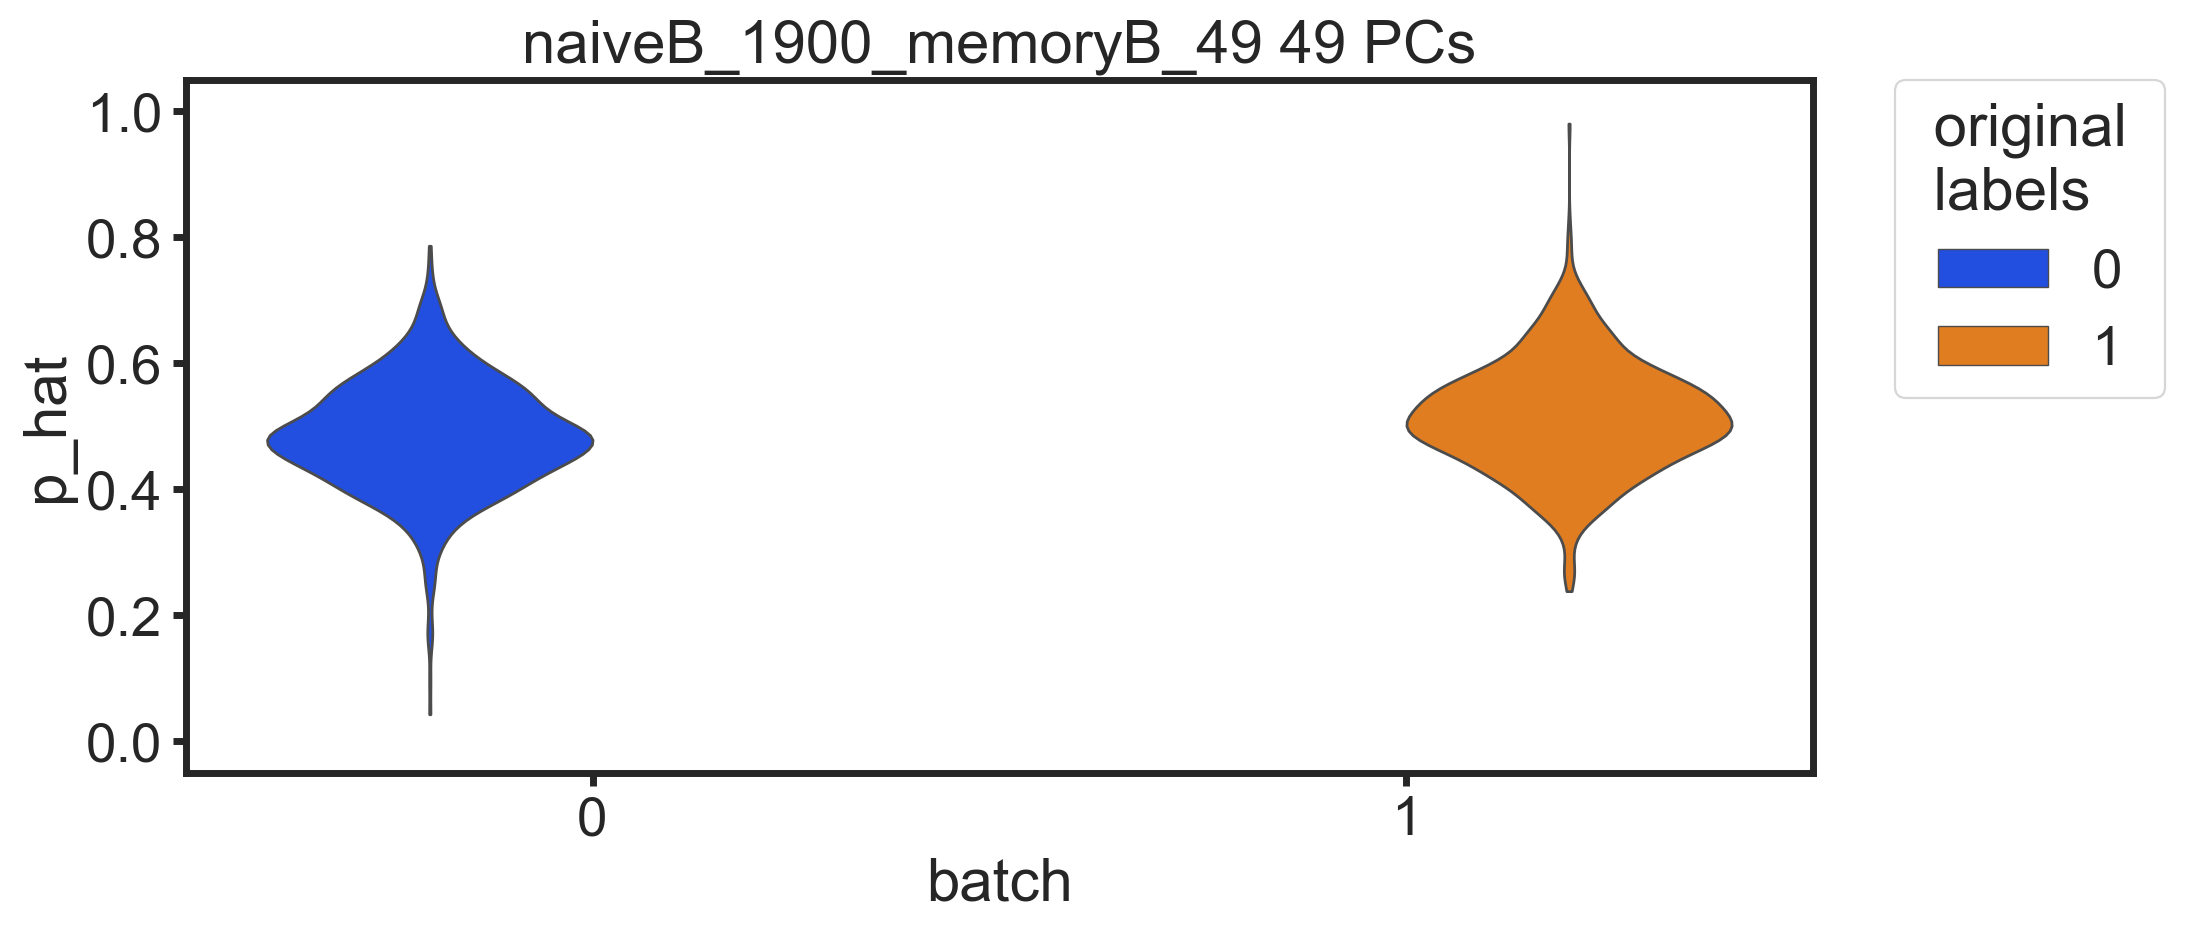

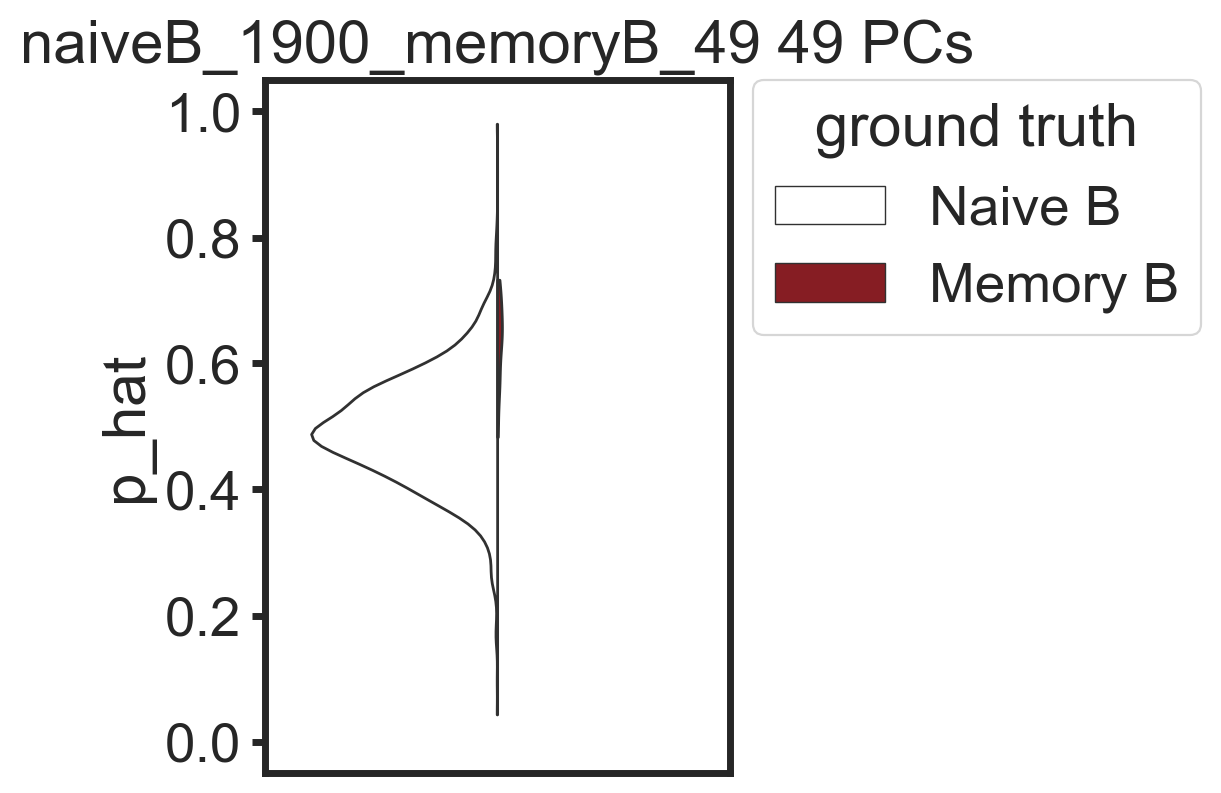

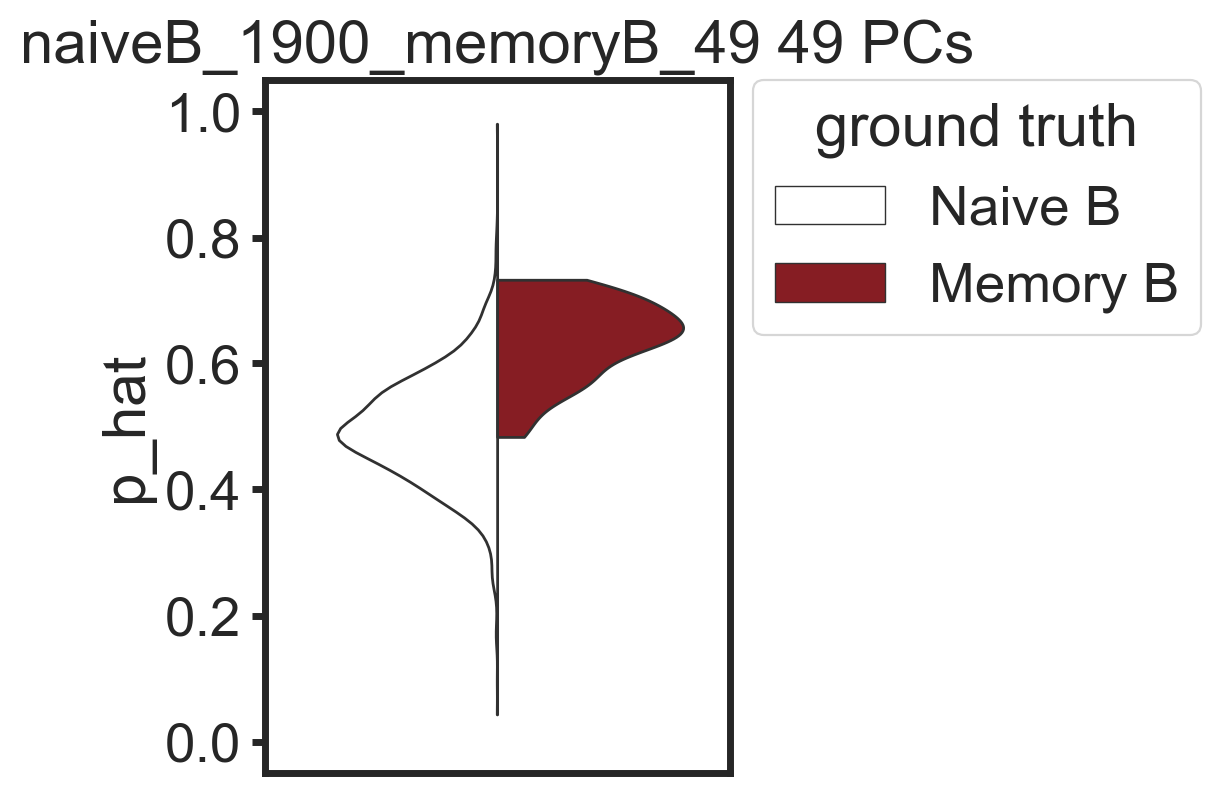

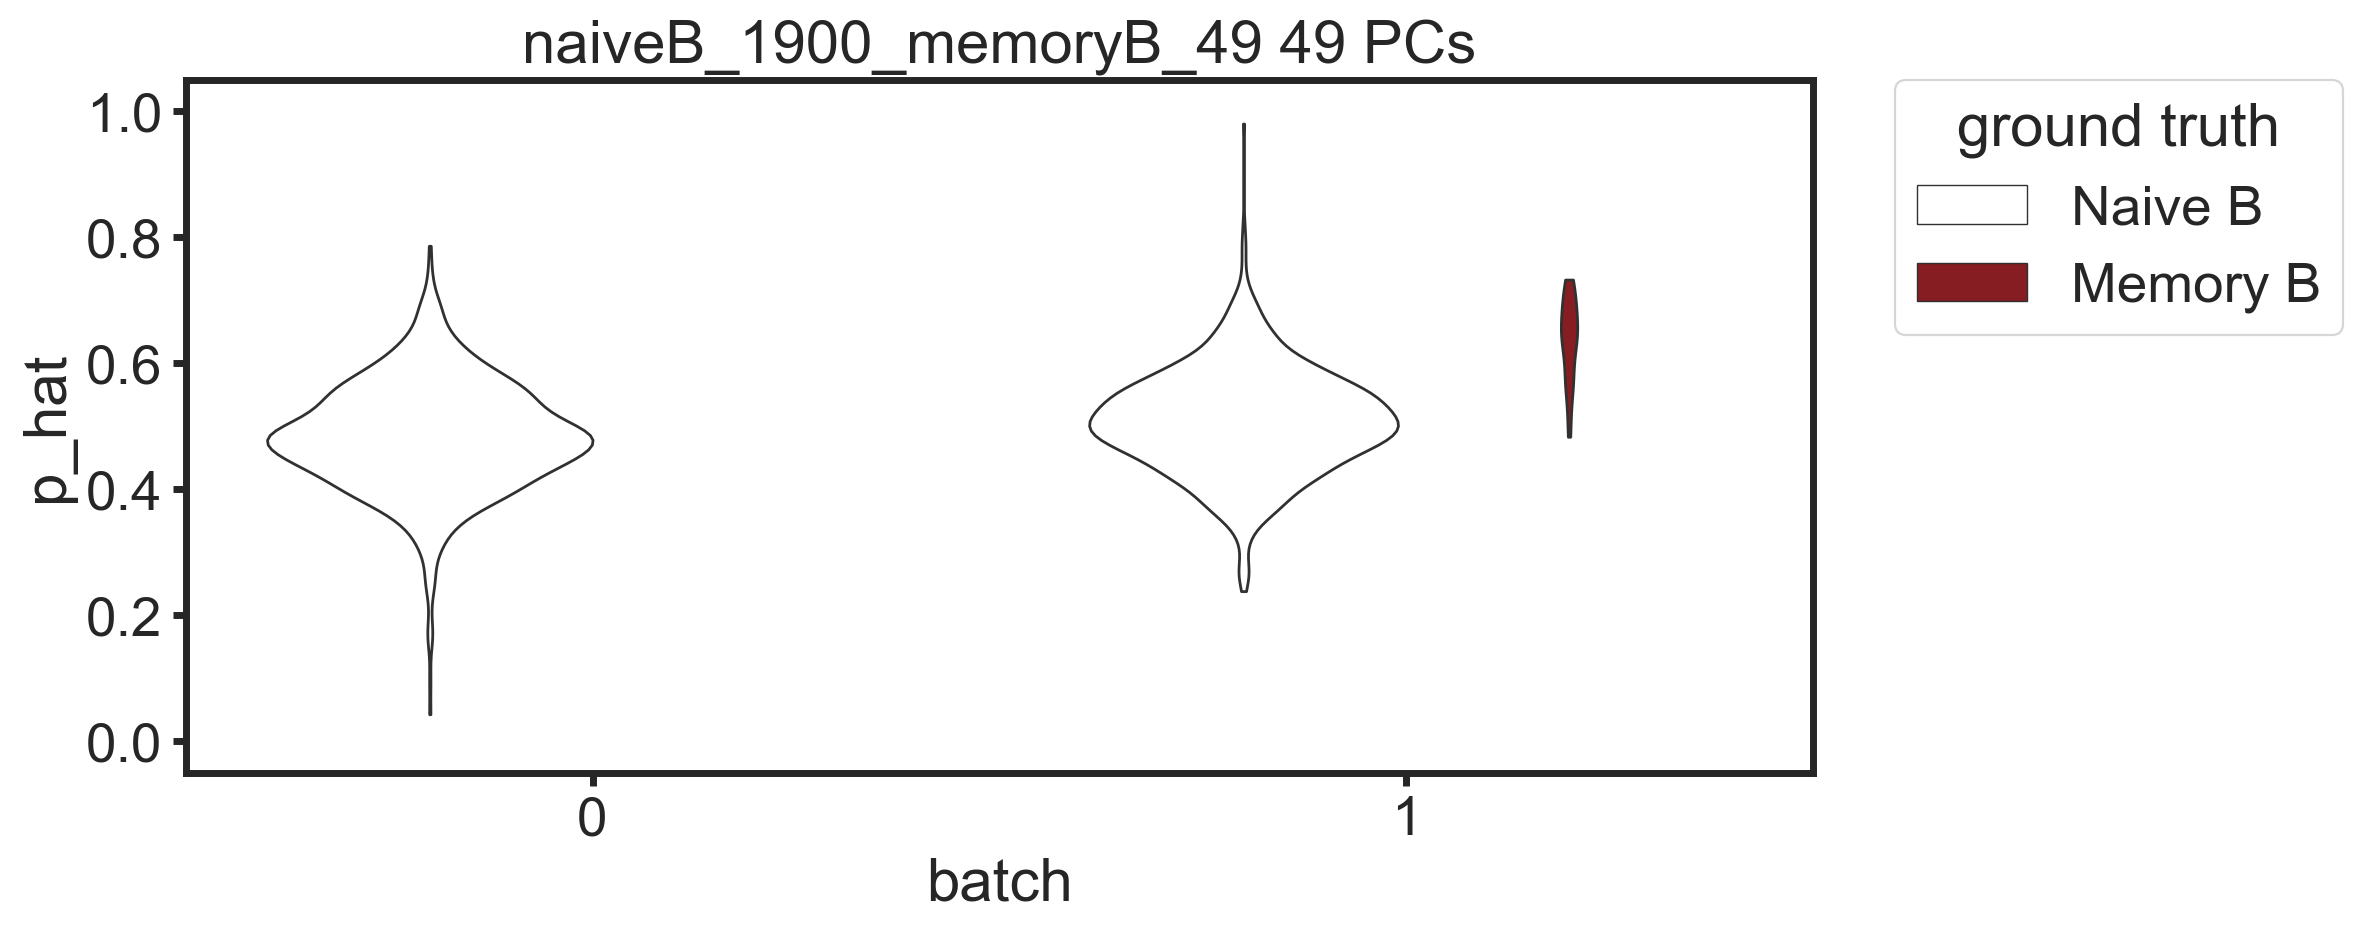

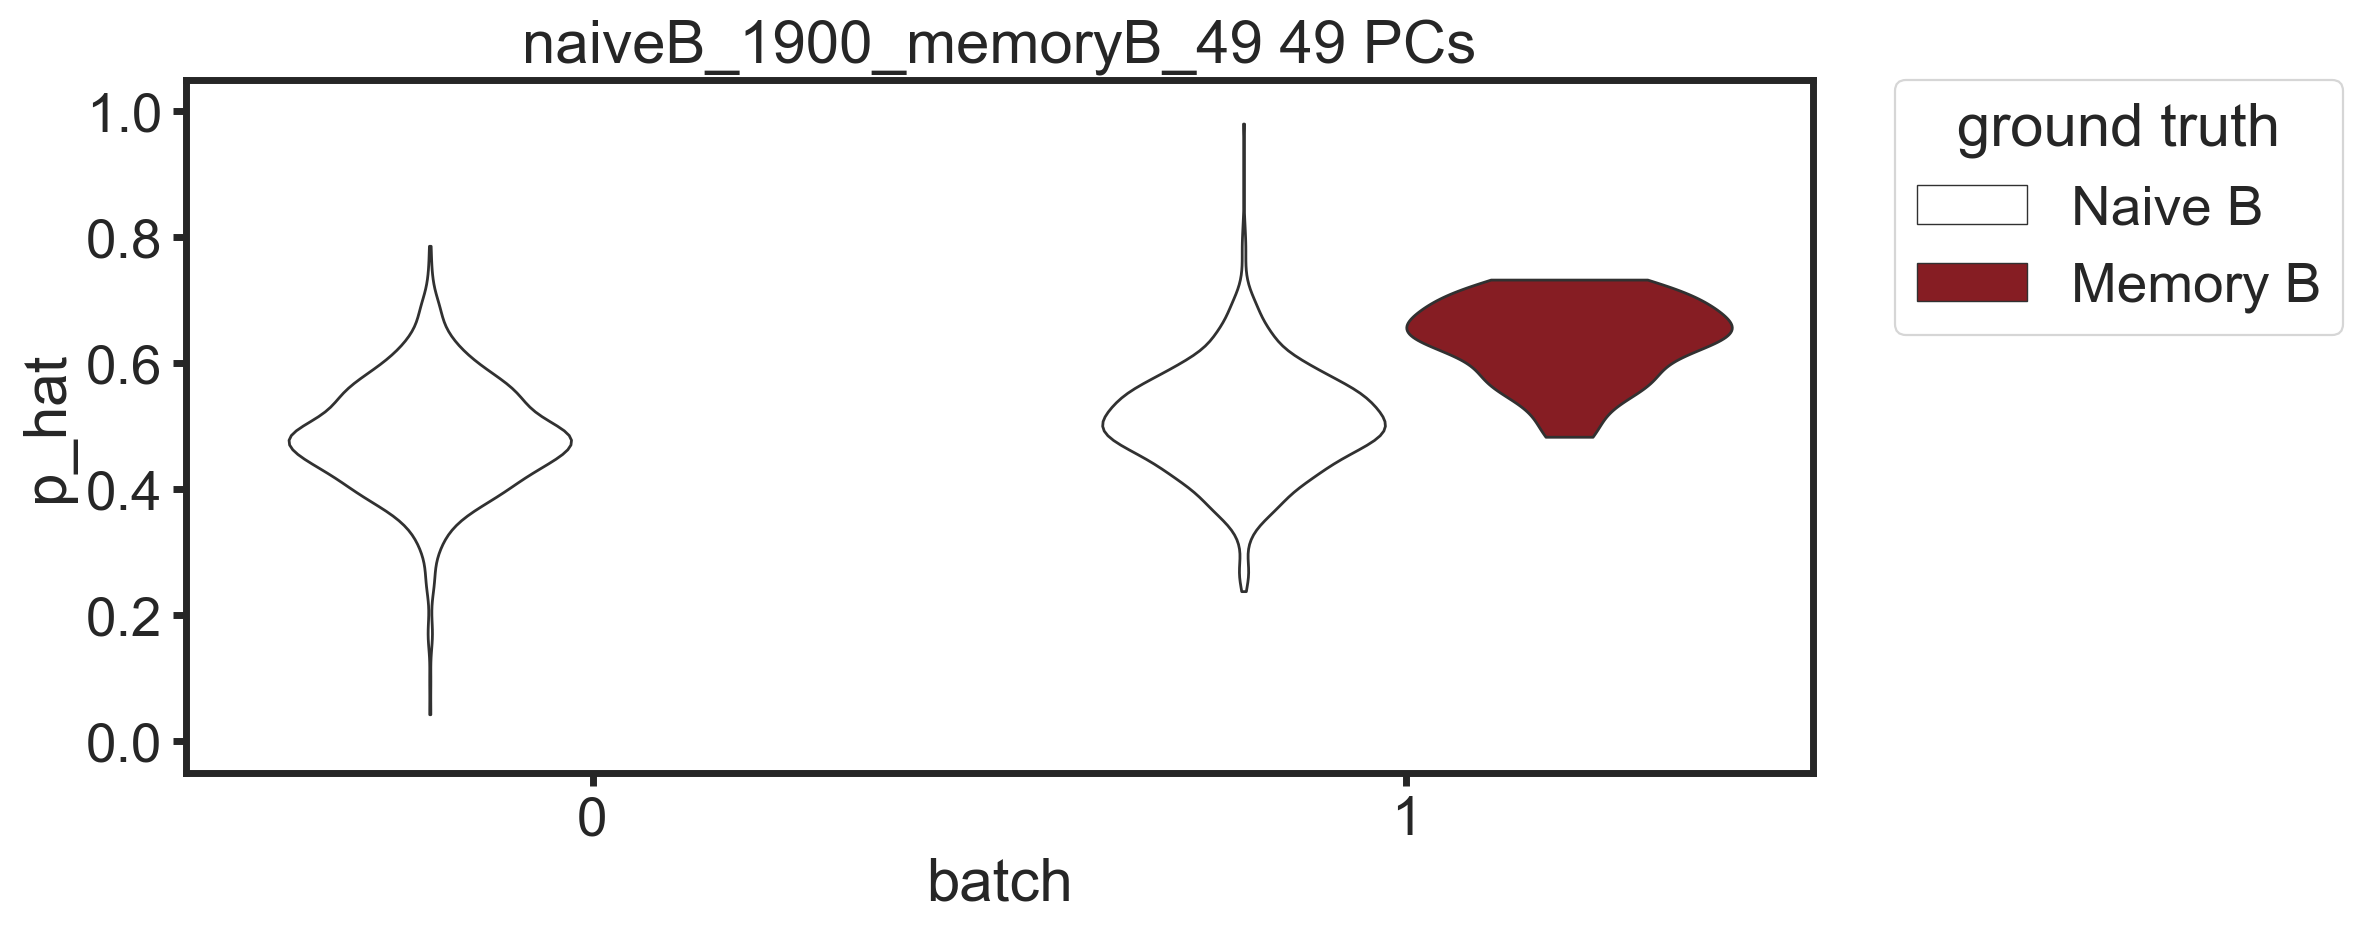

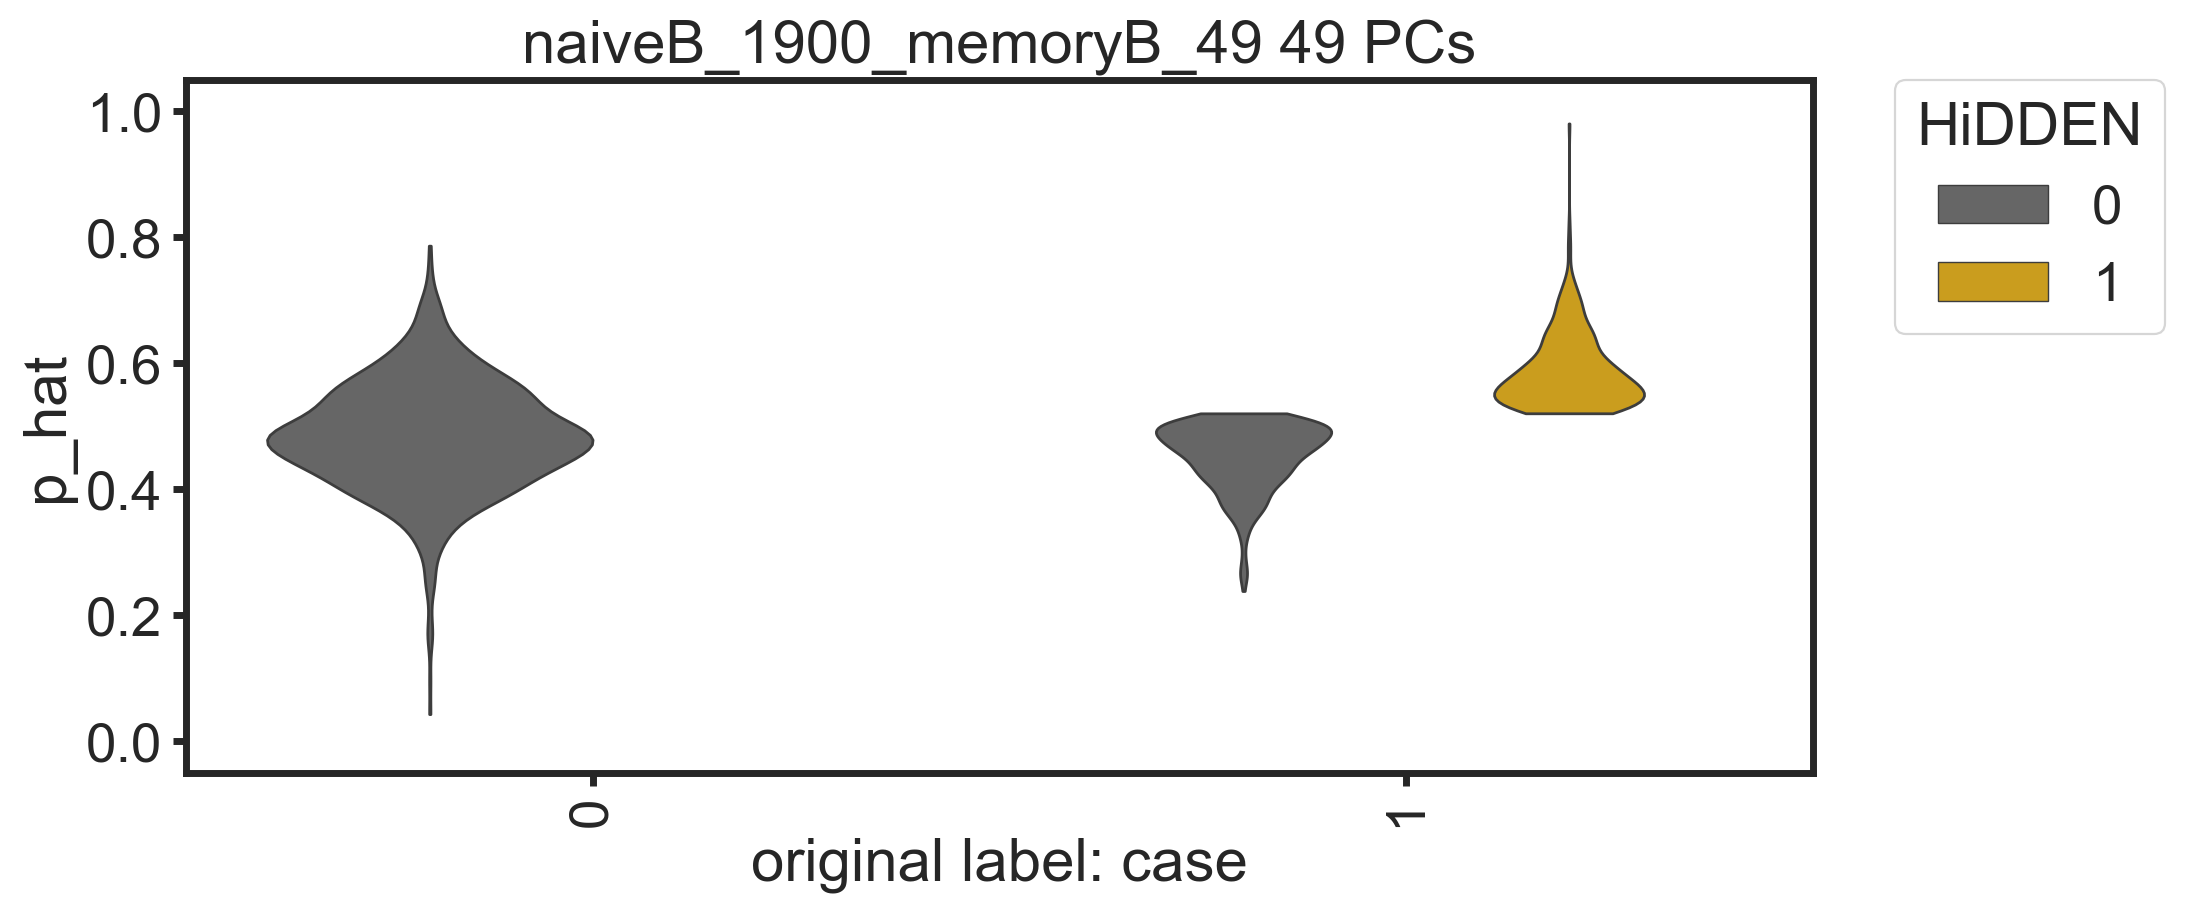

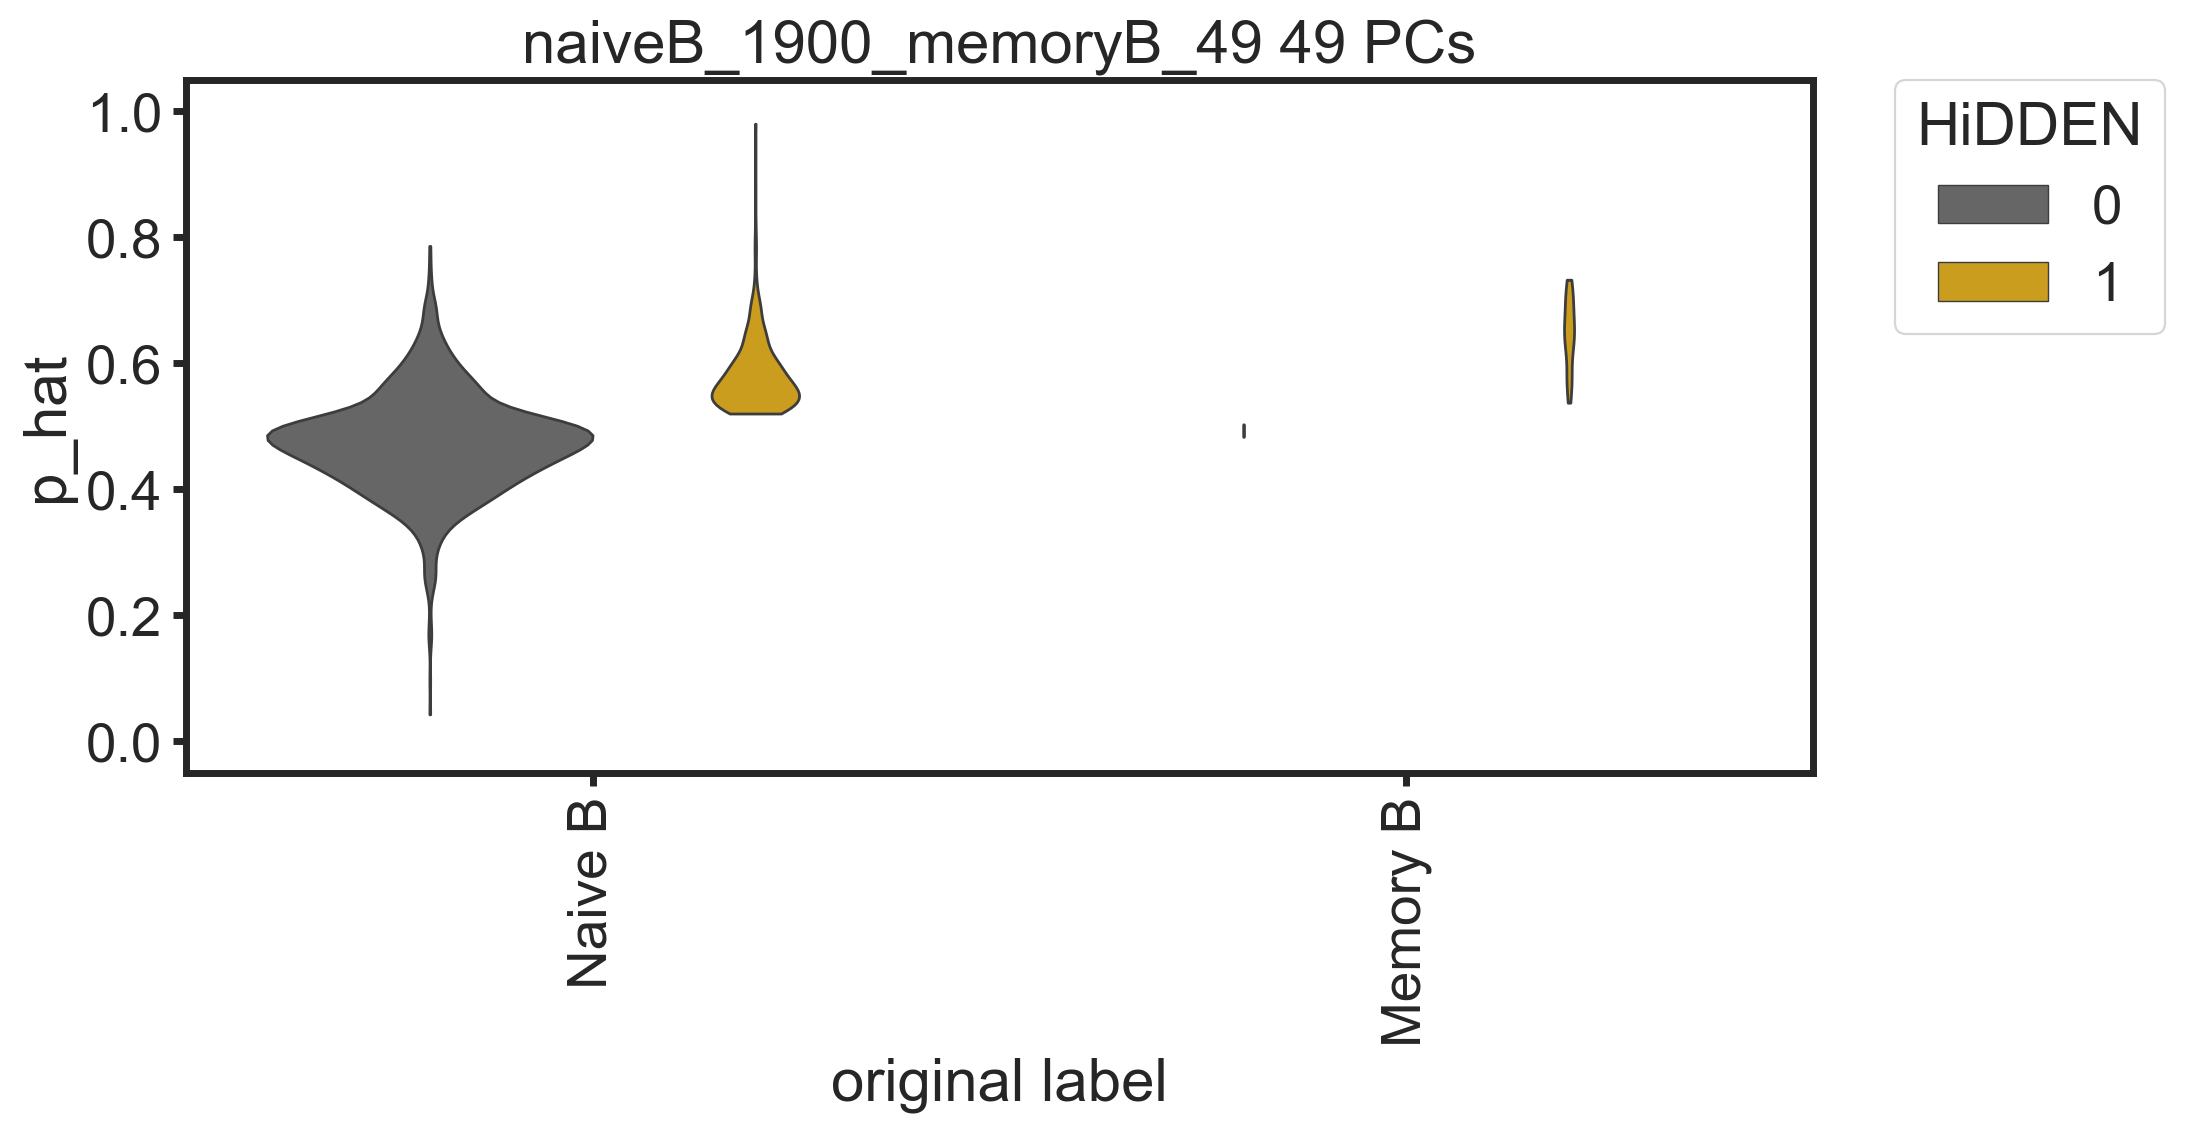

In [23]:

adata_work.obs['dataset'] = title_str

plt.figure(figsize=(3, 4.5))
plt.ylim(-0.05, 1.05)
sns.violinplot(data=adata_work.obs, x='dataset', y='p_hat', hue="batch", split=True, linewidth=1, scale='count', cut=0, inner=None, scale_hue=False) 
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0, title=' original \n labels')
plt.xticks([])
plt.xlabel("")
plt.title(title_str)
vis.save_fig_results(at_results_dir(f'split_violin_batch_scalecount_{title_str}'))
plt.show()

plt.figure(figsize=(10.5, 4.5))
plt.ylim(-0.05, 1.05)
sns.violinplot(data=adata_work.obs, x='batch', y='p_hat', hue="batch", split=False, linewidth=1, scale='count', cut=0, inner=None, scale_hue=False) 
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0, title=' original \n labels')
plt.title(title_str)
vis.save_fig_results(at_results_dir(f'violin_batch_scalecount_{title_str}'))
plt.show()

plt.figure(figsize=(3, 4.5))
plt.ylim(-0.05, 1.05)
sns.violinplot(data=adata_work.obs, x='dataset', y='p_hat', hue="perturbed", split=True, linewidth=1, scale='count', cut=0, scale_hue=False,
               hue_order=['Naive B', 'Memory B'], palette={'Naive B':'white', 'Memory B':reds_palette(W_m if W_m!=1 else 0.9)}, inner=None) 
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0, title='ground truth')
plt.xticks([])
plt.xlabel("")
plt.title(title_str)
vis.save_fig_results(at_results_dir(f'split_violin_perturbed_scalecount_{title_str}'))
plt.show()

plt.figure(figsize=(3, 4.5))
plt.ylim(-0.05, 1.05)
sns.violinplot(data=adata_work.obs, x='dataset', y='p_hat', hue="perturbed", split=True, linewidth=1, cut=0, scale_hue=False,
               hue_order=['Naive B', 'Memory B'], palette={'Naive B':'white', 'Memory B':reds_palette(W_m if W_m!=1 else 0.9)}, inner=None) 
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0, title='ground truth')
plt.xticks([])
plt.xlabel("")
plt.title(title_str)
vis.save_fig_results(at_results_dir(f'split_violin_perturbed_{title_str}'))
plt.show()

plt.figure(figsize=(10.5, 4.5))
plt.ylim(-0.05, 1.05)
sns.violinplot(data=adata_work.obs, x='batch', y='p_hat', hue="perturbed", split=False, linewidth=1, scale='count', cut=0, scale_hue=False,
               hue_order=['Naive B', 'Memory B'], palette={'Naive B':'white', 'Memory B':reds_palette(W_m if W_m!=1 else 0.9)}, inner=None) 
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0, title='ground truth')
plt.title(title_str)
vis.save_fig_results(at_results_dir(f'violin_perturbed_scalecount_{title_str}'))
plt.show()


plt.figure(figsize=(10.5, 4.5))
plt.ylim(-0.05, 1.05)
sns.violinplot(data=adata_work.obs, x='batch', y='p_hat', hue="perturbed", split=False, linewidth=1, cut=0, scale_hue=False,
               hue_order=['Naive B', 'Memory B'], palette={'Naive B':'white', 'Memory B':reds_palette(W_m if W_m!=1 else 0.9)}, inner=None) 
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0, title='ground truth')
plt.title(title_str)
vis.save_fig_results(at_results_dir(f'violin_perturbed_{title_str}'))
plt.show()


plt.figure(figsize=(10.5, 4.5))
g = sns.violinplot(x='batch', y='p_hat', hue='new_labels', data=adata_work.obs, split=False, cut=0, linewidth=1, scale='count', 
                   scale_hue=False, order=[0, 1],palette={0:'#666666', 1:'#e6ab02'}, inner=None)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0, title='HiDDEN')
g.set_xticklabels(g.get_xticklabels(), rotation=90)
plt.ylim(-0.05, 1.05)
g.set_xticks([0,1])
plt.xlabel('original label: case')
plt.title(title_str)
vis.save_fig_results(at_results_dir(f'violin_batch_hueHiDDEN_scalecount_{title_str}'))
plt.show()

plt.figure(figsize=(10.5, 4.5))
g = sns.violinplot(x='perturbed', y='p_hat', hue='new_labels', data=adata_work.obs, split=False, cut=0, linewidth=1, scale='count', 
                   scale_hue=False, order=['Naive B', 'Memory B'], palette={0:'#666666', 1:'#e6ab02'}, inner=None)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0, title='HiDDEN')
g.set_xticklabels(g.get_xticklabels(), rotation=90)
plt.ylim(-0.05, 1.05)
g.set_xticks([0,1])
plt.xlabel('original label')
plt.title(title_str)
vis.save_fig_results(at_results_dir(f'violin_perturbed_hueHiDDEN_scalecount_{title_str}'))
plt.show()

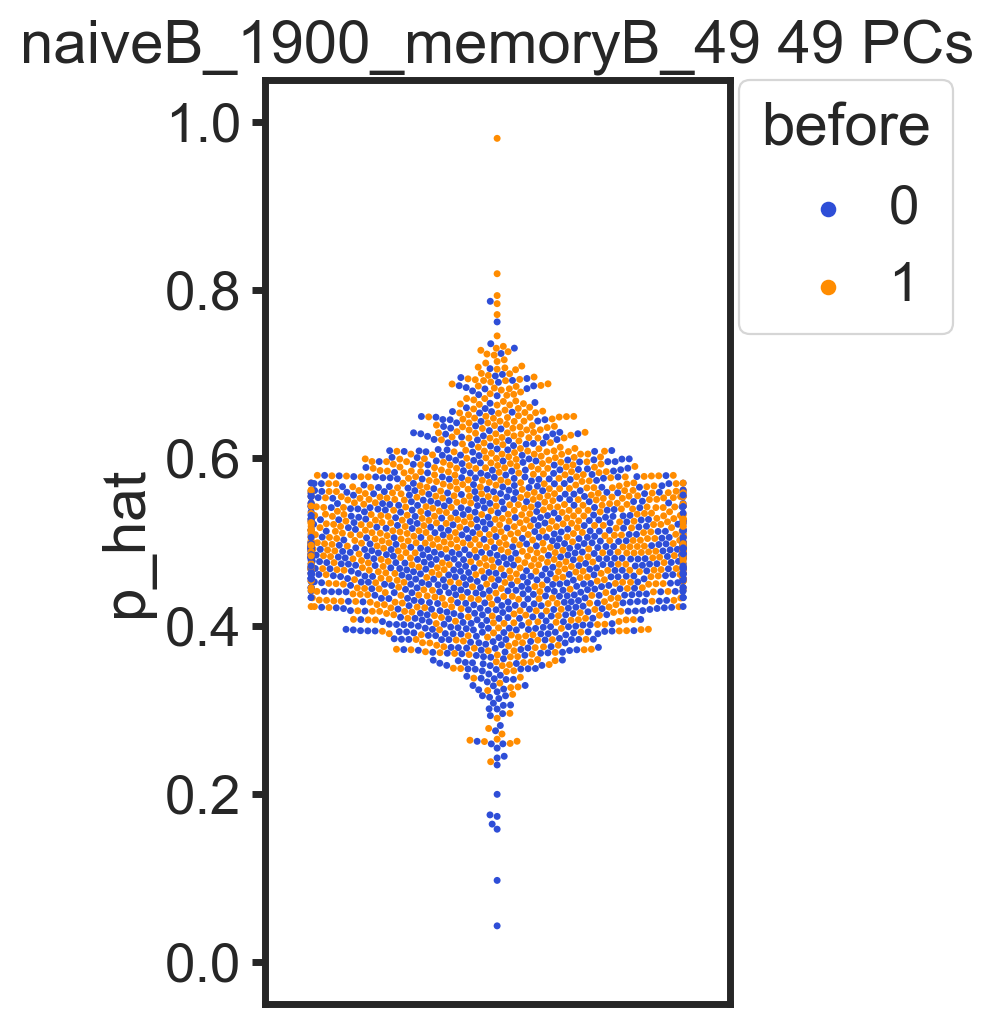

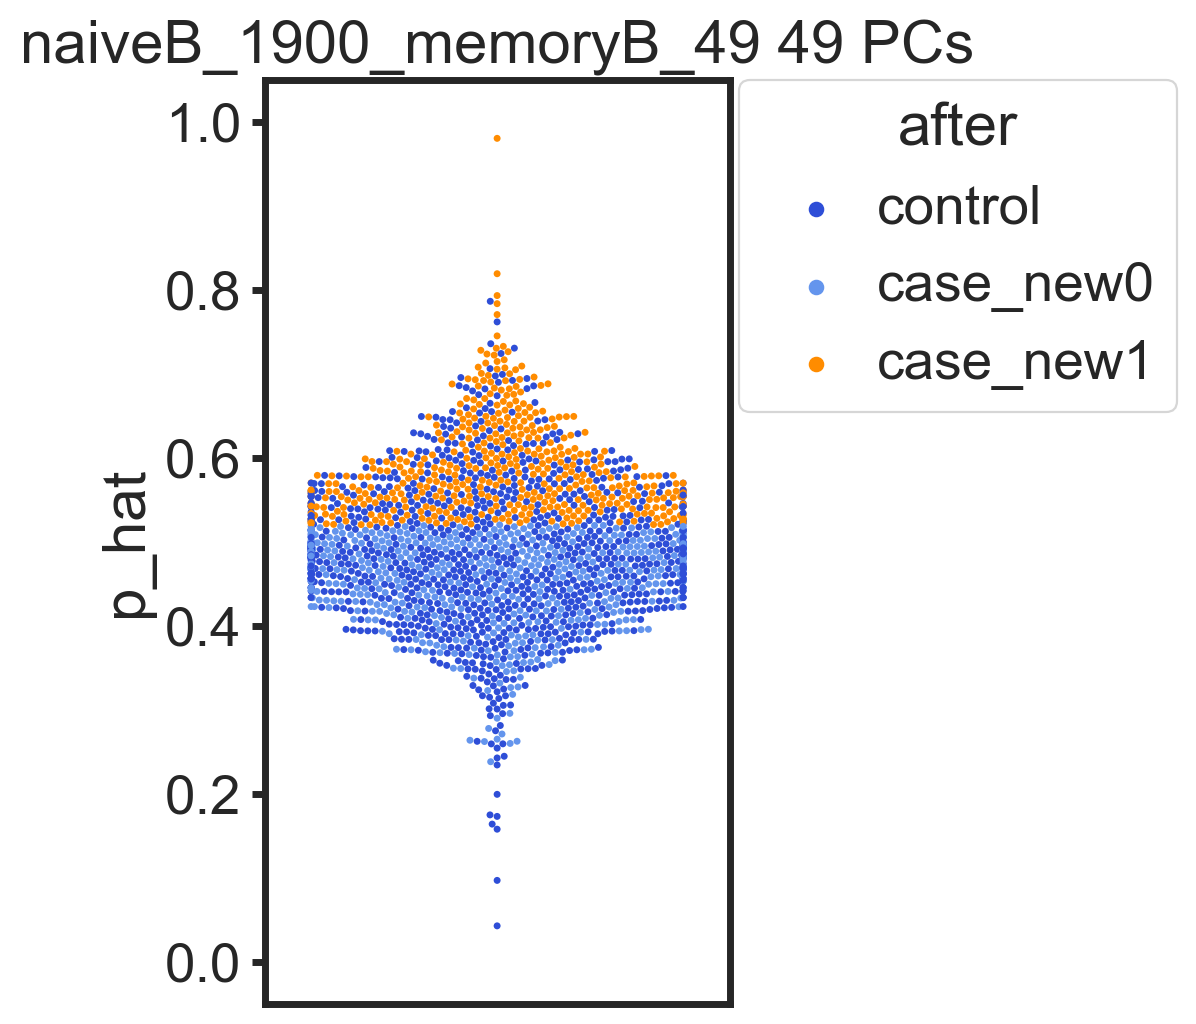

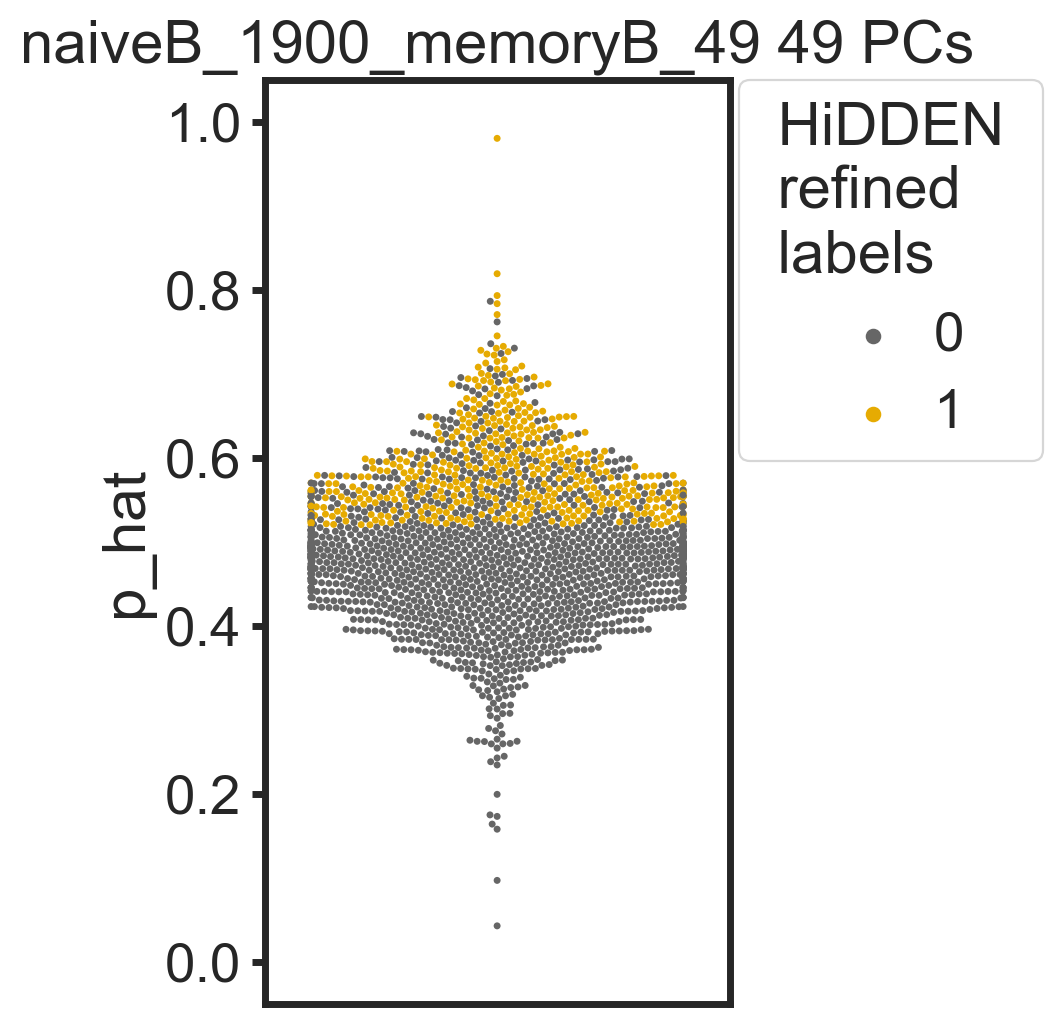

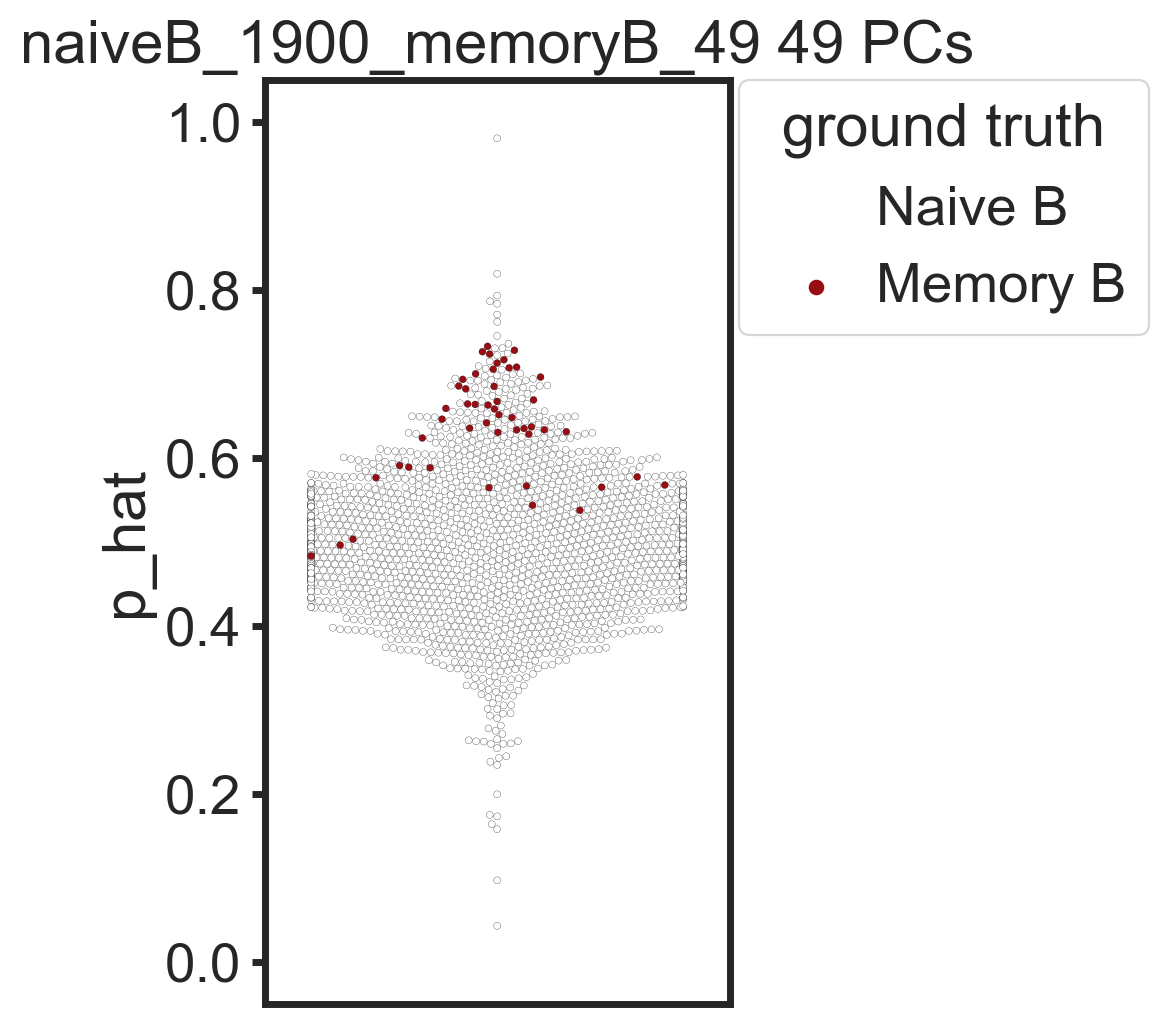

In [65]:
#df = sc.get.obs_df(adata_work, ['p_hat', 'logit_p_hat', 'new_labels', 'batch', 'three_labels_batch_newlabels', 'dataset'])
#df.columns = ['p_hat', 'logit_p_hat', 'new_labels', 'batch', 'three_labels_batch_newlabels', 'dataset']
#df['original_labels'] = df['batch'].apply(lambda x: 'PBS' if x=='0' else 'LPC')

plt.figure(figsize=(3, 6))
sns.swarmplot(data=adata_work.obs, x='dataset', y='p_hat', hue="batch", size=2.5, palette=['#2E4ED7', 'darkorange'])
plt.ylim(-0.05, 1.05)
plt.legend(title = 'before', bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0, handletextpad=0.1)
plt.xticks([])
plt.xlabel("")
plt.title(f'{title_str}')
plt.savefig(f'{output_path}/swarmplot_batch_{title_str}.png', dpi=300, transparent=True, bbox_inches='tight')
plt.savefig(f'{output_path}/swarmplot_batch_{title_str}.svg', transparent=True, bbox_inches='tight')
plt.savefig(f'{output_path}/swarmplot_batch_{title_str}.pdf', transparent=True, bbox_inches='tight')
plt.show()

conditions = [
    (adata_work.obs['batch']==0),
    (adata_work.obs['batch']==1) & (adata_work.obs['new_labels']==0),
    (adata_work.obs['batch']==1) & (adata_work.obs['new_labels']==1)
]
values = ['control', 'case_new0', 'case_new1']
adata_work.obs['three_labels_batch_newlabels'] = np.select(conditions, values)

plt.figure(figsize=(3, 6))
sns.swarmplot(data=adata_work.obs, x='dataset', y='p_hat', hue="three_labels_batch_newlabels", size=2.5, 
              hue_order=['control', 'case_new0', 'case_new1'],
              palette=['#2E4ED7', 'cornflowerblue', 'darkorange'])
plt.ylim(-0.05, 1.05)
plt.legend(title = 'after', bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0, handletextpad=0.1)
plt.xticks([])
plt.xlabel("")
plt.title(f'{title_str}')
plt.savefig(f'{output_path}/swarmplot_threelabels_{title_str}.png', dpi=300, transparent=True, bbox_inches='tight')
plt.savefig(f'{output_path}/swarmplot_threelables_{title_str}.svg', transparent=True, bbox_inches='tight')
plt.savefig(f'{output_path}/swarmplot_threelabels_{title_str}.pdf', transparent=True, bbox_inches='tight')
plt.show()

plt.figure(figsize=(3, 6))
sns.swarmplot(data=adata_work.obs, x='dataset', y='p_hat', hue="new_labels", size=2.5, 
              hue_order=[0, 1],
              palette={0:'#666666', 1:'#e6ab02'})
plt.ylim(-0.05, 1.05)
plt.legend(title = ' HiDDEN \n refined \n labels', bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0, handletextpad=0.1)
plt.xticks([])
plt.xlabel("")
plt.title(f'{title_str}')
plt.savefig(f'{output_path}/swarmplot_newlabels_{title_str}.png', dpi=300, transparent=True, bbox_inches='tight')
plt.savefig(f'{output_path}/swarmplot_newlabels_{title_str}.svg', transparent=True, bbox_inches='tight')
plt.savefig(f'{output_path}/swarmplot_newlabels_{title_str}.pdf', transparent=True, bbox_inches='tight')
plt.show()


#df = sc.get.obs_df(adata_timepoint, ['p_hat', 'logit_p_hat', 'new_labels', 'status', 'three_labels', 'timepoint'])
#df.columns = ['p_hat', 'logit_p_hat', 'new_labels', 'status', 'three_labels', 'timepoint']

plt.figure(figsize=(3, 6))
sns.swarmplot(data=adata_work.obs, x='dataset', y='p_hat', hue="perturbed", size=2.5, hue_order=['Naive B', 'Memory B'], 
              palette=['white', reds_palette(W_m if W_m!=1 else 0.9)], edgecolor='k', linewidth=0.1)
plt.ylim(-0.05, 1.05)
plt.legend(title = 'ground truth', bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0, handletextpad=0.1)
plt.xticks([])
plt.xlabel("")
plt.title(f'{title_str}')
plt.savefig(f'{output_path}/swarmplot_perturbed_{title_str}.png', dpi=300, transparent=True, bbox_inches='tight')
plt.savefig(f'{output_path}/swarmplot_perturbed_{title_str}.svg', transparent=True, bbox_inches='tight')
plt.savefig(f'{output_path}/swarmplot_perturbed_{title_str}.pdf', transparent=True, bbox_inches='tight')
plt.show()

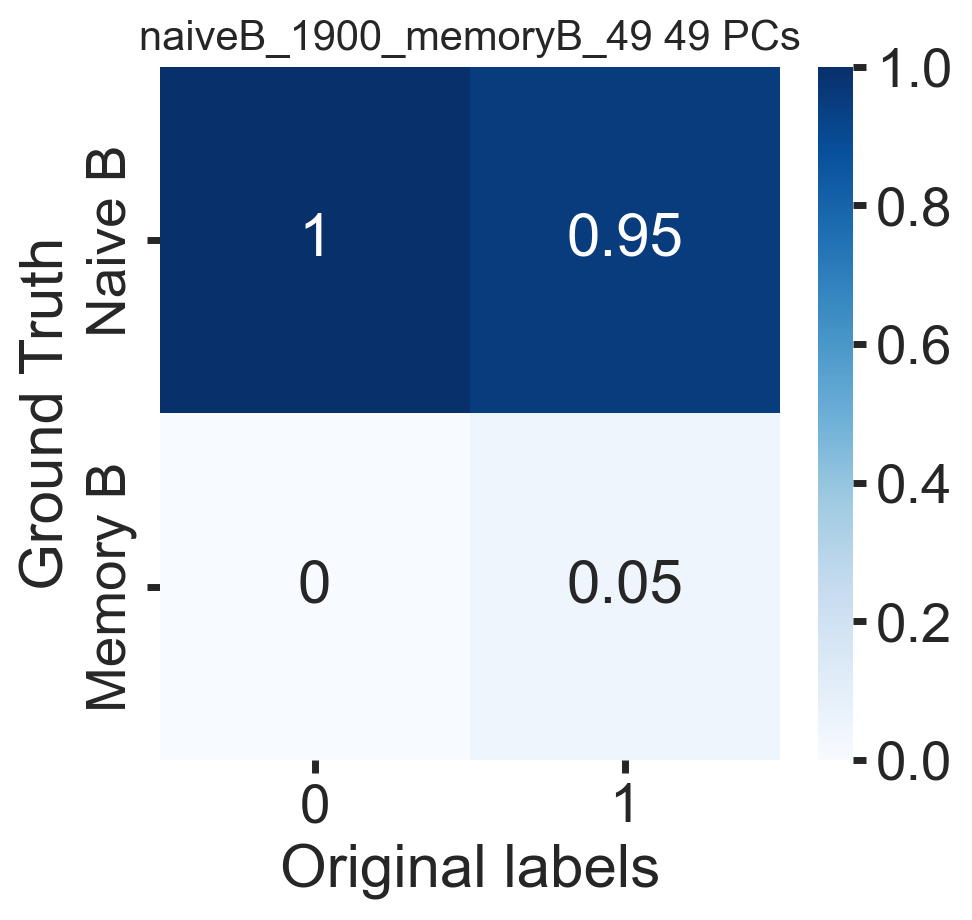

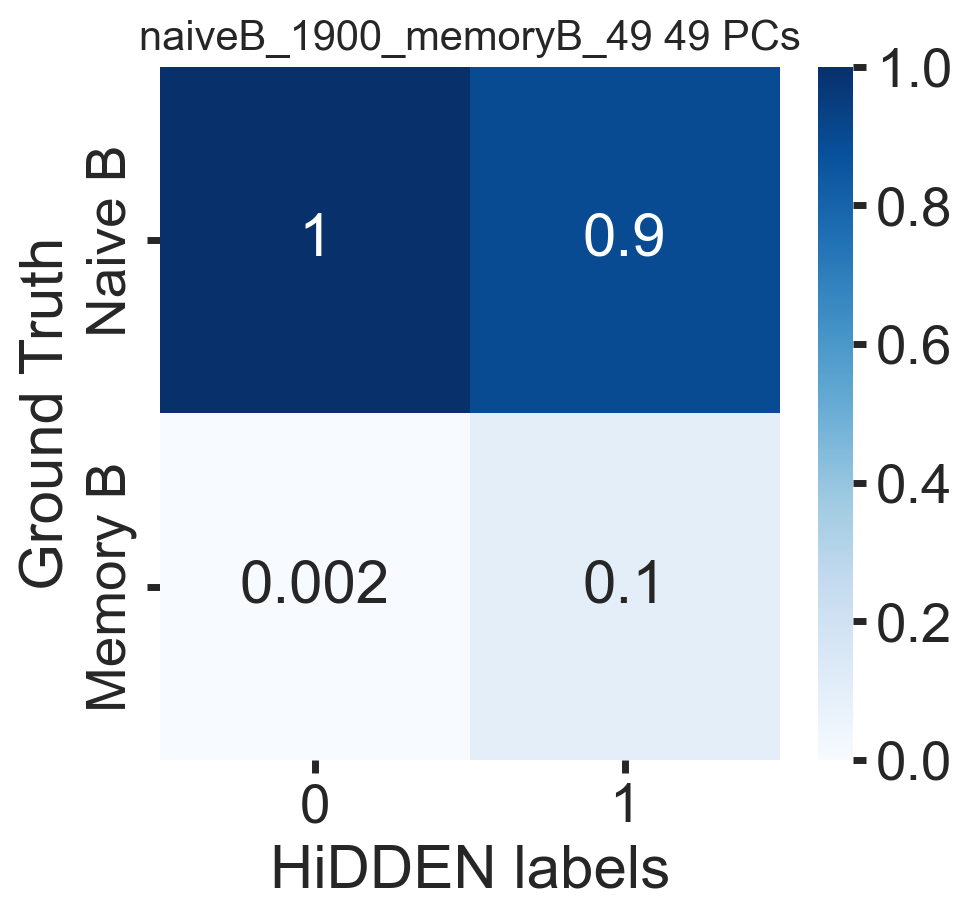

In [66]:
# confusion matrix between original labels and perturbed
plt.figure(figsize=(5, 4.5))
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
y_true = (adata_work.obs['perturbed'] == "Memory B").astype('int')
y_pred = adata_work.obs['batch'].values.astype('int')
cm = confusion_matrix(y_true, y_pred)
cm = pd.DataFrame(cm).div(cm.sum(axis=0), axis=1)
heatmap = sns.heatmap(cm, annot=True, xticklabels=[0, 1], yticklabels=['Naive B', 'Memory B'], vmin=0, vmax=1, cmap='Blues')
plt.title(f'{title_str}', fontsize=15)
plt.ylabel('Ground Truth')
plt.xlabel('Original labels')
plt.savefig(f'{output_path}/confusionmatrix_original_columns_{title_str}.png', dpi=300, transparent=True, bbox_inches='tight')
plt.savefig(f'{output_path}/confusionmatrix_original_columns_{title_str}.svg', transparent=True, bbox_inches='tight')
plt.savefig(f'{output_path}/confusionmatrix_original_columns_{title_str}.pdf', transparent=True, bbox_inches='tight')
plt.show()

# confusion matrix between new labels and perturbed
plt.figure(figsize=(5, 4.5))
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
y_true = (adata_work.obs['perturbed'] == "Memory B").astype('int')
y_pred = adata_work.obs['new_labels'].values.astype('int')
cm = confusion_matrix(y_true, y_pred)
cm = pd.DataFrame(cm).div(cm.sum(axis=0), axis=1)
heatmap = sns.heatmap(cm, annot=True, xticklabels=[0, 1], yticklabels=['Naive B', 'Memory B'], vmin=0, vmax=1, cmap='Blues')
plt.title(f'{title_str}', fontsize=15)
plt.ylabel('Ground Truth')
plt.xlabel('HiDDEN labels')
plt.savefig(f'{output_path}/confusionmatrix_columns_HiDDEN_{title_str}.png', dpi=300, transparent=True, bbox_inches='tight')
plt.savefig(f'{output_path}/confusionmatrix_columns_HiDDEN_{title_str}.svg', transparent=True, bbox_inches='tight')
plt.savefig(f'{output_path}/confusionmatrix_columns_HiDDEN_{title_str}.pdf', transparent=True, bbox_inches='tight')
plt.show()

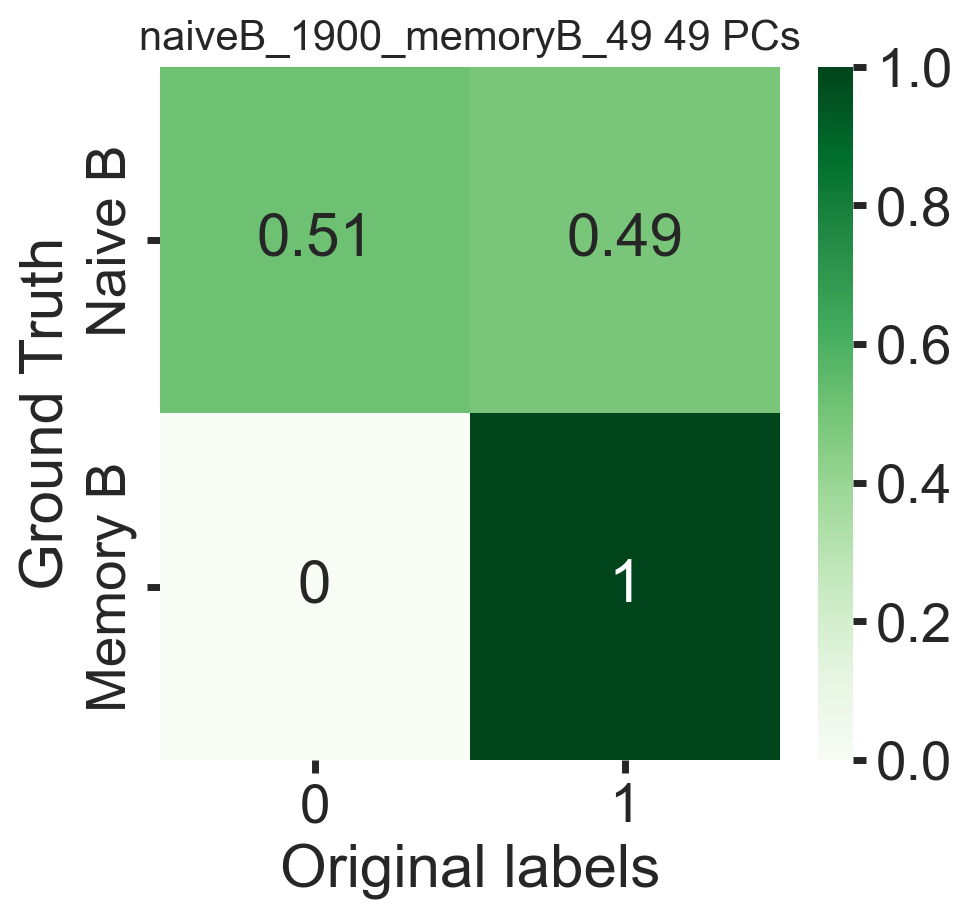

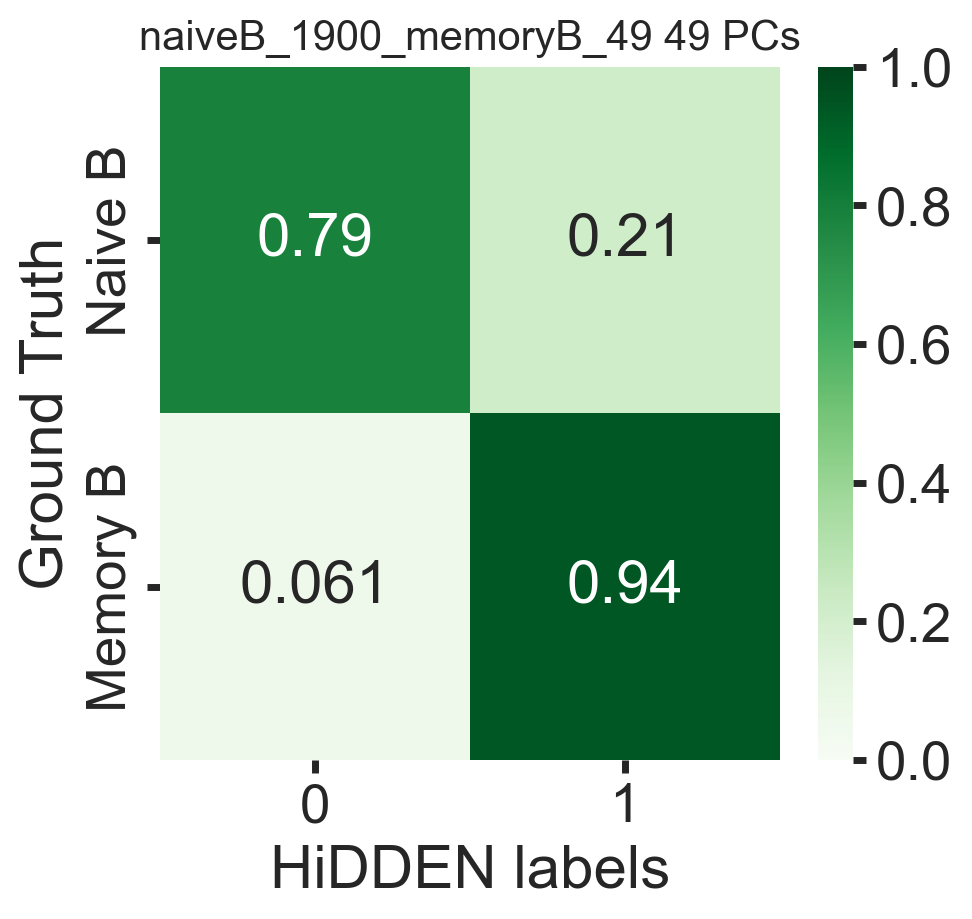

In [67]:
# confusion matrix between original labels and perturbed
plt.figure(figsize=(5, 4.5))
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
y_true = (adata_work.obs['perturbed'] == "Memory B").astype('int')
y_pred = adata_work.obs['batch'].values.astype('int')
cm = confusion_matrix(y_true, y_pred)
cm = pd.DataFrame(cm).div(cm.sum(axis=1), axis=0)
heatmap = sns.heatmap(cm, annot=True, xticklabels=[0, 1], yticklabels=['Naive B', 'Memory B'], vmin=0, vmax=1, cmap='Greens')
plt.title(f'{title_str}', fontsize=15)
plt.ylabel('Ground Truth')
plt.xlabel('Original labels')
plt.savefig(f'{output_path}/confusionmatrix_rows_original_{title_str}.png', dpi=300, transparent=True, bbox_inches='tight')
plt.savefig(f'{output_path}/confusionmatrix_rows_original_{title_str}.svg', transparent=True, bbox_inches='tight')
plt.savefig(f'{output_path}/confusionmatrix_rows_original_{title_str}.pdf', transparent=True, bbox_inches='tight')
plt.show()

# confusion matrix between new labels and perturbed
plt.figure(figsize=(5, 4.5))
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
y_true = (adata_work.obs['perturbed'] == "Memory B").astype('int')
y_pred = adata_work.obs['new_labels'].values.astype('int')
cm = confusion_matrix(y_true, y_pred)
cm = pd.DataFrame(cm).div(cm.sum(axis=1), axis=0)
heatmap = sns.heatmap(cm, annot=True, xticklabels=[0, 1], yticklabels=['Naive B', 'Memory B'], vmin=0, vmax=1, cmap='Greens')
plt.title(f'{title_str}', fontsize=15)
plt.ylabel('Ground Truth')
plt.xlabel('HiDDEN labels')
plt.savefig(f'{output_path}/confusionmatrix_rows_HiDDEN_{title_str}.png', dpi=300, transparent=True, bbox_inches='tight')
plt.savefig(f'{output_path}/confusionmatrix_rows_HiDDEN_{title_str}.svg', transparent=True, bbox_inches='tight')
plt.savefig(f'{output_path}/confusionmatrix_rows_HiDDEN_{title_str}.pdf', transparent=True, bbox_inches='tight')
plt.show()

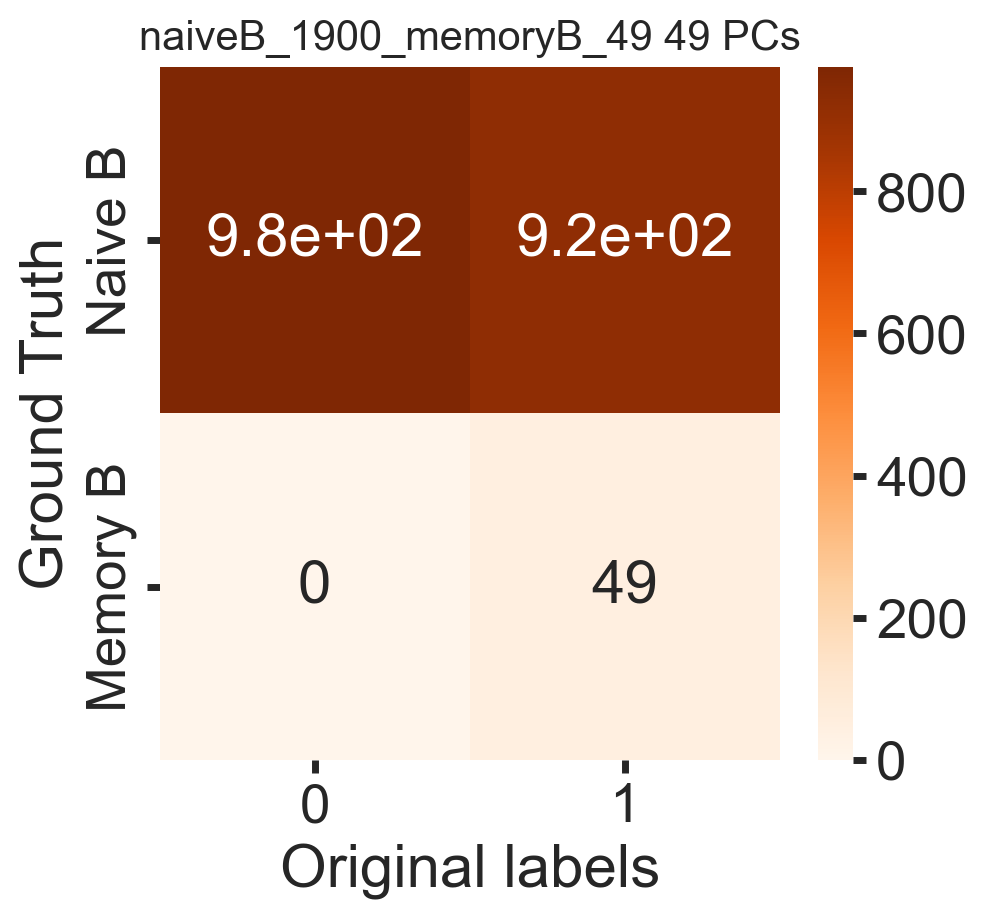

[[975 925]
 [  0  49]]


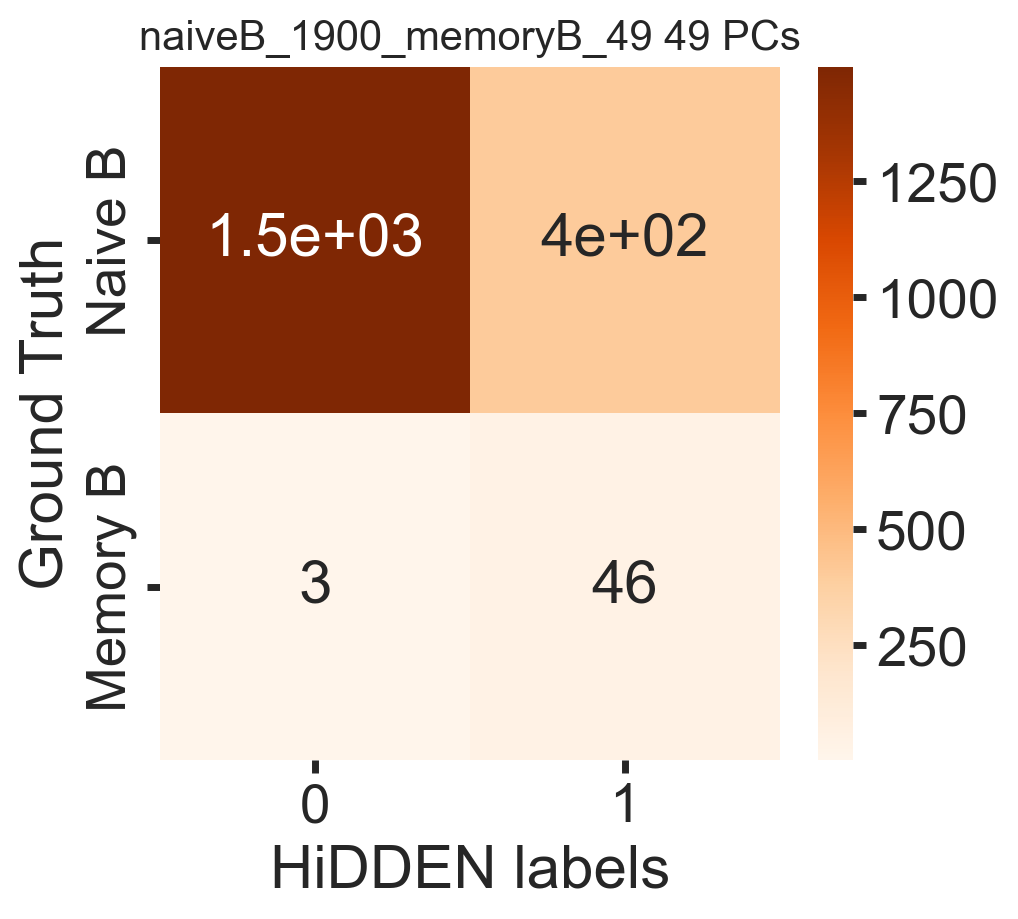

[[1497  403]
 [   3   46]]


In [68]:
# confusion matrix between original labels and perturbed
plt.figure(figsize=(5, 4.5))
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
y_true = (adata_work.obs['perturbed'] == "Memory B").astype('int')
y_pred = adata_work.obs['batch'].values.astype('int')
cm = confusion_matrix(y_true, y_pred)
heatmap = sns.heatmap(cm, annot=True, xticklabels=[0, 1], yticklabels=['Naive B', 'Memory B'], cmap='Oranges')
plt.title(f'{title_str}', fontsize=15)
plt.ylabel('Ground Truth')
plt.xlabel('Original labels')
plt.savefig(f'{output_path}/confusionmatrix_raw_original_{title_str}.png', dpi=300, transparent=True, bbox_inches='tight')
plt.savefig(f'{output_path}/confusionmatrix_raw_original_{title_str}.svg', transparent=True, bbox_inches='tight')
plt.savefig(f'{output_path}/confusionmatrix_raw_original_{title_str}.pdf', transparent=True, bbox_inches='tight')
plt.show()
print(cm)

# confusion matrix between new labels and perturbed
plt.figure(figsize=(5, 4.5))
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
y_true = (adata_work.obs['perturbed'] == "Memory B").astype('int')
y_pred = adata_work.obs['new_labels'].values.astype('int')
cm = confusion_matrix(y_true, y_pred)
heatmap = sns.heatmap(cm, annot=True, xticklabels=[0, 1], yticklabels=['Naive B', 'Memory B'], cmap='Oranges')
plt.title(f'{title_str}', fontsize=15)
plt.ylabel('Ground Truth')
plt.xlabel('HiDDEN labels')
plt.savefig(f'{output_path}/confusionmatrix_raw_HiDDEN_{title_str}.png', dpi=300, transparent=True, bbox_inches='tight')
plt.savefig(f'{output_path}/confusionmatrix_raw_HiDDEN_{title_str}.svg', transparent=True, bbox_inches='tight')
plt.savefig(f'{output_path}/confusionmatrix_raw_HiDDEN_{title_str}.pdf', transparent=True, bbox_inches='tight')
plt.show()
print(cm)

FileNotFoundError: [Errno 2] No such file or directory: 'figures/figure1/split_violin_batch_naiveB_1900_memoryB_49 49 PCs.png'

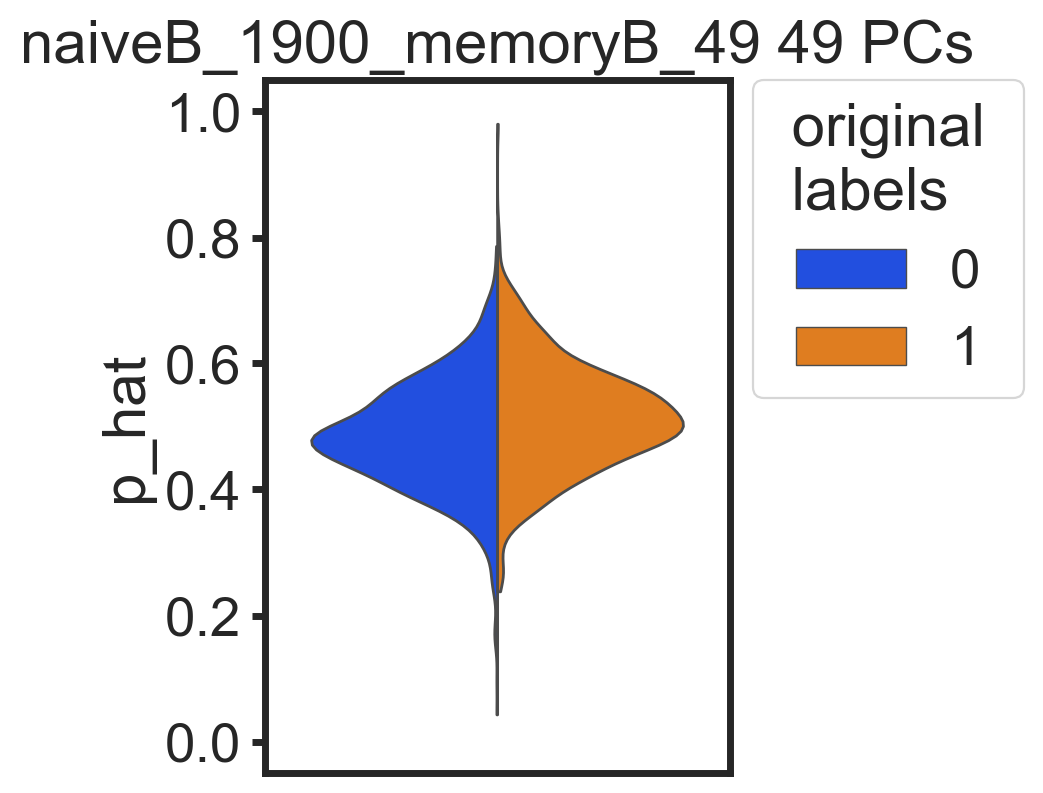

In [69]:
# for schematic in figure 1
plt.figure(figsize=(3, 4.5))
plt.ylim(-0.05, 1.05)
sns.violinplot(data=adata_work.obs, x='dataset', y='p_hat', hue="batch", split=True, linewidth=1, scale='count', cut=0, 
               inner=None, scale_hue=False) 
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0, title=' original \n labels')
plt.xticks([])
plt.xlabel("")
plt.title(f'{title_str}')
plt.savefig(f'figures/figure1/split_violin_batch_{title_str}.png', dpi=300, transparent=True, bbox_inches='tight')
plt.savefig(f'figures/figure1/split_violin_batch_{title_str}.svg', transparent=True, bbox_inches='tight')
plt.savefig(f'figures/figure1/split_violin_batch_{title_str}.pdf', transparent=True, bbox_inches='tight')
plt.show()

plt.figure(figsize=(3, 4.5))
plt.ylim(-0.05, 1.05)
sns.violinplot(data=adata_work.obs, x='dataset', y='p_hat', hue="batch", split=True, linewidth=1, scale='count', cut=0, 
               inner=None, scale_hue=False, palette={0:'#666666', 1:'#666666'}) 
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0, title=' original \n labels')
plt.xticks([])
plt.xlabel("")
plt.title(f'{title_str}')
plt.savefig(f'figures/figure1/split_violin_gray_{title_str}.png', dpi=300, transparent=True, bbox_inches='tight')
plt.savefig(f'figures/figure1/split_violin_gray_{title_str}.svg', transparent=True, bbox_inches='tight')
plt.savefig(f'figures/figure1/split_violin_gray_{title_str}.pdf', transparent=True, bbox_inches='tight')
plt.show()

plt.figure(figsize=(3, 4.5))
plt.ylim(-0.05, 1.05)
sns.violinplot(data=adata_work.obs, x='dataset', y='p_hat', hue="batch", split=True, linewidth=1, scale='count', cut=0, 
               inner=None, scale_hue=False, palette={0:'#666666', 1:'#e6ab02'}).axhline(np.min(adata_work.obs['p_hat'][adata_work.obs['new_labels']==1]), c='k', lw=1.5)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0, title=' HiDDEN \n refined \n labels')
plt.xticks([])
plt.yticks([np.min(adata_work.obs['p_hat'][adata_work.obs['new_labels']==1])])
plt.xlabel("")
plt.title(f'{title_str}')
plt.savefig(f'figures/figure1/split_violin_HiDDEN_{title_str}.png', dpi=300, transparent=True, bbox_inches='tight')
plt.savefig(f'figures/figure1/split_violin_HiDDEN_{title_str}.svg', transparent=True, bbox_inches='tight')
plt.savefig(f'figures/figure1/split_violin_HiDDEN_{title_str}.pdf', transparent=True, bbox_inches='tight')
plt.show()

## AUROC for Memory B labels

In [ ]:
from sklearn.metrics import roc_curve, auc

def plot_roc_curve(y_true, y_pred, name, ax=None, ls='solid', lw=5, color='blue'):
    ax = ax or plt.gca()
    fpr, tpr, _ = roc_curve(y_true, y_pred)
    roc_auc = auc(fpr, tpr)
    ax.plot(fpr, tpr, linestyle=ls, lw=lw, c=color, label=f"{name} (AUC = {roc_auc:.2f})")
    ax.set_xlim([-0.05, 1.05])
    ax.set_ylim([-0.05, 1.05])
    ax.set_xlabel("False Positive Rate")
    ax.set_ylabel("True Positive Rate")
    ax.legend(loc="lower right")

In [ ]:
adata_work.obs['new_labels'].to_csv(f'{output_path}/new_labels_{title_str}.csv')
adata_work.obs['p_hat'].to_csv(f'{output_path}/p_hat_{title_str}.csv')
adata_work.obs['perturbed'].to_csv(f'{output_path}/ground_truth_{title_str}.csv')
adata_work.obs['batch'].to_csv(f'{output_path}/batch_{title_str}.csv')

In [ ]:
output_path

In [ ]:
fig = plt.figure(figsize=(8, 3))
ax = plt.gca()

y_true = pd.read_csv(f'{output_path}/ground_truth_{title_str}.csv')['perturbed'].values == 'Memory B'

y_pred = pd.read_csv(f'{output_path}/p_hat_{title_str}.csv')['p_hat'].values
plot_roc_curve(y_true, y_pred, name=f'HiDDEN', color=reds_palette(W_m if W_m!=1 else 0.9), lw=2.5)

y_pred = pd.read_csv(f'{output_path}/batch_{title_str}.csv')['batch'].values
plot_roc_curve(y_true, y_pred, name=f'original', color='k', ls='dashed', lw=2.5)

plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
plt.title(f'{title_str}')
plt.savefig(f'{output_path}/AUROC_HiDDEN_original_{title_str}.png', dpi=300, transparent=True, bbox_inches='tight')
plt.savefig(f'{output_path}/AUROC_HiDDEN_original_{title_str}.svg', transparent=True, bbox_inches='tight')
plt.savefig(f'{output_path}/AUROC_HiDDEN_original_{title_str}.pdf', transparent=True, bbox_inches='tight')
plt.show()

## Mutual information between true labels and HiDDEN labels

In [ ]:
mutual_information_dict = dict(np.load('figures/ablation/mutual_information_dict.npz'))
mutual_information_dict[f'{title_str}'] = [sklearn.metrics.mutual_info_score(adata_work.obs['perturbed'], adata_work.obs['new_labels']), 
                                           sklearn.metrics.mutual_info_score(adata_work.obs['perturbed'], adata_work.obs['batch']), 
                                           sklearn.metrics.mutual_info_score(adata_work.obs['perturbed'], adata_work.obs['perturbed'])]
np.savez_compressed('figures/ablation/mutual_information_dict.npz', **mutual_information_dict)

In [166]:
mutual_information_dict[f'{title_str}']

[0.03019649756422857, 0.017763943559666262, 0.11742336271893489]

## DE genes

In [168]:
# volcano plot for Figure 1
def plot_volcano(adata, label):
    adata.obs[label] = adata.obs[label].astype('category')
    sc.tl.rank_genes_groups(adata, label, method='wilcoxon')
    result = adata.uns['rank_genes_groups']
    groups = result['names'].dtype.names
    result_df = pd.DataFrame(
        {group + '_' + key[:1]: result[key][group]
        for group in groups for key in ['names', 'pvals_adj', 'logfoldchanges']})
    level0 = np.unique(adata.obs[label])[0]
    level1 = np.unique(adata.obs[label])[1]
    result_0_df = result_df[[f'{level0}_n', f'{level0}_p', f'{level0}_l']]
    result_1_df = result_df[[f'{level1}_n', f'{level1}_p', f'{level1}_l']]
    level0_DEs = result_0_df.loc[result_0_df[f'{level0}_p']<0.05].loc[result_0_df[f'{level0}_l']>0][f'{level0}_n'].values
    level1_DEs = result_1_df.loc[result_1_df[f'{level1}_p']<0.05].loc[result_1_df[f'{level1}_l']>0][f'{level1}_n'].values
    
    #plt.scatter(result_df[f'{level1}_l'], -np.log10(result_df[f'{level1}_p']), c='k')
    #plt.show()
    return(pd.DataFrame(result_df))

de_batch_result_df = plot_volcano(adata_work, 'batch')
de_hidden_result_df = plot_volcano(adata_work, 'new_labels')
de_groundt_result_df = plot_volcano(adata_work, 'perturbed')

... storing 'perturbed' as categorical
... storing 'dataset' as categorical
... storing 'three_labels_batch_newlabels' as categorical


In [169]:
de_batch_result_df

0_n  0_p       0_l       1_n  1_p       1_l
0          IGHD  1.0  0.209579     EVI2B  1.0  0.381305
1        PET100  1.0  0.461544     RPS23  1.0  0.060026
2         RPS24  1.0  0.101924       AES  1.0  0.459177
3        TMSB4X  1.0  0.058250    NUCKS1  1.0  0.513959
4      HLA-DQA1  1.0  0.202071      EEF2  1.0  0.200689
...         ...  ...       ...       ...  ...       ...
17004      EEF2  1.0 -0.200689  HLA-DQA1  1.0 -0.202071
17005    NUCKS1  1.0 -0.513959    TMSB4X  1.0 -0.058250
17006       AES  1.0 -0.459177     RPS24  1.0 -0.101924
17007     RPS23  1.0 -0.060026    PET100  1.0 -0.461544
17008     EVI2B  1.0 -0.381305      IGHD  1.0 -0.209579

[17009 rows x 6 columns]

In [170]:
de_groundt_result_df


Memory B_n    Memory B_p  Memory B_l Naive B_n     Naive B_p  Naive B_l
0            B2M  9.009551e-06    0.511959      IGHD  2.491523e-10   3.650908
1          COTL1  2.986922e-03    2.055955     TCL1A  2.017047e-08  31.471003
2          RPS14  1.182048e-02    0.339568     CXCR4  1.807069e-06   2.106880
3         EEF1A1  1.323856e-02    0.275340      CD74  5.813949e-06   0.425408
4          ITGB1  1.481249e-02    3.914753      BTG1  5.813949e-06   1.196487
...          ...           ...         ...       ...           ...        ...
17004       BTG1  5.813949e-06   -1.196487     ITGB1  1.481249e-02  -3.914753
17005       CD74  5.813949e-06   -0.425408    EEF1A1  1.323856e-02  -0.275340
17006      CXCR4  1.807069e-06   -2.106880     RPS14  1.182048e-02  -0.339568
17007      TCL1A  2.017047e-08  -31.471003     COTL1  2.986922e-03  -2.055955
17008       IGHD  2.491523e-10   -3.650908       B2M  9.009551e-06  -0.511959

[17009 rows x 6 columns]

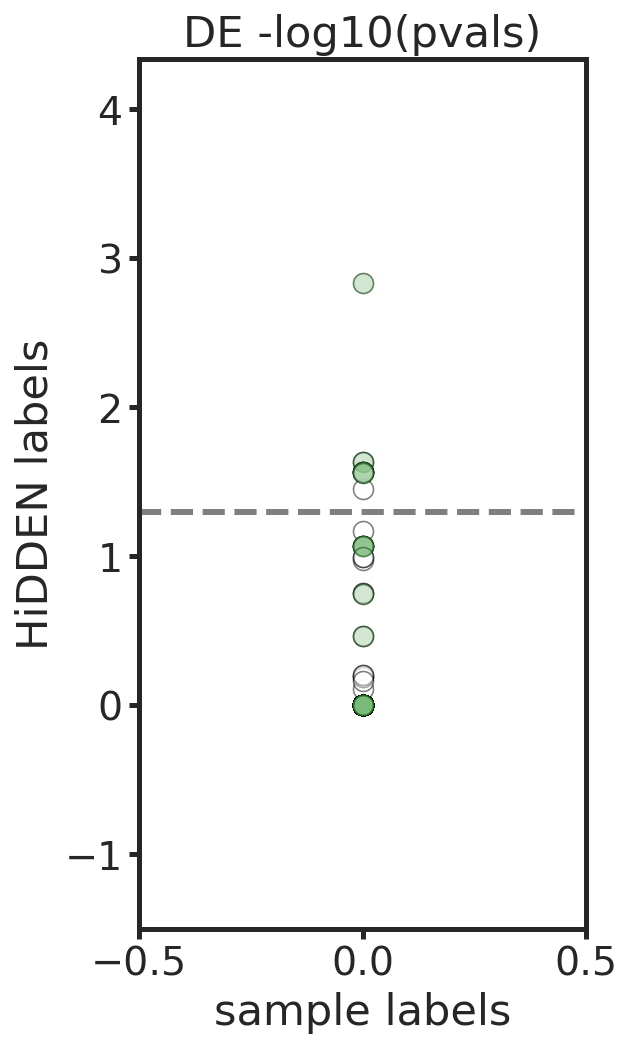

In [171]:
de_merged_result_df = pd.merge(de_batch_result_df[['1_n', '1_l', '1_p']], de_hidden_result_df[['1_n', '1_l', '1_p']], left_on='1_n', right_on='1_n')
de_merged_result_df = pd.merge(de_merged_result_df, de_groundt_result_df[['Memory B_n', 'Memory B_l', 'Memory B_p']], left_on='1_n', right_on='Memory B_n')
plt.figure(figsize=(4, 8))
plt.scatter(-np.log10(de_merged_result_df['1_p_x']), -np.log10(de_merged_result_df['1_p_y']), c='w', alpha=0.5, edgecolors='k', s=100)
#plt.scatter(-np.log10(de_merged_result_df['1_p_x']), -np.log10(de_merged_result_df['1_p_y']), c='k', alpha=0.2, s=100)
plt.scatter(-np.log10(de_merged_result_df['1_p_x'])[-np.log10(de_merged_result_df['Memory B_p'])>-np.log10(0.05)],
            -np.log10(de_merged_result_df['1_p_y'])[-np.log10(de_merged_result_df['Memory B_p'])>-np.log10(0.05)], c='forestgreen', alpha=0.2, s=100)
plt.xlim([-0.5, np.max(-np.log10(de_merged_result_df['1_p_x']))+0.5])
plt.ylim([-1.5, np.max(-np.log10(de_merged_result_df['1_p_y']))+1.5])
plt.xlabel('sample labels')
plt.ylabel('HiDDEN labels')
plt.title('DE -log10(pvals)')
plt.axhline(y = -np.log10(0.05), color = 'k', linestyle = '--', linewidth=3, alpha=0.5)
plt.axvline(x = -np.log10(0.05), color = 'k', linestyle = '--', linewidth=3, alpha=0.5)
plt.savefig(f'figures/figure1/pvals_scatter.png', dpi=300, transparent=True, bbox_inches='tight')
plt.savefig(f'figures/figure1/pvals_scatter.svg', transparent=True, bbox_inches='tight')
plt.savefig(f'figures/figure1/pvals_scatter.pdf', transparent=True, bbox_inches='tight')
plt.show()

In [172]:
def get_DE_genes(adata, label):
    
    adata.obs[label] = adata.obs[label].astype('category')
    sc.tl.rank_genes_groups(adata, label, method='wilcoxon')
    result = adata.uns['rank_genes_groups']
    groups = result['names'].dtype.names
    result_df = pd.DataFrame(
        {group + '_' + key[:1]: result[key][group]
        for group in groups for key in ['names', 'pvals_adj', 'logfoldchanges']})
    level0 = np.unique(adata.obs[label])[0]
    level1 = np.unique(adata.obs[label])[1]
    result_0_df = result_df[[f'{level0}_n', f'{level0}_p', f'{level0}_l']]
    result_1_df = result_df[[f'{level1}_n', f'{level1}_p', f'{level1}_l']]
    level0_DEs = result_0_df.loc[result_0_df[f'{level0}_p']<0.05].loc[result_0_df[f'{level0}_l']>0][f'{level0}_n'].values
    level1_DEs = result_1_df.loc[result_1_df[f'{level1}_p']<0.05].loc[result_1_df[f'{level1}_l']>0][f'{level1}_n'].values
    
    DE_dict = {f'{level0}':level0_DEs, f'{level1}':level1_DEs}
    
    return(DE_dict)

In [173]:
DE_groundt_dict = get_DE_genes(adata_work, 'perturbed')
#print(DE_groundt_dict.keys())
MemoryB_groundt_DEs = DE_groundt_dict['Memory B']
NaiveB_groundt_DEs = DE_groundt_dict['Naive B']
print(MemoryB_groundt_DEs.shape[0], NaiveB_groundt_DEs.shape[0])

7 6


In [174]:
DE_orig_dict = get_DE_genes(adata_work, 'batch')
#print(DE_orig_dict.keys())
case_orig_DEs = DE_orig_dict['1']
control_orig_DEs = DE_orig_dict['0']
print(case_orig_DEs.shape[0], control_orig_DEs.shape[0])

0 0


In [175]:
DE_HiDDEN_dict = get_DE_genes(adata_work, 'new_labels')
#print(DE_HiDDEN_dict.keys())
new1_DEs = DE_HiDDEN_dict['1']
new0_DEs = DE_HiDDEN_dict['0']
print(new1_DEs.shape[0], new0_DEs.shape[0])

5 6


In [176]:
# get intersections to figure out which are the unique genes

In [177]:
print(len(np.intersect1d(MemoryB_groundt_DEs, new1_DEs)))
HiDDEN_1_uniqueDEs = np.setdiff1d(new1_DEs, MemoryB_groundt_DEs)
print(len(HiDDEN_1_uniqueDEs))
print(len(np.intersect1d(NaiveB_groundt_DEs, new0_DEs)))
HiDDEN_0_uniqueDEs = np.setdiff1d(new0_DEs, NaiveB_groundt_DEs)
print(len(HiDDEN_0_uniqueDEs))

1
4
3
3


In [178]:
#list(MemoryB_groundt_DEs)

In [367]:
def plot_avg_gene_signature(gene_names, gene_sig_name):
    
    gene_names_df = pd.DataFrame(adata_work.var['gene_ids'])
    gene_names_df['idx'] = np.array(range(adata_work.X.shape[1]))
    gene_idxs = gene_names_df['idx'][GENE_NAMES].values

    signature_df = pd.DataFrame(adata_work.layers['lognorm'][:, gene_idxs])
    signature_df.columns = GENE_NAMES
    plot_df = pd.DataFrame(data=signature_df.mean(axis=1), columns=['genes_signature'])
    plot_df['perturbed'] = adata_work.obs['perturbed'].values
    plot_df['batch'] = adata_work.obs['batch'].values
    plot_df['new_labels'] = adata_work.obs['new_labels'].values
    plot_df['dataset'] = f'{orig_or_hybrid}'

    plt.figure(figsize=(3, 4.5))
    sns.violinplot(data=plot_df, x='dataset', y='genes_signature', hue="perturbed", split=True, linewidth=1, #scale='count', 
                   cut=0, inner=None, scale_hue=False, hue_order=['Naive B', 'Memory B'], palette=['white', reds_palette(W_m if W_m!=1 else 0.9)]) 
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0, title=' ground \n truth \n labels')
    #plt.xticks([])
    plt.xlabel("")
    plt.ylabel("avg lognorm expr")
    plt.title(f'{GENE_SIG_NAME} DE genes')
    plt.savefig(f'{output_path}/split_violin_gene_sig_perturbed_{GENE_SIG_NAME}.png', dpi=300, transparent=True, bbox_inches='tight')
    plt.savefig(f'{output_path}/split_violin_gene_sig_perturbed_{GENE_SIG_NAME}.svg', transparent=True, bbox_inches='tight')
    plt.savefig(f'{output_path}/split_violin_gene_sig_perturbed_{GENE_SIG_NAME}.pdf', transparent=True, bbox_inches='tight')
    plt.show()

    plt.figure(figsize=(3, 4.5))
    sns.violinplot(data=plot_df, x='dataset', y='genes_signature', hue="batch", split=True, linewidth=1, #scale='count', 
                   cut=0, inner=None, scale_hue=False) 
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0, title=' original \n labels')
    #plt.xticks([])
    plt.xlabel("")
    plt.ylabel("avg lognorm expr")
    plt.title(f'{GENE_SIG_NAME} DE genes')
    plt.savefig(f'{output_path}/split_violin_gene_sig_batch_{GENE_SIG_NAME}.png', dpi=300, transparent=True, bbox_inches='tight')
    plt.savefig(f'{output_path}/split_violin_gene_sig_batch_{GENE_SIG_NAME}.svg', transparent=True, bbox_inches='tight')
    plt.savefig(f'{output_path}/split_violin_gene_sig_batch_{GENE_SIG_NAME}.pdf', transparent=True, bbox_inches='tight')
    plt.show()

    plt.figure(figsize=(3, 4.5))
    sns.violinplot(data=plot_df, x='dataset', y='genes_signature', hue="new_labels", split=True, linewidth=1, #scale='count', 
                   cut=0, inner=None, scale_hue=False, palette={0:'lightgray', 1:'#e6ab02'}) 
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0, title=' HiDDEN \n labels')
    #plt.xticks([])
    plt.xlabel("")
    plt.ylabel("avg lognorm expr")
    plt.title(f'{GENE_SIG_NAME} DE genes')
    plt.savefig(f'{output_path}/split_violin_gene_sig_HiDDEN_{GENE_SIG_NAME}.png', dpi=300, transparent=True, bbox_inches='tight')
    plt.savefig(f'{output_path}/split_violin_gene_sig_HiDDEN_{GENE_SIG_NAME}.svg', transparent=True, bbox_inches='tight')
    plt.savefig(f'{output_path}/split_violin_gene_sig_HiDDEN_{GENE_SIG_NAME}.pdf', transparent=True, bbox_inches='tight')
    plt.show()

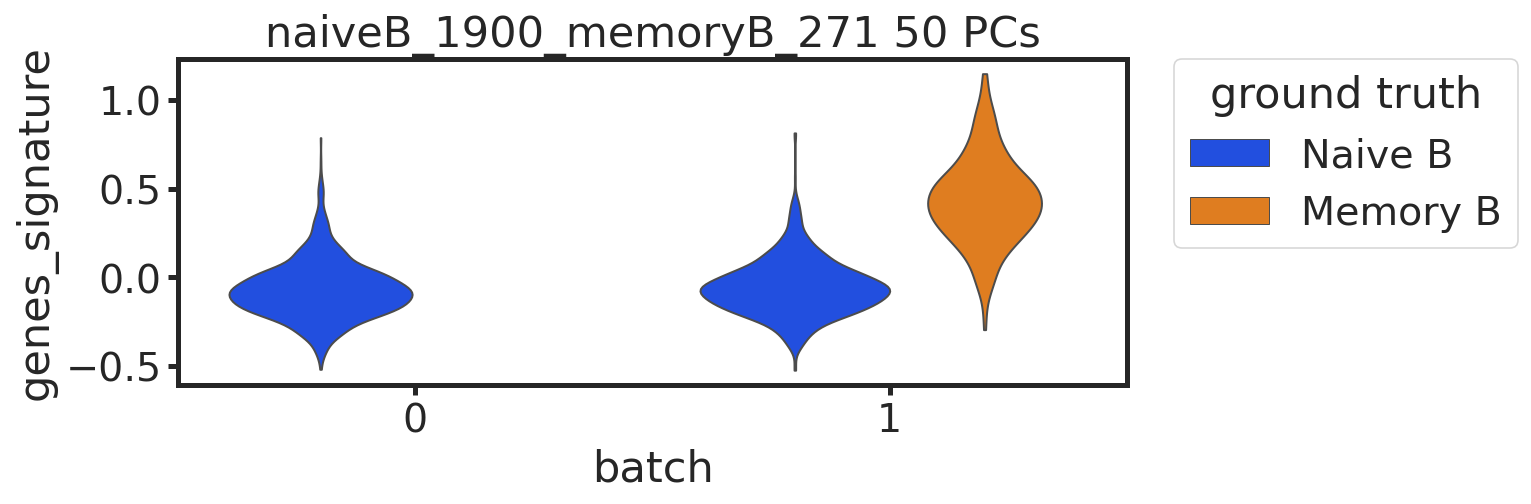

In [391]:
# for figure 1
GENE_NAMES = MemoryB_groundt_DEs
GENE_SIG_NAME = 'Memory B'

gene_names_df = pd.DataFrame(adata_work.var['gene_ids'])
gene_names_df['idx'] = np.array(range(adata_work.X.shape[1]))
gene_idxs = gene_names_df['idx'][GENE_NAMES].values

signature_df = pd.DataFrame(adata_work.layers['lognorm'][:, gene_idxs])
signature_df.columns = GENE_NAMES
plot_df = pd.DataFrame(data=signature_df.mean(axis=1), columns=['genes_signature'])
plot_df['perturbed'] = adata_work.obs['perturbed'].values
plot_df['batch'] = adata_work.obs['batch'].values
plot_df['new_labels'] = adata_work.obs['new_labels'].values
plot_df['dataset'] = f'{orig_or_hybrid}'

###
plt.figure(figsize=(8.5, 3))
#plt.ylim(-0.05, 1.05)
sns.violinplot(data=plot_df, x='batch', y='genes_signature', hue="perturbed", split=False, linewidth=1, cut=0, scale_hue=False,
               hue_order=['Naive B', 'Memory B'], inner=None) 
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0, title='ground truth')
plt.title(f'{title_str}')
plt.savefig(f'{output_path}/violin_gene_sig_HiDDEN_{GENE_SIG_NAME}.png', dpi=300, transparent=True, bbox_inches='tight')
plt.savefig(f'{output_path}/violin_gene_sig_HiDDEN_{GENE_SIG_NAME}.svg', transparent=True, bbox_inches='tight')
plt.savefig(f'{output_path}/violin_gene_sig_HiDDEN_{GENE_SIG_NAME}.pdf', transparent=True, bbox_inches='tight')
plt.show()


###
#plt.figure(figsize=(3, 4.5))

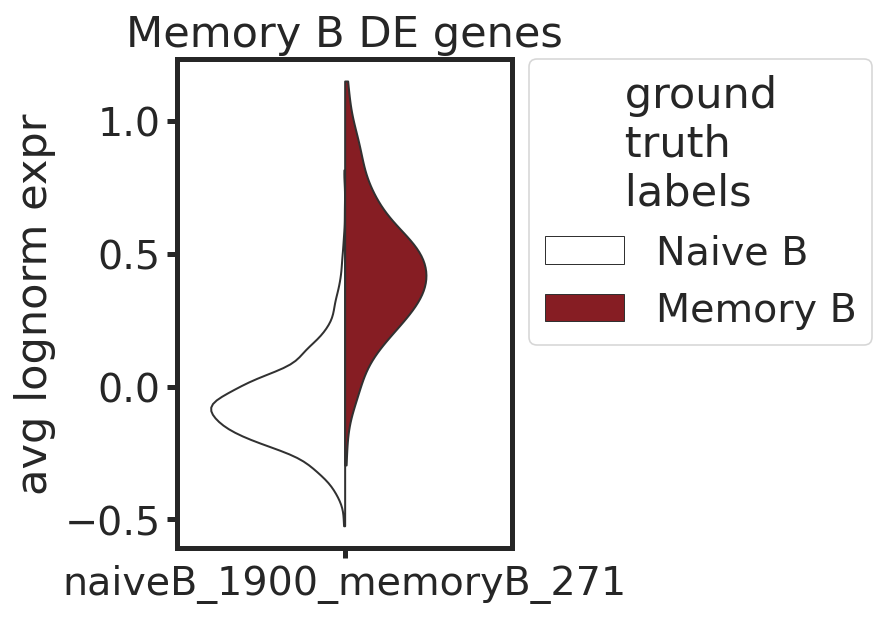

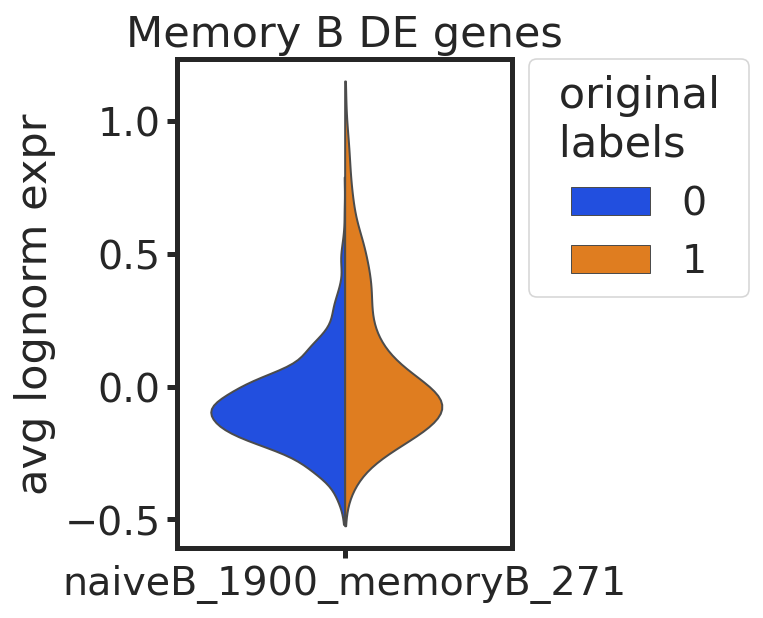

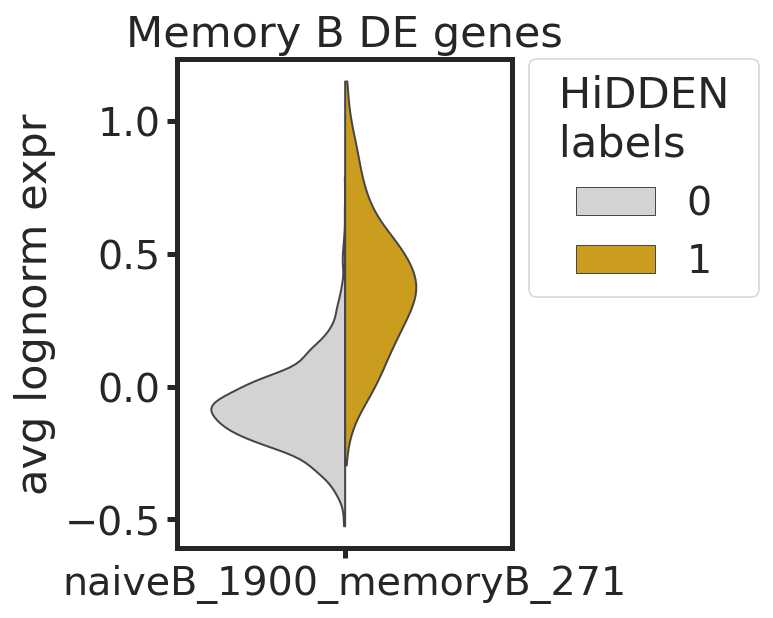

In [368]:
GENE_NAMES = MemoryB_groundt_DEs
GENE_SIG_NAME = 'Memory B'

plot_avg_gene_signature(GENE_NAMES, GENE_SIG_NAME)

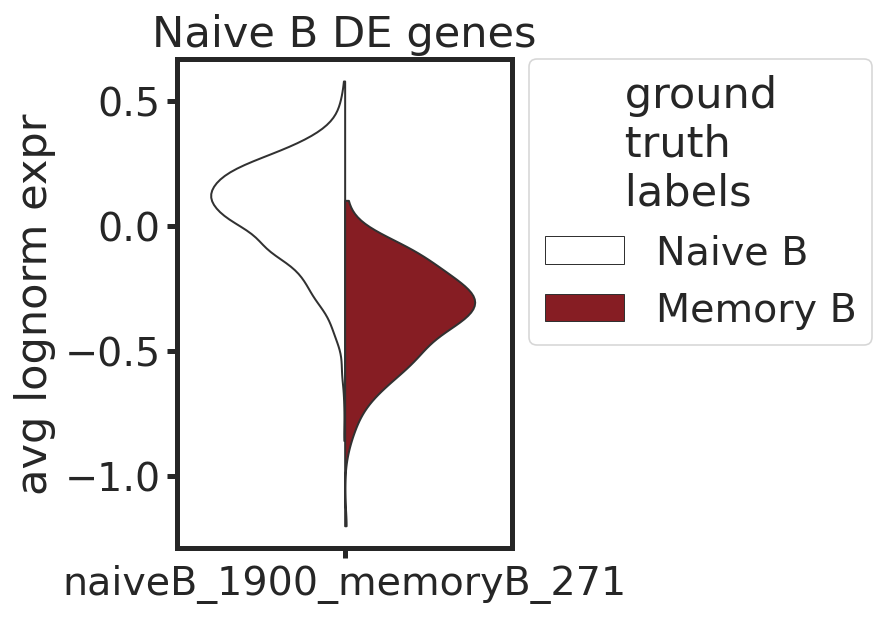

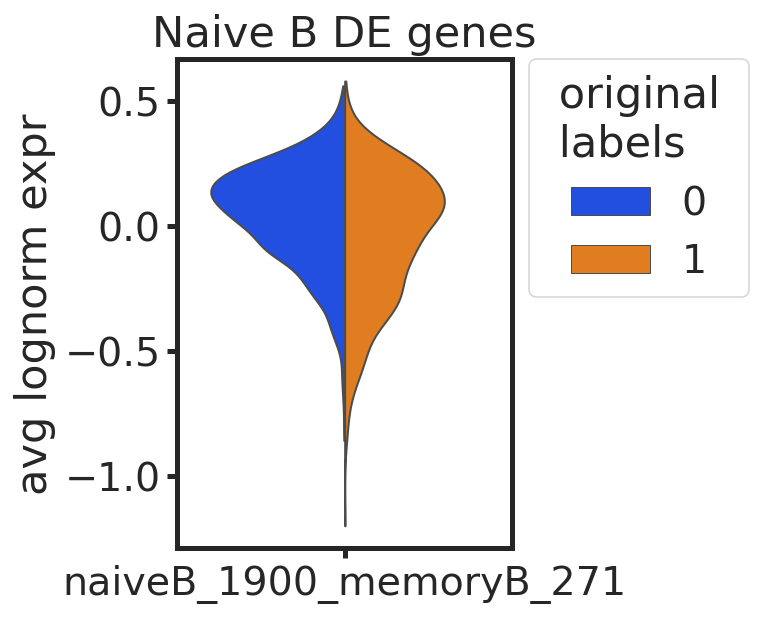

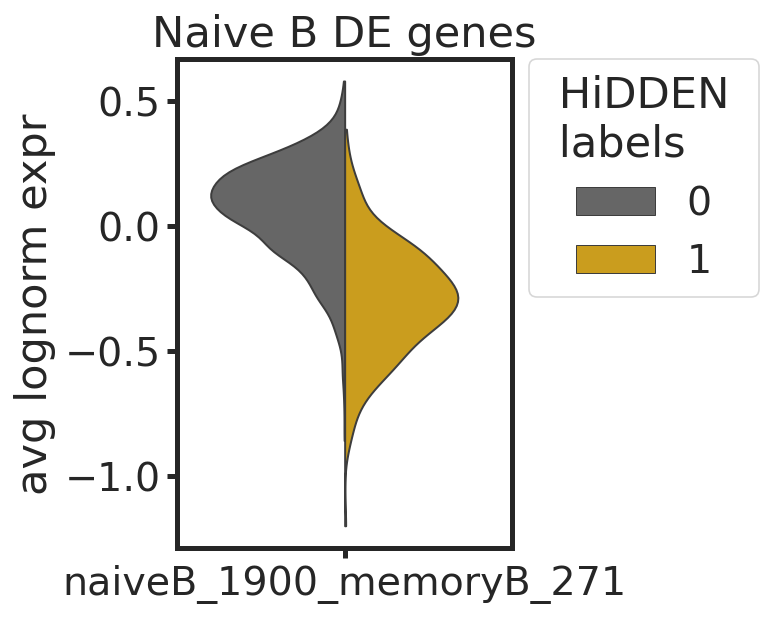

In [362]:
GENE_NAMES = NaiveB_groundt_DEs
GENE_SIG_NAME = 'Naive B'

plot_avg_gene_signature(GENE_NAMES, GENE_SIG_NAME)

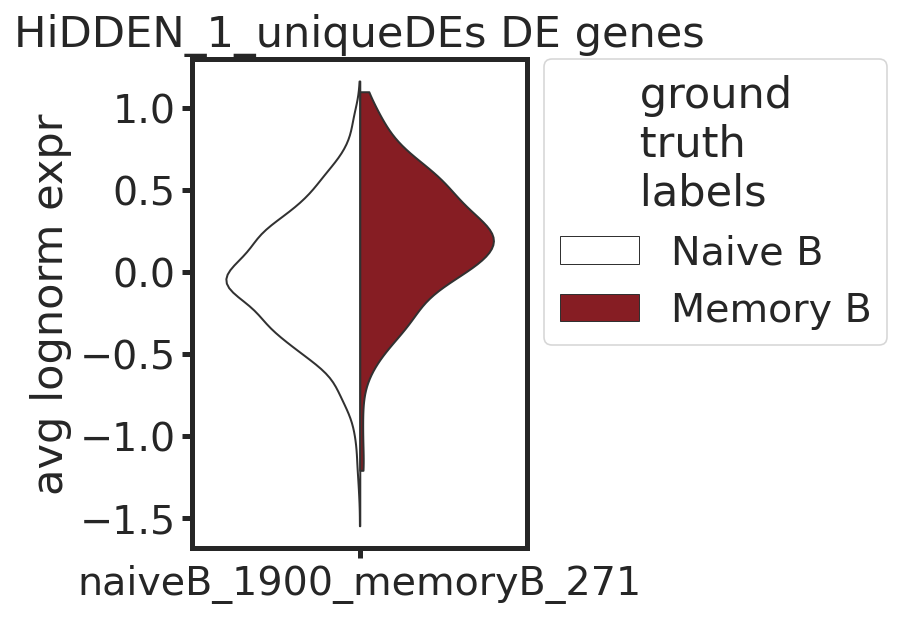

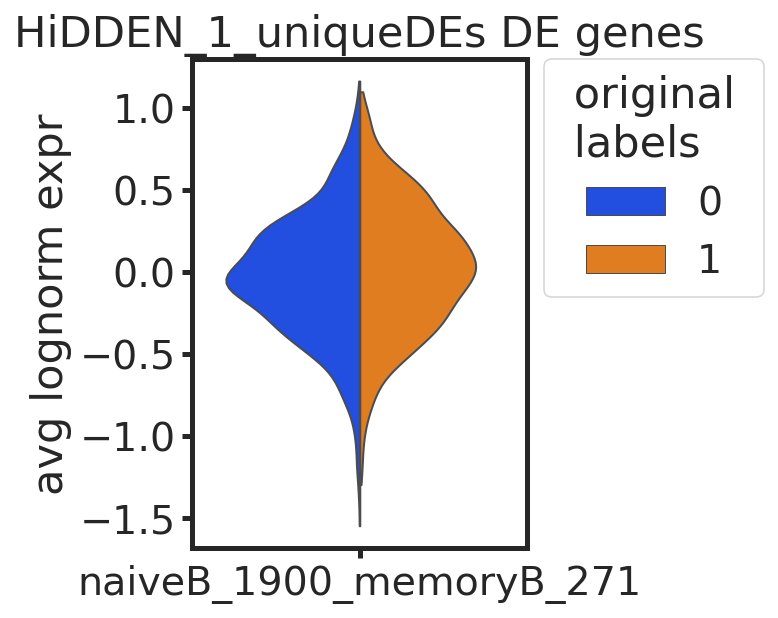

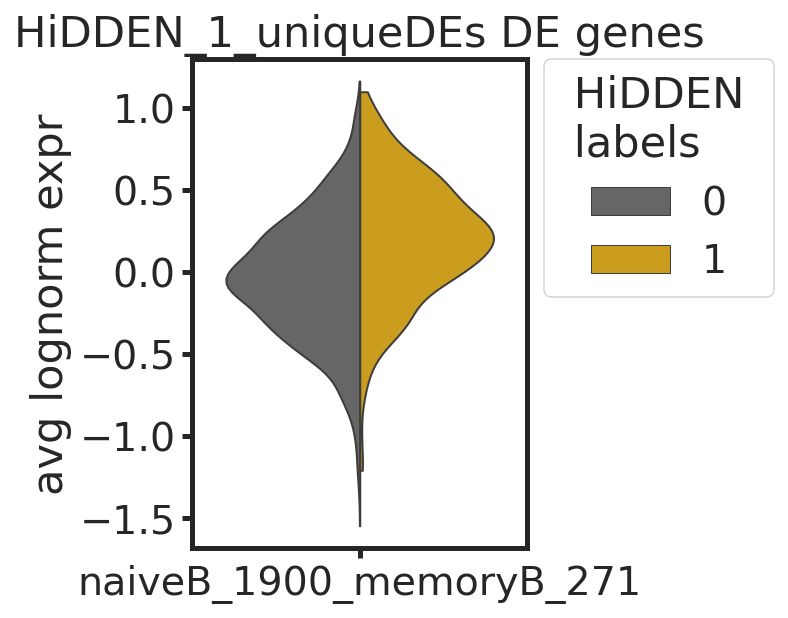

In [365]:
GENE_NAMES = HiDDEN_1_uniqueDEs
GENE_SIG_NAME = 'HiDDEN_1_uniqueDEs'

plot_avg_gene_signature(GENE_NAMES, GENE_SIG_NAME)

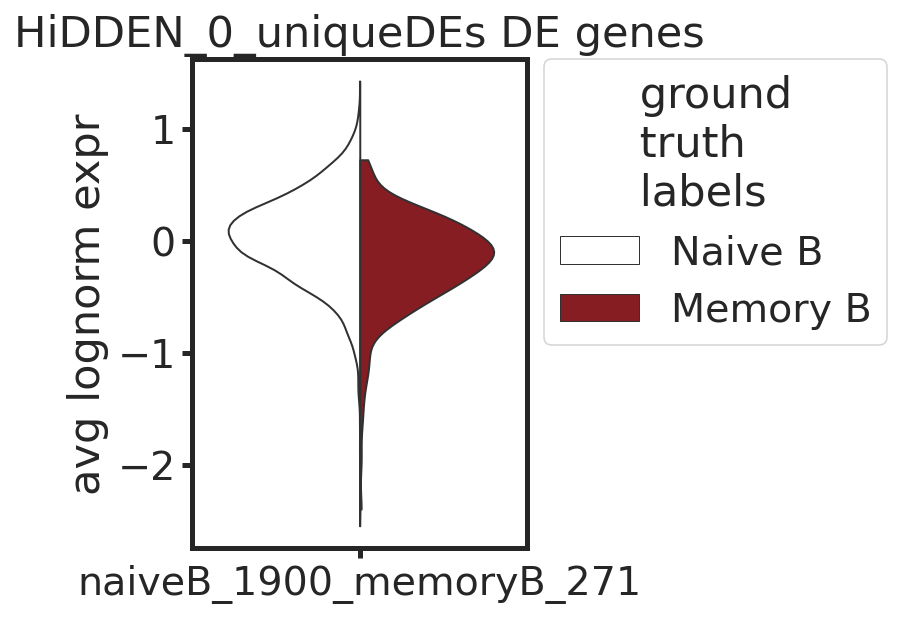

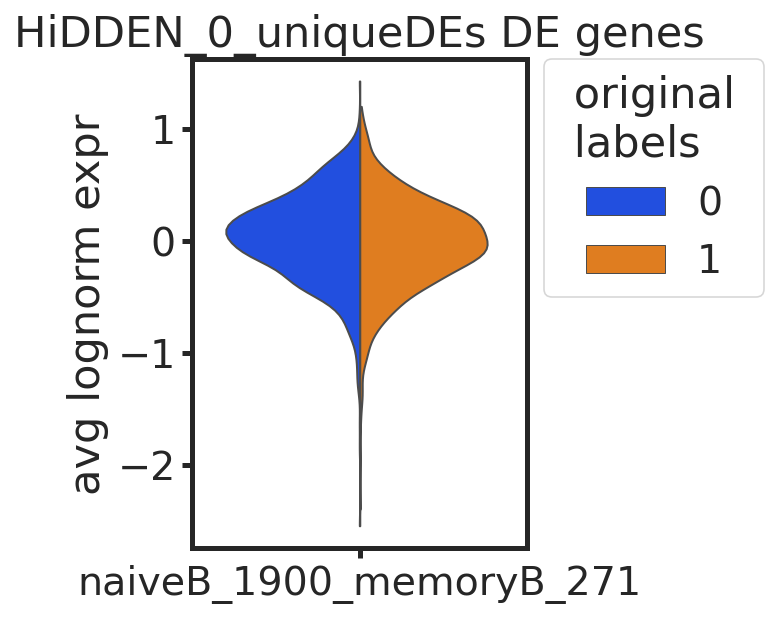

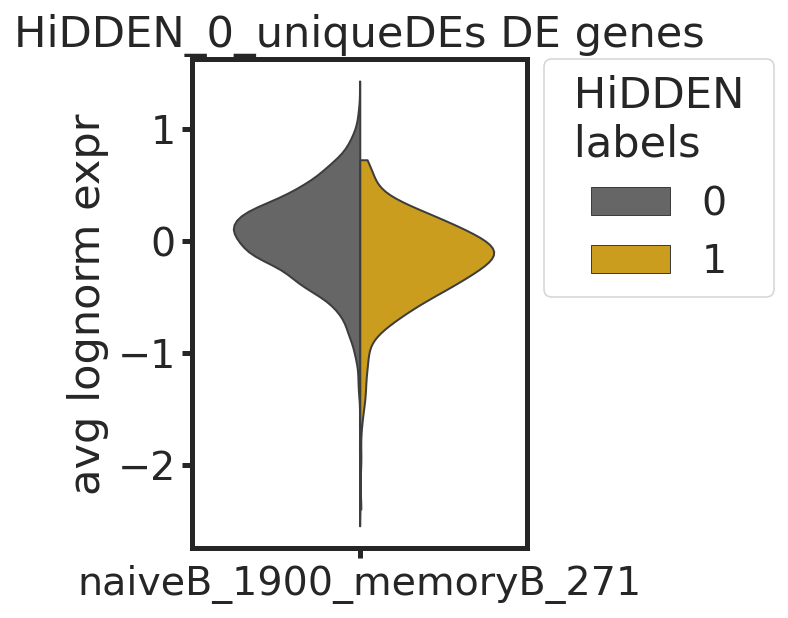

In [366]:
GENE_NAMES = HiDDEN_0_uniqueDEs
GENE_SIG_NAME = 'HiDDEN_0_uniqueDEs'

plot_avg_gene_signature(GENE_NAMES, GENE_SIG_NAME)

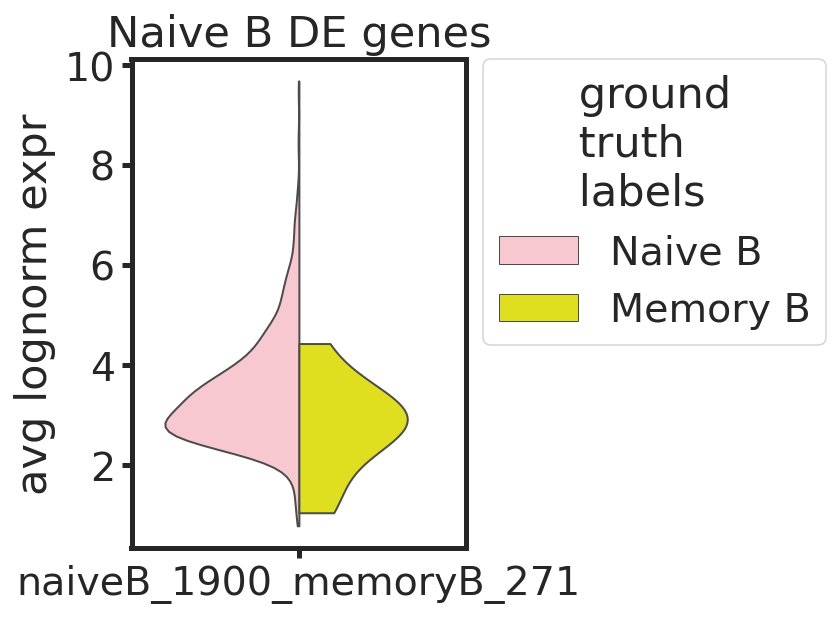

In [353]:
#GENE_NAMES = MemoryB_groundt_DEs
#GENE_SIG_NAME = 'Memory B'

GENE_NAMES = NaiveB_groundt_DEs
GENE_SIG_NAME = 'Naive B'

gene_names_df = pd.DataFrame(adata_work.var['gene_ids'])
gene_names_df['idx'] = np.array(range(adata_work.X.shape[1]))
gene_idxs = gene_names_df['idx'][GENE_NAMES].values

adata_hidden0 = adata_work[adata_work.obs['new_labels'].isin([0])]
sc.pp.normalize_total(adata_hidden0, target_sum=1e4)
sc.pp.log1p(adata_hidden0)
signature_df = pd.DataFrame(adata_hidden0.X[:, gene_idxs]) 
signature_df.columns = GENE_NAMES
plot_df = pd.DataFrame(data=signature_df.mean(axis=1), columns=['genes_signature'])
plot_df['perturbed'] = adata_hidden0.obs['perturbed'].values
plot_df['batch'] = adata_hidden0.obs['batch'].values
plot_df['new_labels'] = adata_hidden0.obs['new_labels'].values
plot_df['dataset'] = f'{orig_or_hybrid}'

plt.figure(figsize=(3, 4.5))
sns.violinplot(data=plot_df, x='dataset', y='genes_signature', hue="perturbed", split=True, linewidth=1, #scale='count', 
               cut=0, inner=None, scale_hue=False, hue_order=['Naive B', 'Memory B'], palette=['pink', 'yellow']) 
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0, title=' ground \n truth \n labels')
#plt.xticks([])
plt.xlabel("")
plt.ylabel("avg lognorm expr")
plt.title(f'{GENE_SIG_NAME} DE genes')
plt.savefig(f'{output_path}/split_violin_gene_sig_adata_hidden0_{GENE_SIG_NAME}.png', dpi=300, transparent=True, bbox_inches='tight')
plt.savefig(f'{output_path}/split_violin_gene_sig_adata_hidden0_{GENE_SIG_NAME}.svg', transparent=True, bbox_inches='tight')
plt.savefig(f'{output_path}/split_violin_gene_sig_adata_hidden0_{GENE_SIG_NAME}.pdf', transparent=True, bbox_inches='tight')
plt.show()

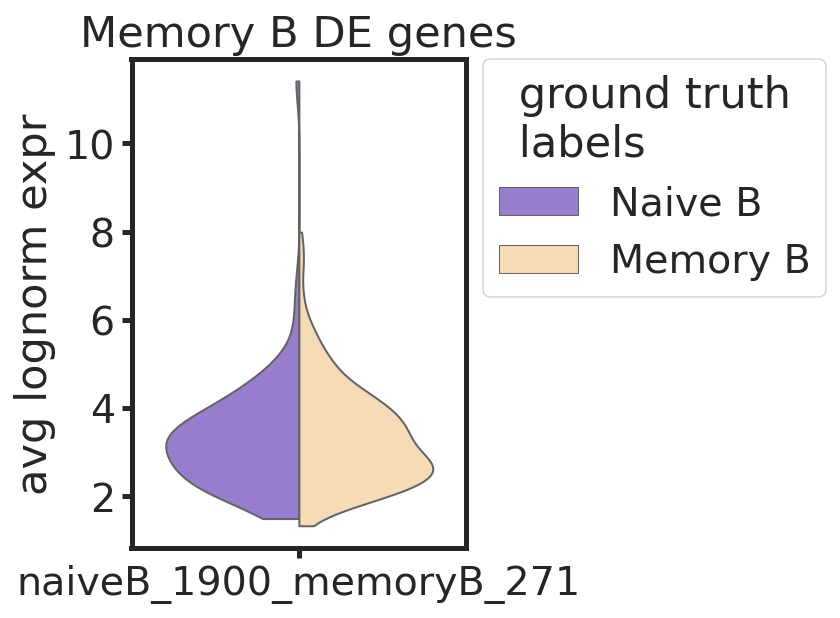

In [354]:
GENE_NAMES = MemoryB_groundt_DEs
GENE_SIG_NAME = 'Memory B'

gene_names_df = pd.DataFrame(adata_work.var['gene_ids'])
gene_names_df['idx'] = np.array(range(adata_work.X.shape[1]))
gene_idxs = gene_names_df['idx'][GENE_NAMES].values

adata_hidden1 = adata_work[adata_work.obs['new_labels'].isin([1])]
sc.pp.normalize_total(adata_hidden1, target_sum=1e4)
sc.pp.log1p(adata_hidden1)
signature_df = pd.DataFrame(adata_hidden1.X[:, gene_idxs]) 
signature_df.columns = GENE_NAMES
plot_df = pd.DataFrame(data=signature_df.mean(axis=1), columns=['genes_signature'])
plot_df['perturbed'] = adata_hidden1.obs['perturbed'].values
plot_df['batch'] = adata_hidden1.obs['batch'].values
plot_df['new_labels'] = adata_hidden1.obs['new_labels'].values
plot_df['dataset'] = f'{orig_or_hybrid}'

plt.figure(figsize=(3, 4.5))
sns.violinplot(data=plot_df, x='dataset', y='genes_signature', hue="perturbed", split=True, linewidth=1, #scale='count', 
               cut=0, inner=None, scale_hue=False, hue_order=['Naive B', 'Memory B'], palette=['mediumpurple', 'navajowhite']) 
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0, title=' ground truth \n labels')
#plt.xticks([])
plt.xlabel("")
plt.ylabel("avg lognorm expr")
plt.title(f'{GENE_SIG_NAME} DE genes')
plt.savefig(f'{output_path}/split_violin_gene_sig_adata_hidden1_{GENE_SIG_NAME}.png', dpi=300, transparent=True, bbox_inches='tight')
plt.savefig(f'{output_path}/split_violin_gene_sig_adata_hidden1_{GENE_SIG_NAME}.svg', transparent=True, bbox_inches='tight')
plt.savefig(f'{output_path}/split_violin_gene_sig_adata_hidden1_{GENE_SIG_NAME}.pdf', transparent=True, bbox_inches='tight')
plt.show()

In [160]:
output_path

'figures/naiveB_1900_memoryB_154/'

In [161]:
fname = f'{output_path}/DE_results.npz'
adict = {'naive_DEs':NaiveB_groundt_DEs,
         'memory_DEs':MemoryB_groundt_DEs,
         'control_DEs':control_orig_DEs,
         'case_DEs':case_orig_DEs,
         'HiDDEN_0_DEs':new0_DEs,
         'HiDDEN_1_DEs':new1_DEs}
np.savez_compressed(fname, **adict)

## Precison, Recall, F1 score for ground truth DE genes

In [162]:
def helper_precision_recall_fdr_f1(t_p, f_p, f_n):
    
    if (t_p + f_p)==0:
        precision = np.nan
        fdr = np.nan
    else:
        precision = t_p/(t_p + f_p)
        fdr = f_p/(f_p + t_p)
        
    recall = t_p/(t_p + f_n)
    if (precision + recall)==0 or (precision + recall)==np.nan:
        f1_score = np.nan
    else :
        f1_score = 2*precision*recall/(precision + recall)
        
    return precision, recall, fdr, f1_score

In [163]:
def compute_DE_precision_recall_fdr_f1(fname_read):#, fname_save):
    
    data = np.load(fname_read)
    data = {k:data[k] for k in data.keys()}
    
    if len(np.concatenate((data['naive_DEs'], data['memory_DEs'])))==0:
        print("There are 0 ground truth DE genes!")
        precision_orig, recall_orig, fdr_orig, f1_score_orig, precision_new, recall_new, fdr_new, f1_score_new = np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan
    else:
        t_p_orig = np.intersect1d(np.concatenate((data['naive_DEs'], data['memory_DEs'])), np.concatenate((data['control_DEs'], data['case_DEs']))).shape[0]
        f_n_orig = np.setdiff1d(np.concatenate((data['naive_DEs'], data['memory_DEs'])), np.concatenate((data['control_DEs'], data['case_DEs']))).shape[0]
        f_p_orig = np.setdiff1d(np.concatenate((data['control_DEs'], data['case_DEs'])), np.concatenate((data['naive_DEs'], data['memory_DEs']))).shape[0]
        precision_orig, recall_orig, fdr_orig, f1_score_orig = helper_precision_recall_fdr_f1(t_p_orig, f_p_orig, f_n_orig)

        t_p_new = np.intersect1d(np.concatenate((data['naive_DEs'], data['memory_DEs'])), np.concatenate((data['HiDDEN_0_DEs'], data['HiDDEN_1_DEs']))).shape[0]
        f_n_new = np.setdiff1d(np.concatenate((data['naive_DEs'], data['memory_DEs'])), np.concatenate((data['HiDDEN_0_DEs'], data['HiDDEN_1_DEs']))).shape[0]
        f_p_new = np.setdiff1d(np.concatenate((data['HiDDEN_0_DEs'], data['HiDDEN_1_DEs'])), np.concatenate((data['naive_DEs'], data['memory_DEs']))).shape[0]

        precision_new, recall_new, fdr_new, f1_score_new = helper_precision_recall_fdr_f1(t_p_new, f_p_new, f_n_new)
    
    #adct = {'t_p':t_p, 'f_n':f_n, 'f_p':f_p, 'recall':recall}
    #np.savez_compressed(fname_save, **adct)
    
    return precision_orig, recall_orig, fdr_orig, f1_score_orig, precision_new, recall_new, fdr_new, f1_score_new

In [165]:
precision_orig, recall_orig, fdr_orig, f1_score_orig, precision_new, recall_new, fdr_new, f1_score_new = compute_DE_precision_recall_fdr_f1(f'{output_path}/DE_results.npz')
print(recall_orig, recall_new)

0.0 0.8260869565217391


In [246]:
#f'{output_path}/DE_results.npz'

In [247]:
#output_path = f'figures/naiveB_1900_memoryB_49/'
#fname = f'{output_path}/DE_results.npz'
#precision_orig, recall_orig, fdr_orig, f1_score_orig, precision_new, recall_new, fdr_new, f1_score_new = compute_DE_precision_recall_fdr_f1(fname)
#precision_vec_orig, recall_vec_orig, fdr_vec_orig, f1_vec_orig, precision_vec_new, recall_vec_new, fdr_vec_new, f1_vec_new = get_plotting_vecs_precision_recall_fdr_f1(precision_orig, recall_orig, fdr_orig, f1_score_orig, precision_new, recall_new, fdr_new, f1_score_new)
#print(recall_vec_orig, recall_vec_new)

In [248]:
orig_or_hybrid

'naiveB_1900_memoryB_49 hybrid 0.25'

## Ablation plots

In [90]:
adata

AnnData object with n_obs × n_vars = 1949 × 17009
    obs: 'barcodes', 'n_genes', 'percent_mito', 'n_counts', 'leiden', 'batch', 'perturbed'
    var: 'gene_ids', 'mean', 'std'
    uns: 'leiden', 'neighbors', 'pca', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'lognorm', 'counts', 'counts_0.75', 'counts_0.5', 'counts_0.25'
    obsp: 'connectivities', 'distances'

In [91]:
adata.write_h5ad(f'figures/{PUCK_NUMBER}/adata.h5ad')

... storing 'batch' as categorical
... storing 'perturbed' as categorical


In [186]:
def get_plotting_vecs_precision_recall_fdr_f1(precision_orig, recall_orig, fdr_orig, f1_score_orig, precision_new, recall_new, fdr_new, f1_score_new):
    
    precision_orig, recall_orig, fdr_orig, f1_score_orig, precision_new, recall_new, fdr_new, f1_score_new = compute_DE_precision_recall_fdr_f1(fname)
    precision_vec_orig.append(precision_orig)
    recall_vec_orig.append(recall_orig)
    fdr_vec_orig.append(fdr_orig)
    f1_vec_orig.append(f1_score_orig)
    precision_vec_new.append(precision_new)
    recall_vec_new.append(recall_new)
    fdr_vec_new.append(fdr_new)
    f1_vec_new.append(f1_score_new)

    return precision_vec_orig, recall_vec_orig, fdr_vec_orig, f1_vec_orig, precision_vec_new, recall_vec_new, fdr_vec_new, f1_vec_new

In [187]:
precision_vec_orig = []
recall_vec_orig = []
fdr_vec_orig = []
f1_vec_orig = []
precision_vec_new = []
recall_vec_new = []
fdr_vec_new = []
f1_vec_new = []

fname = f'figures/{PUCK_NUMBER} hybrid 0.25/DE_results.npz'
precision_orig, recall_orig, fdr_orig, f1_score_orig, precision_new, recall_new, fdr_new, f1_score_new = compute_DE_precision_recall_fdr_f1(fname)
precision_vec_orig, recall_vec_orig, fdr_vec_orig, f1_vec_orig, precision_vec_new, recall_vec_new, fdr_vec_new, f1_vec_new = get_plotting_vecs_precision_recall_fdr_f1(precision_orig, recall_orig, fdr_orig, f1_score_orig, precision_new, recall_new, fdr_new, f1_score_new)

fname = f'figures/{PUCK_NUMBER} hybrid 0.5/DE_results.npz'
precision_orig, recall_orig, fdr_orig, f1_score_orig, precision_new, recall_new, fdr_new, f1_score_new = compute_DE_precision_recall_fdr_f1(fname)
precision_vec_orig, recall_vec_orig, fdr_vec_orig, f1_vec_orig, precision_vec_new, recall_vec_new, fdr_vec_new, f1_vec_new = get_plotting_vecs_precision_recall_fdr_f1(precision_orig, recall_orig, fdr_orig, f1_score_orig, precision_new, recall_new, fdr_new, f1_score_new)

fname = f'figures/{PUCK_NUMBER} hybrid 0.75/DE_results.npz'
precision_orig, recall_orig, fdr_orig, f1_score_orig, precision_new, recall_new, fdr_new, f1_score_new = compute_DE_precision_recall_fdr_f1(fname)
precision_vec_orig, recall_vec_orig, fdr_vec_orig, f1_vec_orig, precision_vec_new, recall_vec_new, fdr_vec_new, f1_vec_new = get_plotting_vecs_precision_recall_fdr_f1(precision_orig, recall_orig, fdr_orig, f1_score_orig, precision_new, recall_new, fdr_new, f1_score_new)

fname = f'figures/{PUCK_NUMBER}/DE_results.npz' # 100% Mem B
precision_orig, recall_orig, fdr_orig, f1_score_orig, precision_new, recall_new, fdr_new, f1_score_new = compute_DE_precision_recall_fdr_f1(fname)
precision_vec_orig, recall_vec_orig, fdr_vec_orig, f1_vec_orig, precision_vec_new, recall_vec_new, fdr_vec_new, f1_vec_new = get_plotting_vecs_precision_recall_fdr_f1(precision_orig, recall_orig, fdr_orig, f1_score_orig, precision_new, recall_new, fdr_new, f1_score_new)

plotting_precision_DE_dict_orig = {f"{PUCK_NUMBER} baseline" : precision_vec_orig}
plotting_recall_DE_dict_orig = {f"{PUCK_NUMBER} baseline" : recall_vec_orig}
plotting_fdr_DE_dict_orig = {f"{PUCK_NUMBER} baseline" : fdr_vec_orig}
plotting_f1_DE_dict_orig = {f"{PUCK_NUMBER} baseline" : f1_vec_orig}
plotting_precision_DE_dict_new = {f"{PUCK_NUMBER} HiDDEN" : precision_vec_new}
plotting_recall_DE_dict_new = {f"{PUCK_NUMBER} HiDDEN" : recall_vec_new}
plotting_fdr_DE_dict_new = {f"{PUCK_NUMBER} HiDDEN" : fdr_vec_new}
plotting_f1_DE_dict_new = {f"{PUCK_NUMBER} HiDDEN" : f1_vec_new}

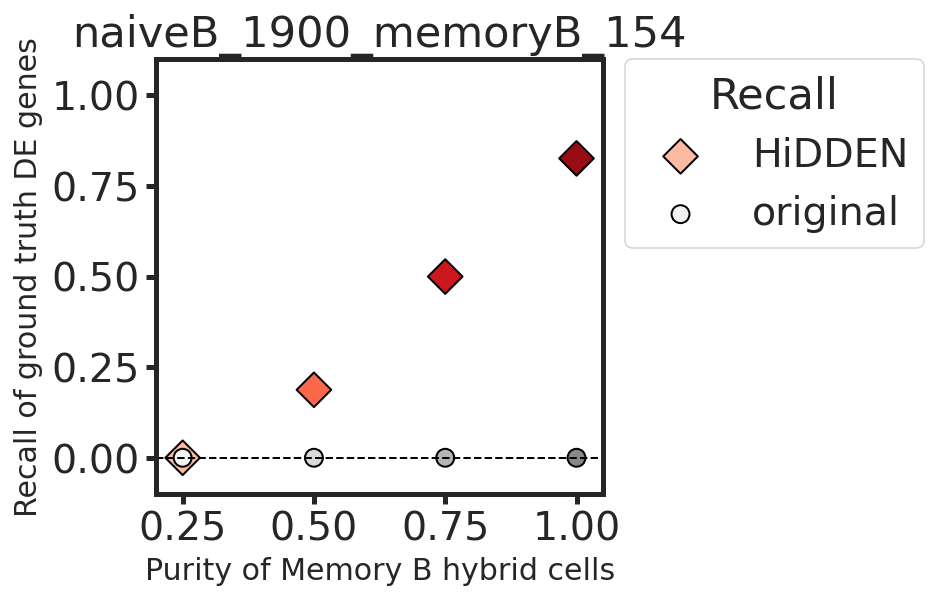

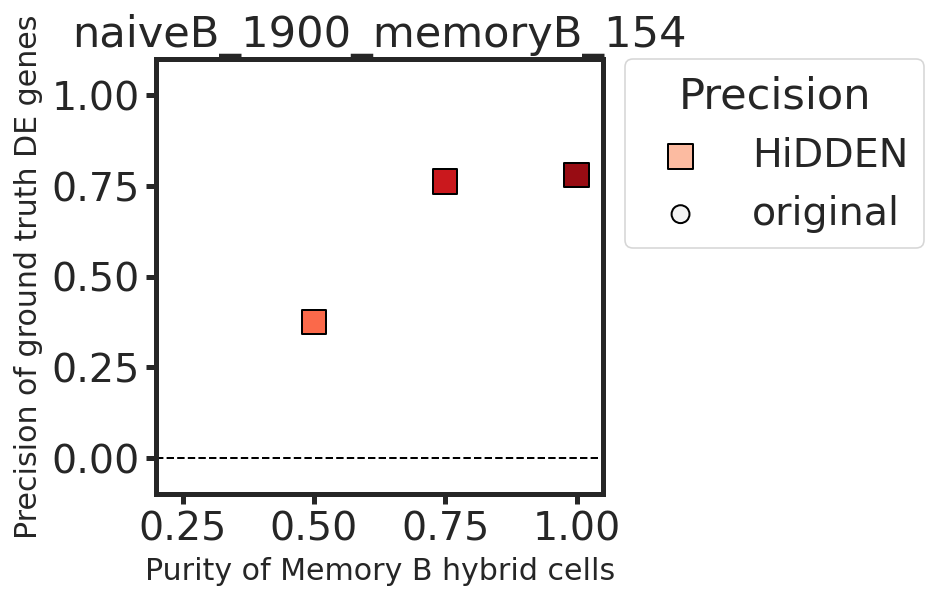

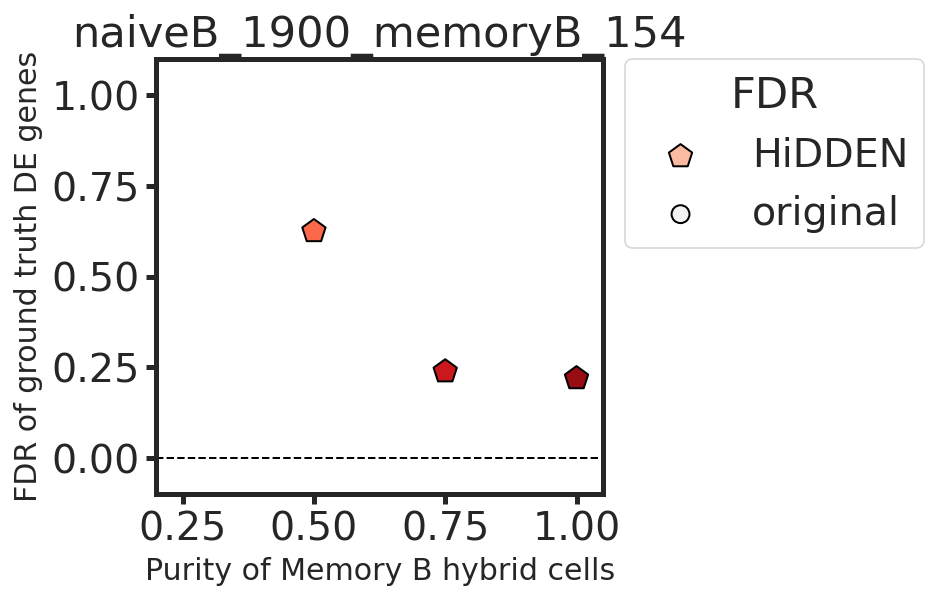

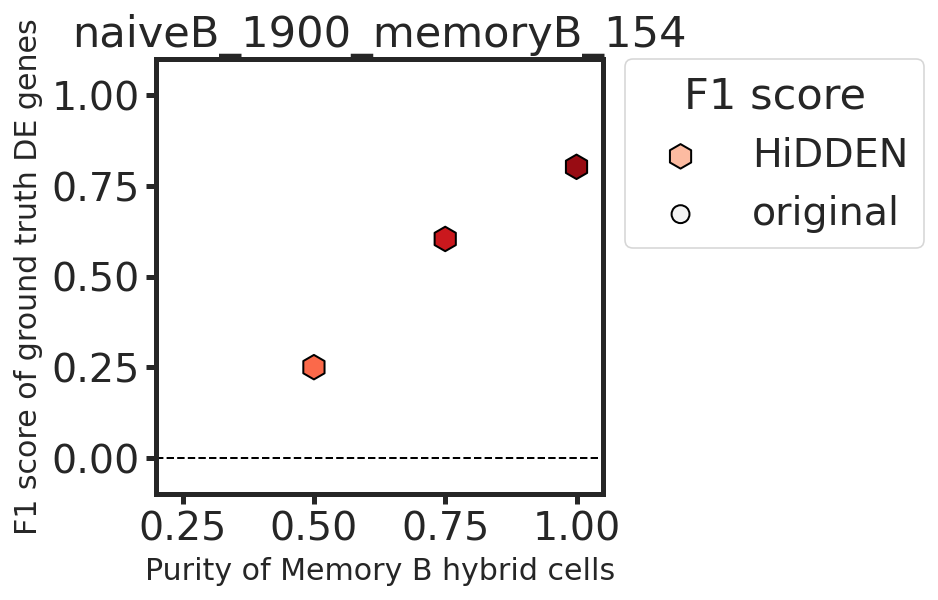

In [188]:
hidden_cols = [reds_palette(0.25), reds_palette(0.5), reds_palette(0.75), reds_palette(0.9)]
orig_cols = [greys_palette(0.1), greys_palette(0.25), greys_palette(0.4), greys_palette(0.55)]

plt.figure(figsize=(4, 4))
plt.scatter(x=[0.25, 0.5, 0.75, 1], y=plotting_recall_DE_dict_new[f'{PUCK_NUMBER} HiDDEN'], marker='D', c=hidden_cols, alpha=1, edgecolors='k', s=150, linewidths=1)
plt.scatter(x=[0.25, 0.5, 0.75, 1], y=plotting_recall_DE_dict_orig[f'{PUCK_NUMBER} baseline'], c=orig_cols, alpha=1, edgecolors='k', s=80, linewidths=1)
plt.legend(['HiDDEN', 'original'], bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0, title='Recall')
plt.xlabel('Purity of Memory B hybrid cells', fontsize=15)
plt.ylabel('Recall of ground truth DE genes', fontsize=15)
plt.xticks([0.25, 0.5, 0.75, 1])
plt.xlim([0.20, 1.05])
plt.ylim([-0.1, 1.1])
plt.title(f'{PUCK_NUMBER}')
plt.axhline(y = 0.0, color = 'k', linestyle = '--', linewidth=1)
plt.savefig(f'figures/ablation/{PUCK_NUMBER}_recall_groundtruthDEgenes.png', dpi=300, transparent=True, bbox_inches='tight')
plt.savefig(f'figures/ablation/{PUCK_NUMBER}_recall_groundtruthDEgenes.svg', transparent=True, bbox_inches='tight')
plt.savefig(f'figures/ablation/{PUCK_NUMBER}_recall_groundtruthDEgenes.pdf', transparent=True, bbox_inches='tight')
plt.show()

plt.figure(figsize=(4, 4))
plt.scatter(x=[0.25, 0.5, 0.75, 1], y=plotting_precision_DE_dict_new[f'{PUCK_NUMBER} HiDDEN'], marker='s', c=hidden_cols, alpha=1, edgecolors='k', s=150, linewidths=1)
plt.scatter(x=[0.25, 0.5, 0.75, 1], y=plotting_precision_DE_dict_orig[f'{PUCK_NUMBER} baseline'], c=orig_cols, alpha=1, edgecolors='k', s=80, linewidths=1)
plt.xlabel('Purity of Memory B hybrid cells', fontsize=15)
plt.ylabel('Precision of ground truth DE genes', fontsize=15)
plt.xticks([0.25, 0.5, 0.75, 1])
plt.xlim([0.20, 1.05])
plt.ylim([-0.1, 1.1])
plt.title(f'{PUCK_NUMBER}')
plt.legend(['HiDDEN', 'original'], bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0, title='Precision')
plt.axhline(y = 0.0, color = 'k', linestyle = '--', linewidth=1)
plt.savefig(f'figures/ablation/{PUCK_NUMBER}_precision_groundtruthDEgenes.png', dpi=300, transparent=True, bbox_inches='tight')
plt.savefig(f'figures/ablation/{PUCK_NUMBER}_precision_groundtruthDEgenes.svg', transparent=True, bbox_inches='tight')
plt.savefig(f'figures/ablation/{PUCK_NUMBER}_precision_groundtruthDEgenes.pdf', transparent=True, bbox_inches='tight')
plt.show()

plt.figure(figsize=(4, 4))
plt.scatter(x=[0.25, 0.5, 0.75, 1], y=plotting_fdr_DE_dict_new[f'{PUCK_NUMBER} HiDDEN'], marker='p', c=hidden_cols, alpha=1, edgecolors='k', s=150, linewidths=1)
plt.scatter(x=[0.25, 0.5, 0.75, 1], y=plotting_fdr_DE_dict_orig[f'{PUCK_NUMBER} baseline'], c=orig_cols, alpha=1, edgecolors='k', s=80, linewidths=1)
plt.xlabel('Purity of Memory B hybrid cells', fontsize=15)
plt.ylabel('FDR of ground truth DE genes', fontsize=15)
plt.xticks([0.25, 0.5, 0.75, 1])
plt.xlim([0.20, 1.05])
plt.ylim([-0.1, 1.1])
plt.title(f'{PUCK_NUMBER}')
plt.legend(['HiDDEN', 'original'], bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0, title='FDR')
plt.axhline(y = 0.0, color = 'k', linestyle = '--', linewidth=1)
plt.savefig(f'figures/ablation/{PUCK_NUMBER}_fdr_groundtruthDEgenes.png', dpi=300, transparent=True, bbox_inches='tight')
plt.savefig(f'figures/ablation/{PUCK_NUMBER}_fdr_groundtruthDEgenes.svg', transparent=True, bbox_inches='tight')
plt.savefig(f'figures/ablation/{PUCK_NUMBER}_fdr_groundtruthDEgenes.pdf', transparent=True, bbox_inches='tight')
plt.show()

plt.figure(figsize=(4, 4))
plt.scatter(x=[0.25, 0.5, 0.75, 1], y=plotting_f1_DE_dict_new[f'{PUCK_NUMBER} HiDDEN'], marker='h', c=hidden_cols, alpha=1, edgecolors='k', s=150, linewidths=1)
plt.scatter(x=[0.25, 0.5, 0.75, 1], y=plotting_f1_DE_dict_orig[f'{PUCK_NUMBER} baseline'], c=orig_cols, alpha=1, edgecolors='k', s=80, linewidths=1)
plt.xlabel('Purity of Memory B hybrid cells', fontsize=15)
plt.ylabel('F1 score of ground truth DE genes', fontsize=15)
plt.xticks([0.25, 0.5, 0.75, 1])
plt.xlim([0.20, 1.05])
plt.ylim([-0.1, 1.1])
plt.title(f'{PUCK_NUMBER}')
plt.legend(['HiDDEN', 'original'], bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0, title='F1 score')
plt.axhline(y = 0.0, color = 'k', linestyle = '--', linewidth=1)
plt.savefig(f'figures/ablation/{PUCK_NUMBER}_f1_groundtruthDEgenes.png', dpi=300, transparent=True, bbox_inches='tight')
plt.savefig(f'figures/ablation/{PUCK_NUMBER}_f1_groundtruthDEgenes.svg', transparent=True, bbox_inches='tight')
plt.savefig(f'figures/ablation/{PUCK_NUMBER}_f1_groundtruthDEgenes.pdf', transparent=True, bbox_inches='tight')
plt.show()

In [217]:
mutual_information_dict = dict(np.load('figures/ablation/mutual_information_dict.npz'))
#mutual_information_dict[f'{title_str}'] = [sklearn.metrics.mutual_info_score(adata_work.obs['perturbed'], adata_work.obs['new_labels']), 
#                                           sklearn.metrics.mutual_info_score(adata_work.obs['perturbed'], adata_work.obs['batch']), 
#                                           sklearn.metrics.mutual_info_score(adata_work.obs['perturbed'], adata_work.obs['perturbed'])]

In [218]:
mutual_info_vec_orig = []
mutual_info_vec_new = []
mutual_info_vec_75_new = []
mutual_info_vec_50_new = []
mutual_info_vec_25_new = []

for NUM_MEMB in tqdm(['154']):
    
    PUCK_SUBNUMBER = 'naiveB_1900'
    PUCK_NUMBER = f'{PUCK_SUBNUMBER}_memoryB_{NUM_MEMB}'
    #adata = sc.read(f'figures/{PUCK_NUMBER}/adata.h5ad')
    
    W_m = 1
    NUM_PCS = optimal_NUM_PCS_dict[f'{PUCK_NUMBER} hybrid {W_m}'] if W_m!=1 else optimal_NUM_PCS_dict[f'{PUCK_NUMBER}']
    title_str = f'{PUCK_NUMBER} hybrid {W_m} {NUM_PCS} PCs' if W_m!=1 else f'{PUCK_NUMBER} {NUM_PCS} PCs'
    mutual_info_vec_orig.append(mutual_information_dict[f'{title_str}'][1]/mutual_information_dict[f'{title_str}'][2])
    mutual_info_vec_new.append(mutual_information_dict[f'{title_str}'][0]/mutual_information_dict[f'{title_str}'][2])
    
    W_m = 0.75
    NUM_PCS = optimal_NUM_PCS_dict[f'{PUCK_NUMBER} hybrid {W_m}'] if W_m!=1 else optimal_NUM_PCS_dict[f'{PUCK_NUMBER}']
    title_str = f'{PUCK_NUMBER} hybrid {W_m} {NUM_PCS} PCs' if W_m!=1 else f'{PUCK_NUMBER} {NUM_PCS} PCs'
    mutual_info_vec_75_new.append(mutual_information_dict[f'{title_str}'][0]/mutual_information_dict[f'{title_str}'][2])
    
    W_m = 0.5
    NUM_PCS = optimal_NUM_PCS_dict[f'{PUCK_NUMBER} hybrid {W_m}'] if W_m!=1 else optimal_NUM_PCS_dict[f'{PUCK_NUMBER}']
    title_str = f'{PUCK_NUMBER} hybrid {W_m} {NUM_PCS} PCs' if W_m!=1 else f'{PUCK_NUMBER} {NUM_PCS} PCs'
    mutual_info_vec_50_new.append(mutual_information_dict[f'{title_str}'][0]/mutual_information_dict[f'{title_str}'][2])
    
    W_m = 0.25
    NUM_PCS = optimal_NUM_PCS_dict[f'{PUCK_NUMBER} hybrid {W_m}'] if W_m!=1 else optimal_NUM_PCS_dict[f'{PUCK_NUMBER}']
    title_str = f'{PUCK_NUMBER} hybrid {W_m} {NUM_PCS} PCs' if W_m!=1 else f'{PUCK_NUMBER} {NUM_PCS} PCs'
    mutual_info_vec_25_new.append(mutual_information_dict[f'{title_str}'][0]/mutual_information_dict[f'{title_str}'][2])
    
print(mutual_info_vec_orig)
print(mutual_info_vec_new)
print(mutual_info_vec_75_new)
print(mutual_info_vec_50_new)
print(mutual_info_vec_25_new)

  0%|          | 0/1 [00:00<?, ?it/s]

[0.20655717221994754]
[0.49360100648386623]
[0.2721961784205432]
[0.17933721965699123]
[0.10210515687622655]


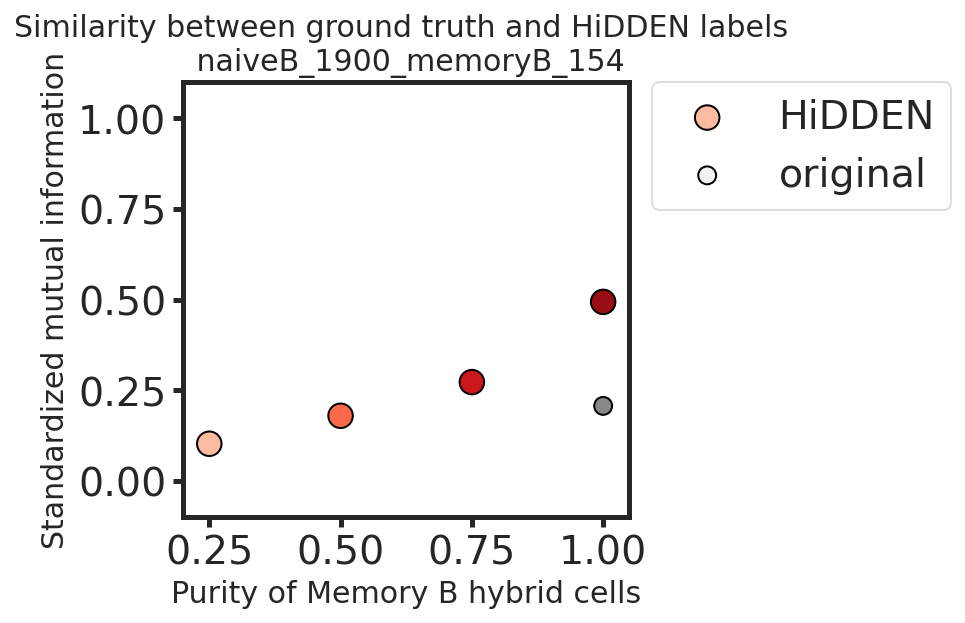

In [226]:
hidden_cols = [reds_palette(0.25), reds_palette(0.5), reds_palette(0.75), reds_palette(0.9)]
orig_cols = [greys_palette(0.1), greys_palette(0.25), greys_palette(0.4), greys_palette(0.55)]

plt.figure(figsize=(4, 4))
plt.scatter(x=[0.25, 0.5, 0.75, 1], y=[mutual_info_vec_25_new[0], mutual_info_vec_50_new[0], mutual_info_vec_75_new[0], mutual_info_vec_new[0]], c=hidden_cols, alpha=1, edgecolors='k', s=150, linewidths=1)
plt.scatter(x=[0.25, 0.5, 0.75, 1], y=[np.nan, np.nan, np.nan, mutual_info_vec_orig[0]], c=orig_cols, alpha=1, edgecolors='k', s=80, linewidths=1)
plt.legend(['HiDDEN', 'original'], bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
plt.xlabel('Purity of Memory B hybrid cells', fontsize=15)
plt.ylabel('Standardized mutual information', fontsize=15)
plt.xticks([0.25, 0.5, 0.75, 1])
plt.xlim([0.20, 1.05])
plt.ylim([-0.1, 1.1])
plt.title(f'Similarity between ground truth and HiDDEN labels \n {PUCK_NUMBER}', fontsize=15)
#plt.axhline(y = 0.0, color = 'k', linestyle = '--', linewidth=1)
plt.savefig(f'figures/ablation/{PUCK_NUMBER}_mutual_information.png', dpi=300, transparent=True, bbox_inches='tight')
plt.savefig(f'figures/ablation/{PUCK_NUMBER}_mutual_information.svg', transparent=True, bbox_inches='tight')
plt.savefig(f'figures/ablation/{PUCK_NUMBER}_mutual_information.pdf', transparent=True, bbox_inches='tight')
plt.show()

In [ ]:
plt.scatter(pct_memory_b_cells, mutual_info_vec_new, c=reds_palette(0.9), s=150, alpha=1, edgecolors='k', linewidths=1)
plt.scatter(pct_memory_b_cells, mutual_info_vec_orig, c='dimgray', s=80, alpha=1, edgecolors='k', linewidths=1)
plt.xlabel('Percent Memory B cells in case')
plt.ylabel('Standardized mutual information')
plt.ylim([-0.1, 1.1]) 
plt.title(f'Comparing ground truth labels to original and to HiDDEN labels')
plt.legend(['HiDDEN', 'original'], bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0, title='', handletextpad=0.2)
plt.savefig(f'figures/across_datasets/Mutual_information_HiDDEN_original.png', dpi=300, transparent=True, bbox_inches='tight')
plt.savefig(f'figures/across_datasets/Mutual_information_HiDDEN_original.svg', transparent=True, bbox_inches='tight')
plt.savefig(f'figures/across_datasets/Mutual_information_HiDDEN_original.pdf', transparent=True, bbox_inches='tight')
plt.show()

plt.scatter(pct_memory_b_cells, mutual_info_vec_new, c=reds_palette(0.9), s=150, alpha=1, edgecolors='k', linewidths=1)
plt.scatter(pct_memory_b_cells, mutual_info_vec_75_new, c=reds_palette(0.75), s=150, alpha=1, edgecolors='k', linewidths=1)
plt.scatter(pct_memory_b_cells, mutual_info_vec_50_new, c=reds_palette(0.5), s=150, alpha=1, edgecolors='k', linewidths=1)
plt.scatter(pct_memory_b_cells, mutual_info_vec_25_new, c=reds_palette(0.25), s=150, alpha=1, edgecolors='k', linewidths=1)
plt.xlabel('Percent Memory B cells in case')
plt.ylabel('Standardized mutual information')
plt.ylim([-0.1, 1.1]) 
plt.title(f'Similarity between ground truth and HiDDEN labels')
plt.legend(['1.0', '0.75', '0.5', '0.25'], bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0, 
           title=' Memory B \n purity in \n hybrid cells', handletextpad=0.2)
plt.savefig(f'figures/across_datasets/Mutual_information_HiDDEN_ablation.png', dpi=300, transparent=True, bbox_inches='tight')
plt.savefig(f'figures/across_datasets/Mutual_information_HiDDEN_ablation.svg', transparent=True, bbox_inches='tight')
plt.savefig(f'figures/across_datasets/Mutual_information_HiDDEN_ablation.pdf', transparent=True, bbox_inches='tight')
plt.show()

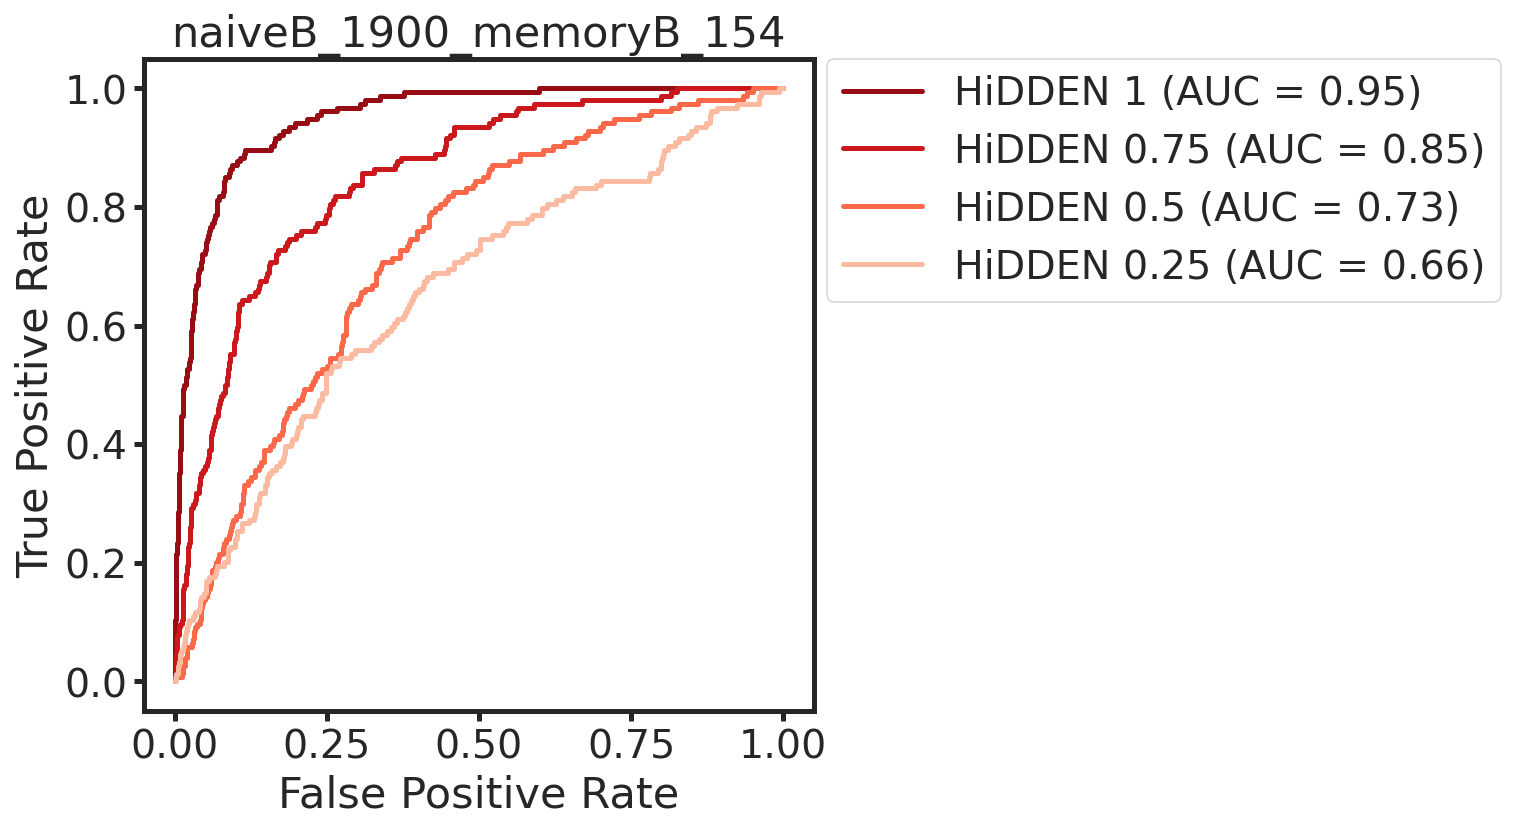

In [190]:
#optimal_NUM_PCS_dict = dict(np.load('figures/ablation/optimal_NUM_PCS_dict_ablation_dict.npz')) # old heuristic
optimal_NUM_PCS_dict = dict(np.load('figures/ablation/optimal_NUM_PCS_KS_dict.npz'))

fig = plt.figure(figsize=(6, 6))
ax = plt.gca()

W_m=1
opt_num_pcs = optimal_NUM_PCS_dict[f'{PUCK_NUMBER}']
y_true = pd.read_csv(f'figures/{PUCK_NUMBER}/ground_truth_{PUCK_NUMBER} {opt_num_pcs} PCs.csv')['perturbed'].values == 'Memory B'
y_pred = pd.read_csv(f'figures/{PUCK_NUMBER}/p_hat_{PUCK_NUMBER} {opt_num_pcs} PCs.csv')['p_hat'].values
plot_roc_curve(y_true, y_pred, name=f'HiDDEN {W_m}', color=reds_palette(W_m if W_m!=1 else 0.9), lw=2.5)

W_m = 0.75
opt_num_pcs = optimal_NUM_PCS_dict[f'{PUCK_NUMBER} hybrid {W_m}']
y_true = pd.read_csv(f'figures/{PUCK_NUMBER} hybrid {W_m}/ground_truth_{PUCK_NUMBER} hybrid {W_m} {opt_num_pcs} PCs.csv')['perturbed'].values == 'Memory B'
y_pred = pd.read_csv(f'figures/{PUCK_NUMBER} hybrid {W_m}/p_hat_{PUCK_NUMBER} hybrid {W_m} {opt_num_pcs} PCs.csv')['p_hat'].values
plot_roc_curve(y_true, y_pred, name=f'HiDDEN {W_m}', color=reds_palette(W_m if W_m!=1 else 0.9), lw=2.5)

W_m = 0.5
opt_num_pcs = optimal_NUM_PCS_dict[f'{PUCK_NUMBER} hybrid {W_m}']
y_true = pd.read_csv(f'figures/{PUCK_NUMBER} hybrid {W_m}/ground_truth_{PUCK_NUMBER} hybrid {W_m} {opt_num_pcs} PCs.csv')['perturbed'].values == 'Memory B'
y_pred = pd.read_csv(f'figures/{PUCK_NUMBER} hybrid {W_m}/p_hat_{PUCK_NUMBER} hybrid {W_m} {opt_num_pcs} PCs.csv')['p_hat'].values
plot_roc_curve(y_true, y_pred, name=f'HiDDEN {W_m}', color=reds_palette(W_m if W_m!=1 else 0.9), lw=2.5)

W_m = 0.25
opt_num_pcs = optimal_NUM_PCS_dict[f'{PUCK_NUMBER} hybrid {W_m}']
y_true = pd.read_csv(f'figures/{PUCK_NUMBER} hybrid {W_m}/ground_truth_{PUCK_NUMBER} hybrid {W_m} {opt_num_pcs} PCs.csv')['perturbed'].values == 'Memory B'
y_pred = pd.read_csv(f'figures/{PUCK_NUMBER} hybrid {W_m}/p_hat_{PUCK_NUMBER} hybrid {W_m} {opt_num_pcs} PCs.csv')['p_hat'].values
plot_roc_curve(y_true, y_pred, name=f'HiDDEN {W_m}', color=reds_palette(W_m if W_m!=1 else 0.9), lw=2.5)

#y_pred = pd.read_csv(f'figures/{PUCK_NUMBER} hybrid {W_m}/batch_{PUCK_NUMBER} hybrid {W_m} {opt_num_pcs} PCs.csv')['batch'].values
#plot_roc_curve(y_true, y_pred, name=f'original', color='k', lw=1, ls='dashed')

plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
plt.title(f'{PUCK_NUMBER}')
plt.savefig(f'figures/ablation/{PUCK_NUMBER}_AUROC_HiDDEN_ablation_original_{title_str}.png', dpi=300, transparent=True, bbox_inches='tight')
plt.savefig(f'figures/ablation/{PUCK_NUMBER}_AUROC_HiDDEN_ablation_original_{title_str}.svg', transparent=True, bbox_inches='tight')
plt.savefig(f'figures/ablation/{PUCK_NUMBER}_AUROC_HiDDEN_ablation_original_{title_str}.pdf', transparent=True, bbox_inches='tight')
plt.show()

## Across Datasets

### Mutual Information

In [191]:
num_memory_b_cells_vec = ['49', '100', '154', '211', '271', '335', '403', '475', 
                          '552', '633', '721', '814', '915', '1023', '1140', '1267', '1404', '1555']

pct_memory_b_cells = ['5', '10', '15', '20', '25', '30', '35', '40', '45', '50',
                     '55', '60', '65', '70', '75', '80', '85', '90']

In [192]:
mutual_information_dict = dict(np.load('figures/ablation/mutual_information_dict.npz'))

In [193]:
optimal_NUM_PCS_dict = dict(np.load('figures/ablation/optimal_NUM_PCS_KS_dict.npz'))

  0%|          | 0/18 [00:00<?, ?it/s]

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


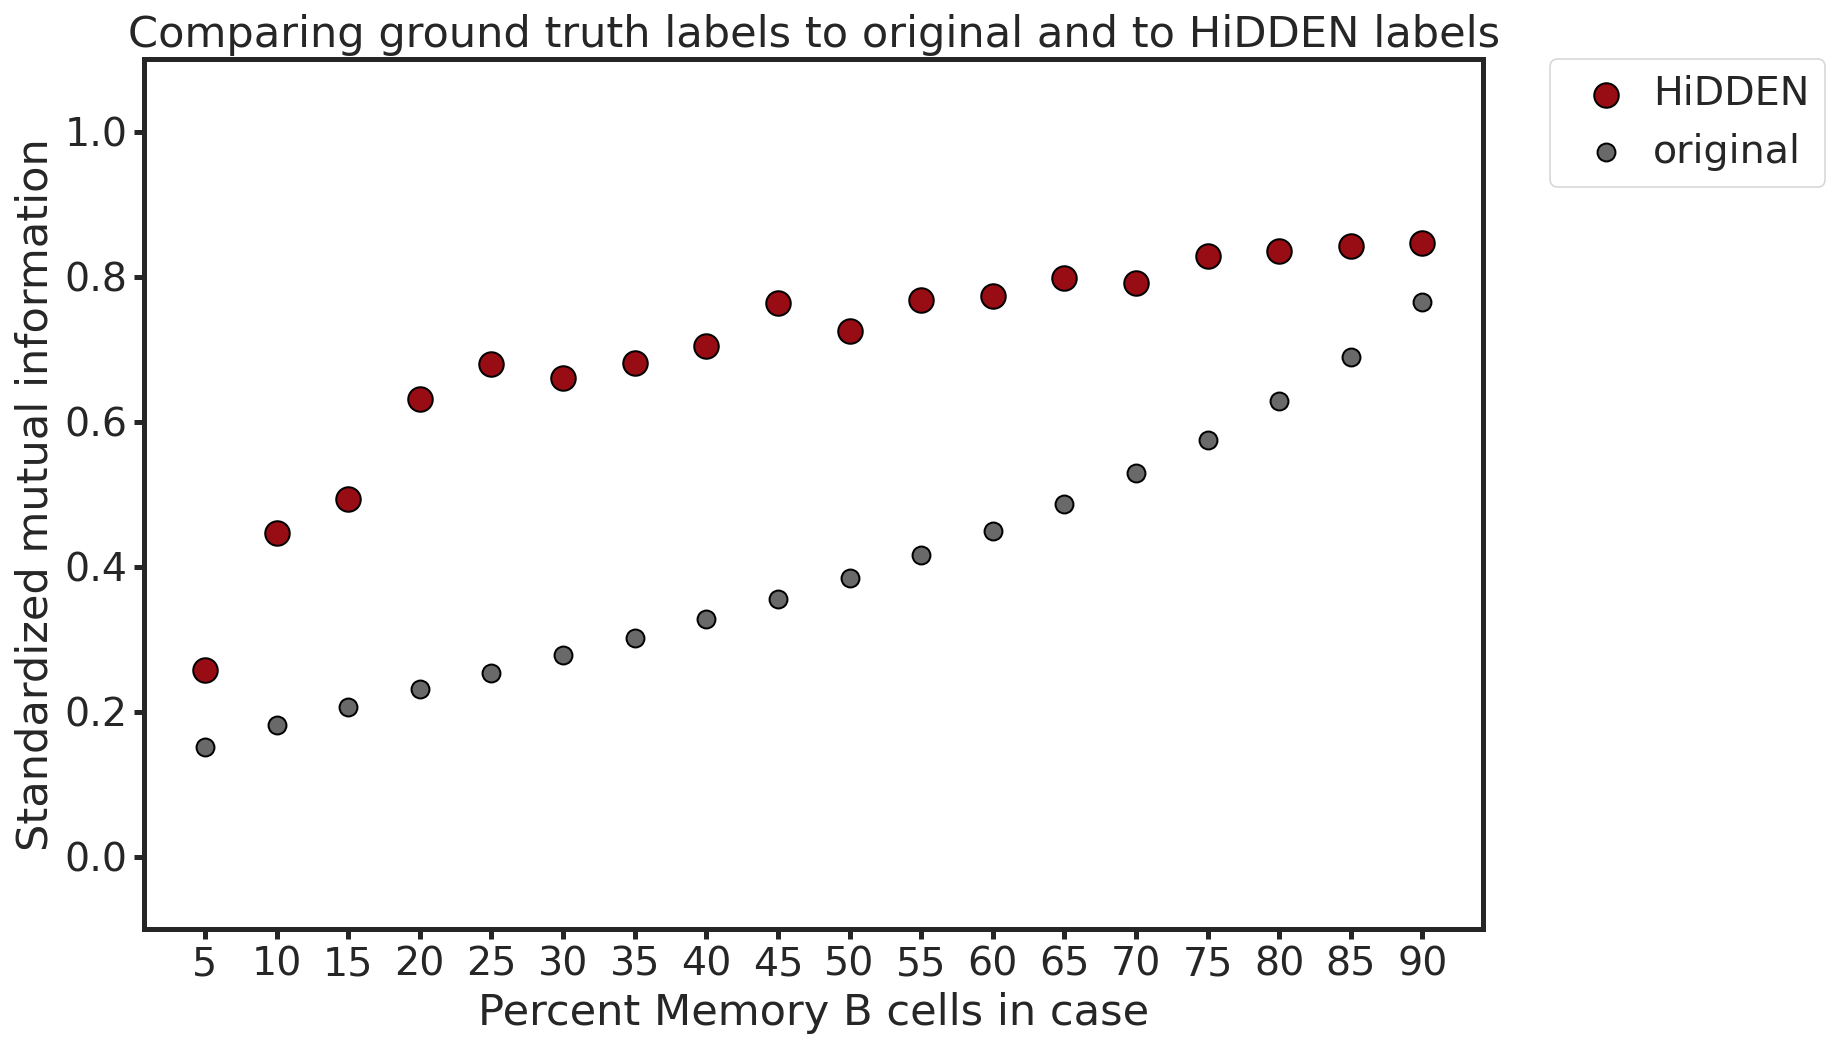

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or R

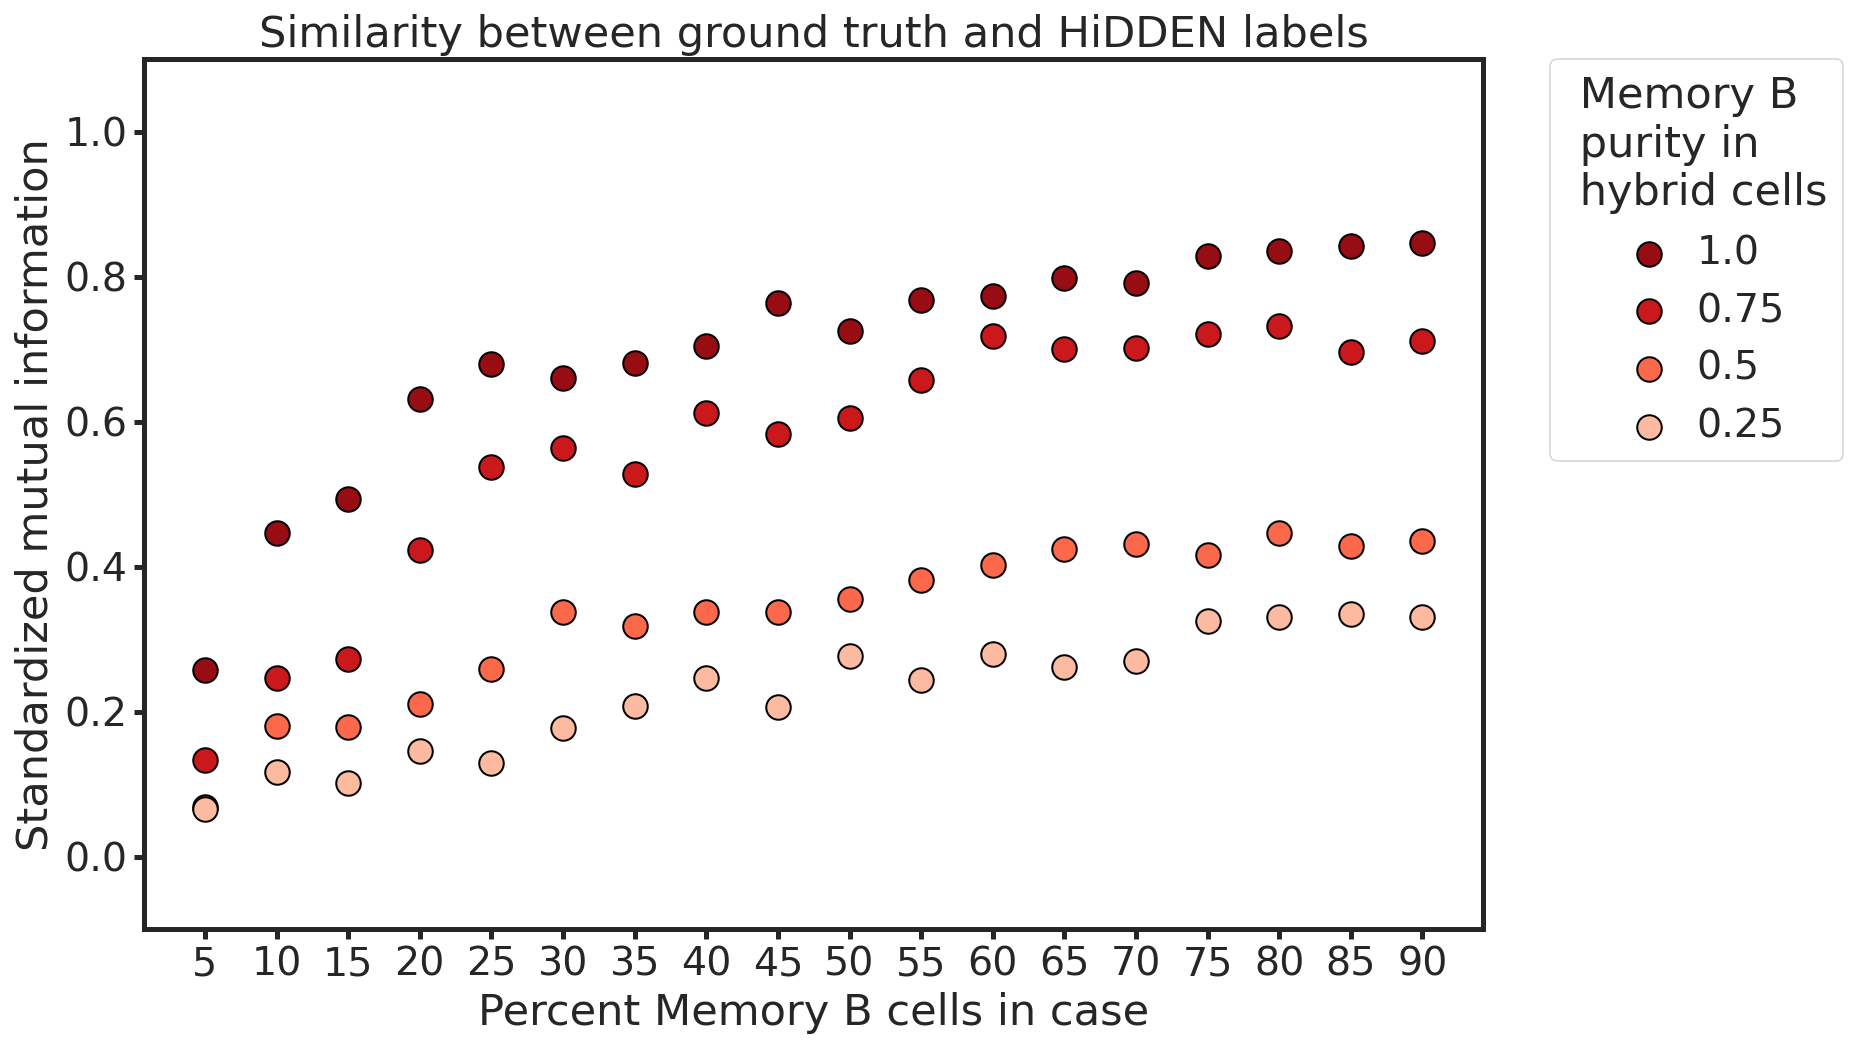

In [194]:
mutual_info_vec_orig = []
mutual_info_vec_new = []
mutual_info_vec_75_new = []
mutual_info_vec_50_new = []
mutual_info_vec_25_new = []

for NUM_MEMB in tqdm(['49', '100', '154', '211', '271', '335', '403', '475', '552', '633', '721', '814', '915', '1023', '1140', '1267', '1404', '1555']):
    
    PUCK_SUBNUMBER = 'naiveB_1900'
    PUCK_NUMBER = f'{PUCK_SUBNUMBER}_memoryB_{NUM_MEMB}'
    #adata = sc.read(f'figures/{PUCK_NUMBER}/adata.h5ad')
    
    W_m = 1
    NUM_PCS = optimal_NUM_PCS_dict[f'{PUCK_NUMBER} hybrid {W_m}'] if W_m!=1 else optimal_NUM_PCS_dict[f'{PUCK_NUMBER}']
    title_str = f'{PUCK_NUMBER} hybrid {W_m} {NUM_PCS} PCs' if W_m!=1 else f'{PUCK_NUMBER} {NUM_PCS} PCs'
    mutual_info_vec_orig.append(mutual_information_dict[f'{title_str}'][1]/mutual_information_dict[f'{title_str}'][2])
    mutual_info_vec_new.append(mutual_information_dict[f'{title_str}'][0]/mutual_information_dict[f'{title_str}'][2])
    
    W_m = 0.75
    NUM_PCS = optimal_NUM_PCS_dict[f'{PUCK_NUMBER} hybrid {W_m}'] if W_m!=1 else optimal_NUM_PCS_dict[f'{PUCK_NUMBER}']
    title_str = f'{PUCK_NUMBER} hybrid {W_m} {NUM_PCS} PCs' if W_m!=1 else f'{PUCK_NUMBER} {NUM_PCS} PCs'
    mutual_info_vec_75_new.append(mutual_information_dict[f'{title_str}'][0]/mutual_information_dict[f'{title_str}'][2])
    
    W_m = 0.5
    NUM_PCS = optimal_NUM_PCS_dict[f'{PUCK_NUMBER} hybrid {W_m}'] if W_m!=1 else optimal_NUM_PCS_dict[f'{PUCK_NUMBER}']
    title_str = f'{PUCK_NUMBER} hybrid {W_m} {NUM_PCS} PCs' if W_m!=1 else f'{PUCK_NUMBER} {NUM_PCS} PCs'
    mutual_info_vec_50_new.append(mutual_information_dict[f'{title_str}'][0]/mutual_information_dict[f'{title_str}'][2])
    
    W_m = 0.25
    NUM_PCS = optimal_NUM_PCS_dict[f'{PUCK_NUMBER} hybrid {W_m}'] if W_m!=1 else optimal_NUM_PCS_dict[f'{PUCK_NUMBER}']
    title_str = f'{PUCK_NUMBER} hybrid {W_m} {NUM_PCS} PCs' if W_m!=1 else f'{PUCK_NUMBER} {NUM_PCS} PCs'
    mutual_info_vec_25_new.append(mutual_information_dict[f'{title_str}'][0]/mutual_information_dict[f'{title_str}'][2])
    
plt.scatter(pct_memory_b_cells, mutual_info_vec_new, c=reds_palette(0.9), s=150, alpha=1, edgecolors='k', linewidths=1)
plt.scatter(pct_memory_b_cells, mutual_info_vec_orig, c='dimgray', s=80, alpha=1, edgecolors='k', linewidths=1)
plt.xlabel('Percent Memory B cells in case')
plt.ylabel('Standardized mutual information')
plt.ylim([-0.1, 1.1]) 
plt.title(f'Comparing ground truth labels to original and to HiDDEN labels')
plt.legend(['HiDDEN', 'original'], bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0, title='', handletextpad=0.2)
plt.savefig(f'figures/across_datasets/Mutual_information_HiDDEN_original.png', dpi=300, transparent=True, bbox_inches='tight')
plt.savefig(f'figures/across_datasets/Mutual_information_HiDDEN_original.svg', transparent=True, bbox_inches='tight')
plt.savefig(f'figures/across_datasets/Mutual_information_HiDDEN_original.pdf', transparent=True, bbox_inches='tight')
plt.show()

plt.scatter(pct_memory_b_cells, mutual_info_vec_new, c=reds_palette(0.9), s=150, alpha=1, edgecolors='k', linewidths=1)
plt.scatter(pct_memory_b_cells, mutual_info_vec_75_new, c=reds_palette(0.75), s=150, alpha=1, edgecolors='k', linewidths=1)
plt.scatter(pct_memory_b_cells, mutual_info_vec_50_new, c=reds_palette(0.5), s=150, alpha=1, edgecolors='k', linewidths=1)
plt.scatter(pct_memory_b_cells, mutual_info_vec_25_new, c=reds_palette(0.25), s=150, alpha=1, edgecolors='k', linewidths=1)
plt.xlabel('Percent Memory B cells in case')
plt.ylabel('Standardized mutual information')
plt.ylim([-0.1, 1.1]) 
plt.title(f'Similarity between ground truth and HiDDEN labels')
plt.legend(['1.0', '0.75', '0.5', '0.25'], bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0, 
           title=' Memory B \n purity in \n hybrid cells', handletextpad=0.2)
plt.savefig(f'figures/across_datasets/Mutual_information_HiDDEN_ablation.png', dpi=300, transparent=True, bbox_inches='tight')
plt.savefig(f'figures/across_datasets/Mutual_information_HiDDEN_ablation.svg', transparent=True, bbox_inches='tight')
plt.savefig(f'figures/across_datasets/Mutual_information_HiDDEN_ablation.pdf', transparent=True, bbox_inches='tight')
plt.show()

  0%|          | 0/18 [00:00<?, ?it/s]

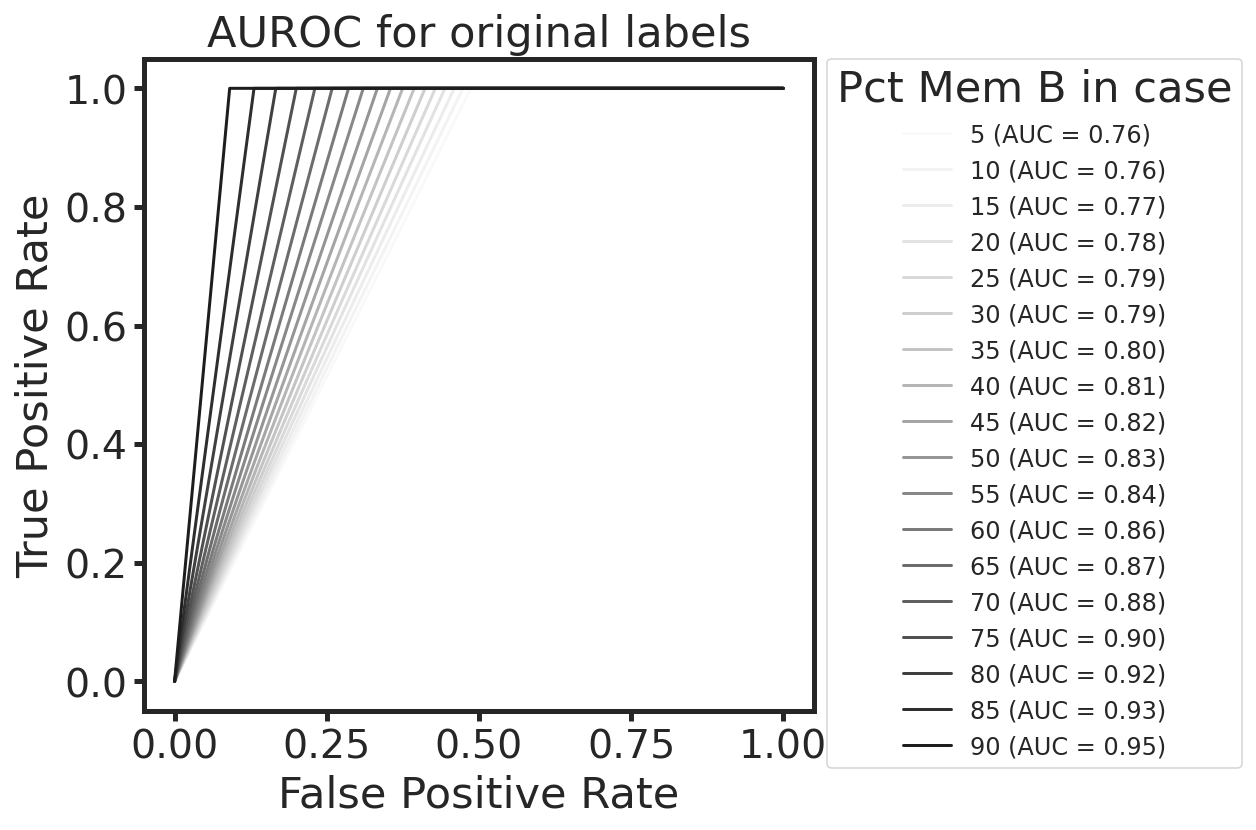

In [195]:
fig = plt.figure(figsize=(6, 6))
ax = plt.gca()
i=0

for NUM_MEMB in tqdm(['49', '100', '154', '211', '271', '335', '403', '475', '552', '633', '721', '814', '915', '1023', '1140', '1267', '1404', '1555']):
    
    pct_memb = pct_memory_b_cells[i]
    PUCK_SUBNUMBER = 'naiveB_1900'
    PUCK_NUMBER = f'{PUCK_SUBNUMBER}_memoryB_{NUM_MEMB}'
    #adata = sc.read(f'figures/{PUCK_NUMBER}/adata.h5ad')
    
    opt_num_pcs = optimal_NUM_PCS_dict[f'{PUCK_NUMBER}']
    y_true = pd.read_csv(f'figures/{PUCK_NUMBER}/ground_truth_{PUCK_NUMBER} {opt_num_pcs} PCs.csv')['perturbed'].values == 'Memory B'
    y_pred = pd.read_csv(f'figures/{PUCK_NUMBER}/batch_{PUCK_NUMBER} {opt_num_pcs} PCs.csv')['batch'].values
    plot_roc_curve(y_true, y_pred, name=f'{pct_memb}', color=greys_palette(int(pct_memb)/100), lw=1.5)
    i=i+1
    
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0, title='Pct Mem B in case', fontsize=12)
plt.title(f'AUROC for original labels')
plt.savefig(f'figures/across_datasets/AUROC_original_datatsets.png', dpi=300, transparent=True, bbox_inches='tight')
plt.savefig(f'figures/across_datasets/AUROC_original_datatsets.svg', transparent=True, bbox_inches='tight')
plt.savefig(f'figures/across_datasets/AUROC_original_datatsets.pdf', transparent=True, bbox_inches='tight')
plt.show()
    

  0%|          | 0/18 [00:00<?, ?it/s]

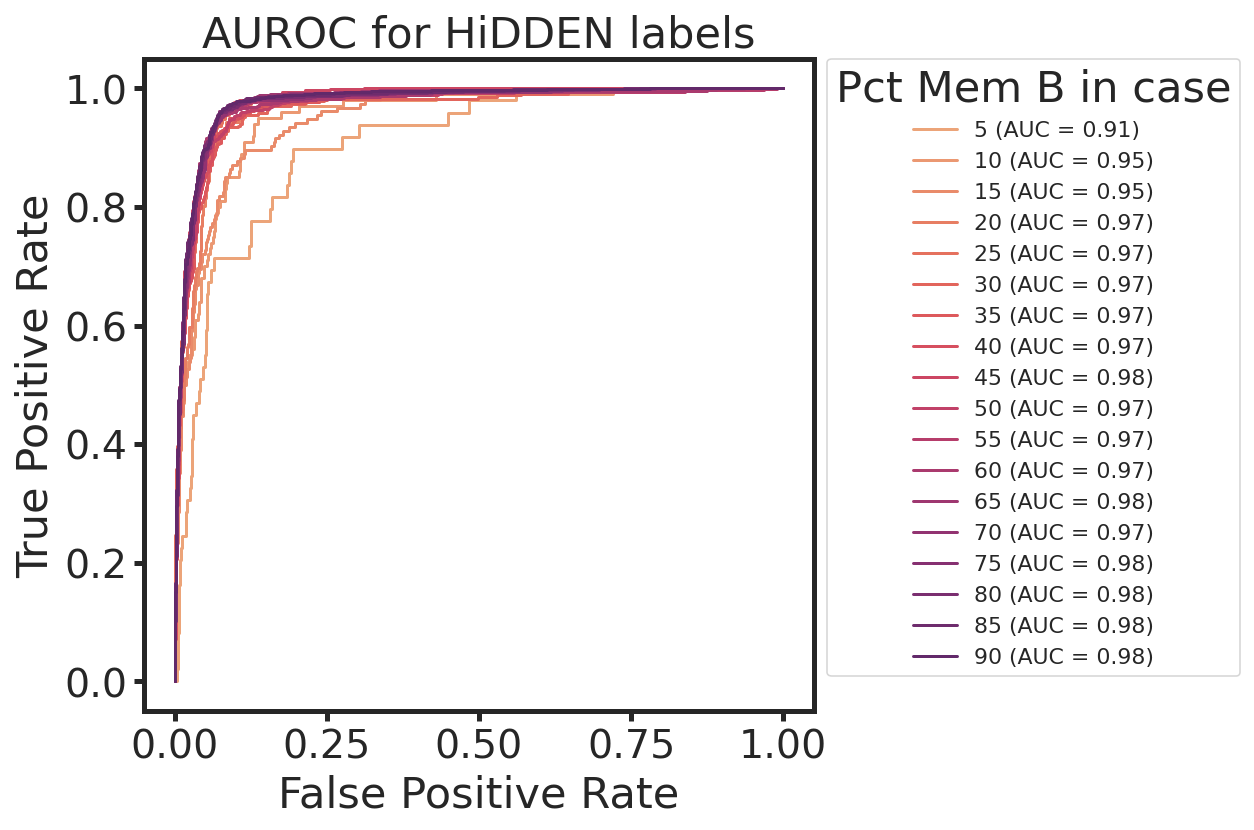

In [196]:
flare_palette = sns.color_palette("flare", as_cmap=True)
flare_palette

fig = plt.figure(figsize=(6, 6))
ax = plt.gca()
i=0

W_m = 1
for NUM_MEMB in tqdm(['49', '100', '154', '211', '271', '335', '403', '475', '552', '633', '721', '814', '915', '1023', '1140', '1267', '1404', '1555']):
    
    pct_memb = pct_memory_b_cells[i]
    PUCK_SUBNUMBER = 'naiveB_1900'
    PUCK_NUMBER = f'{PUCK_SUBNUMBER}_memoryB_{NUM_MEMB}'
    #adata = sc.read(f'figures/{PUCK_NUMBER}/adata.h5ad')
    
    opt_num_pcs = optimal_NUM_PCS_dict[f'{PUCK_NUMBER}']
    y_true = pd.read_csv(f'figures/{PUCK_NUMBER}/ground_truth_{PUCK_NUMBER} {opt_num_pcs} PCs.csv')['perturbed'].values == 'Memory B'
    y_pred = pd.read_csv(f'figures/{PUCK_NUMBER}/p_hat_{PUCK_NUMBER} {opt_num_pcs} PCs.csv')['p_hat'].values
    plot_roc_curve(y_true, y_pred, name=f'{pct_memb}', color=flare_palette(int(pct_memb)/100), lw=1.5)
    i=i+1
    
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0, title='Pct Mem B in case', fontsize=11)
plt.title(f'AUROC for HiDDEN labels')
plt.savefig(f'figures/across_datasets/AUROC_HiDDEN_{W_m}_datatsets.png', dpi=300, transparent=True, bbox_inches='tight')
plt.savefig(f'figures/across_datasets/AUROC_HiDDEN_{W_m}_datatsets.svg', transparent=True, bbox_inches='tight')
plt.savefig(f'figures/across_datasets/AUROC_HiDDEN_{W_m}_datatsets.pdf', transparent=True, bbox_inches='tight')
plt.show()
    

  0%|          | 0/18 [00:00<?, ?it/s]

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


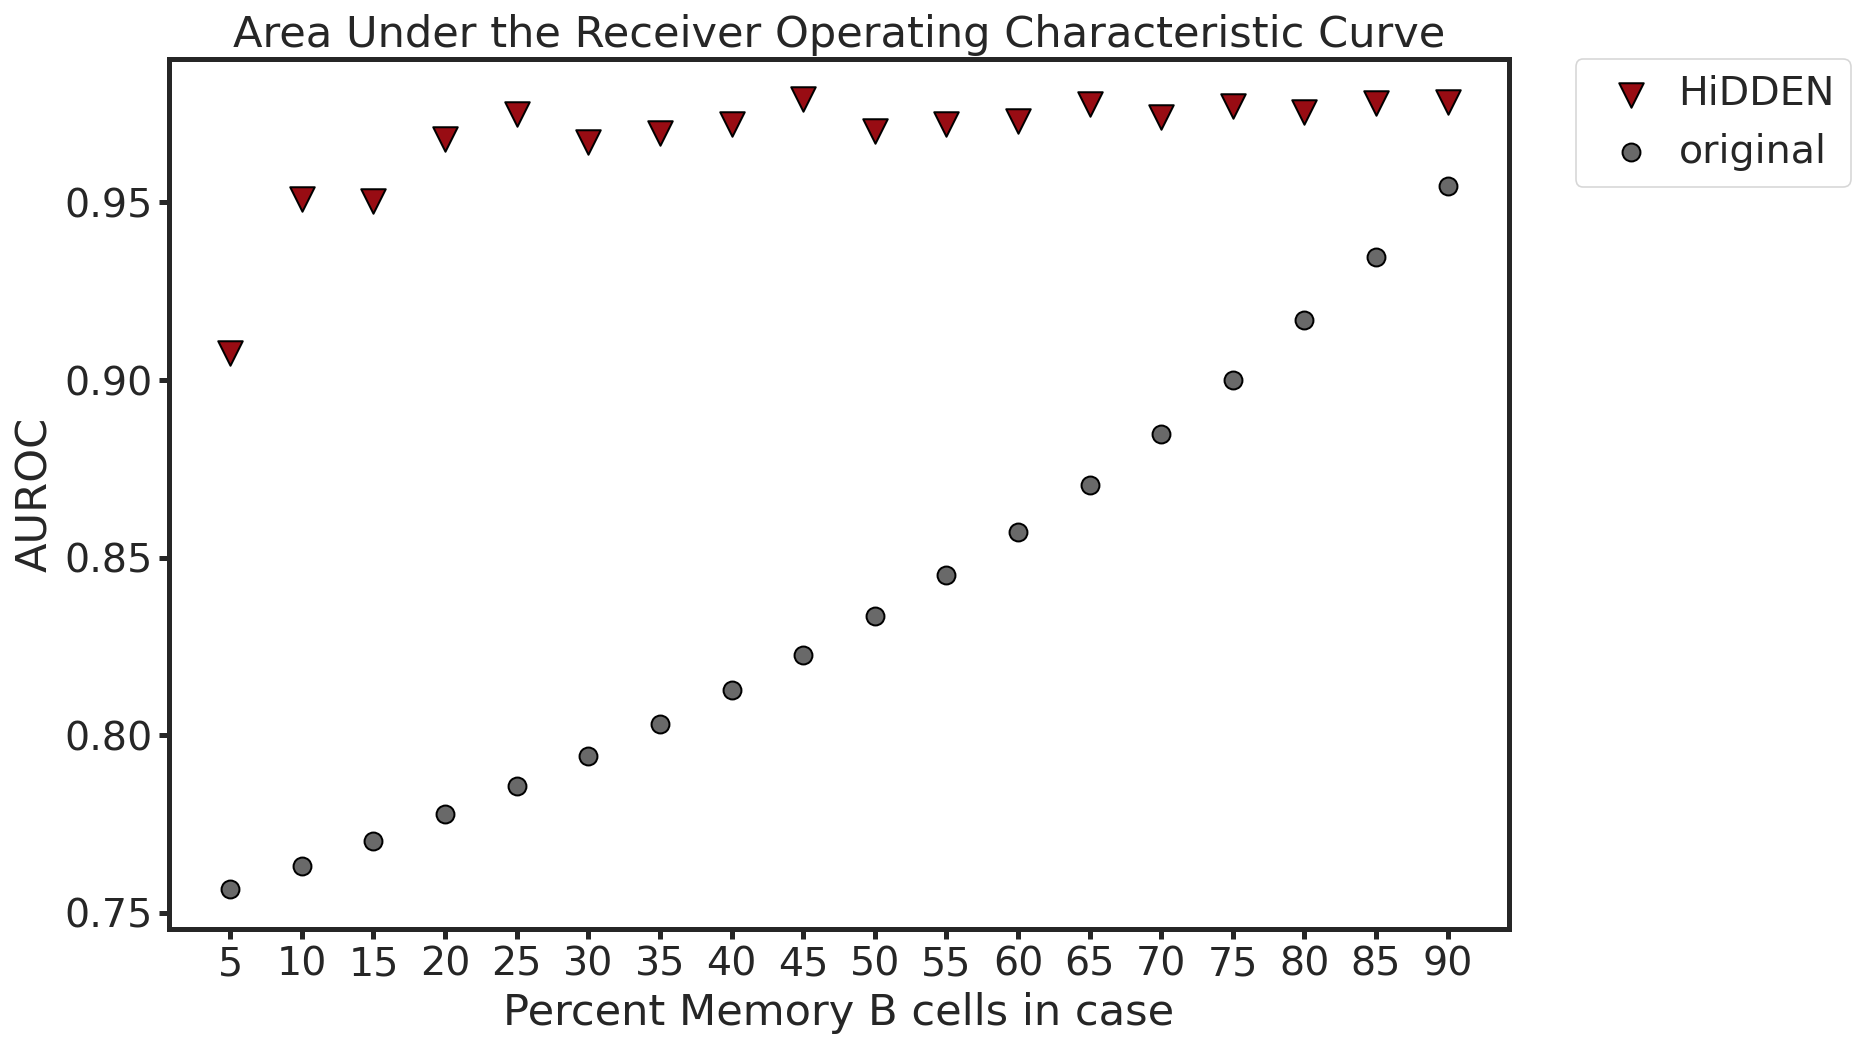

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or R

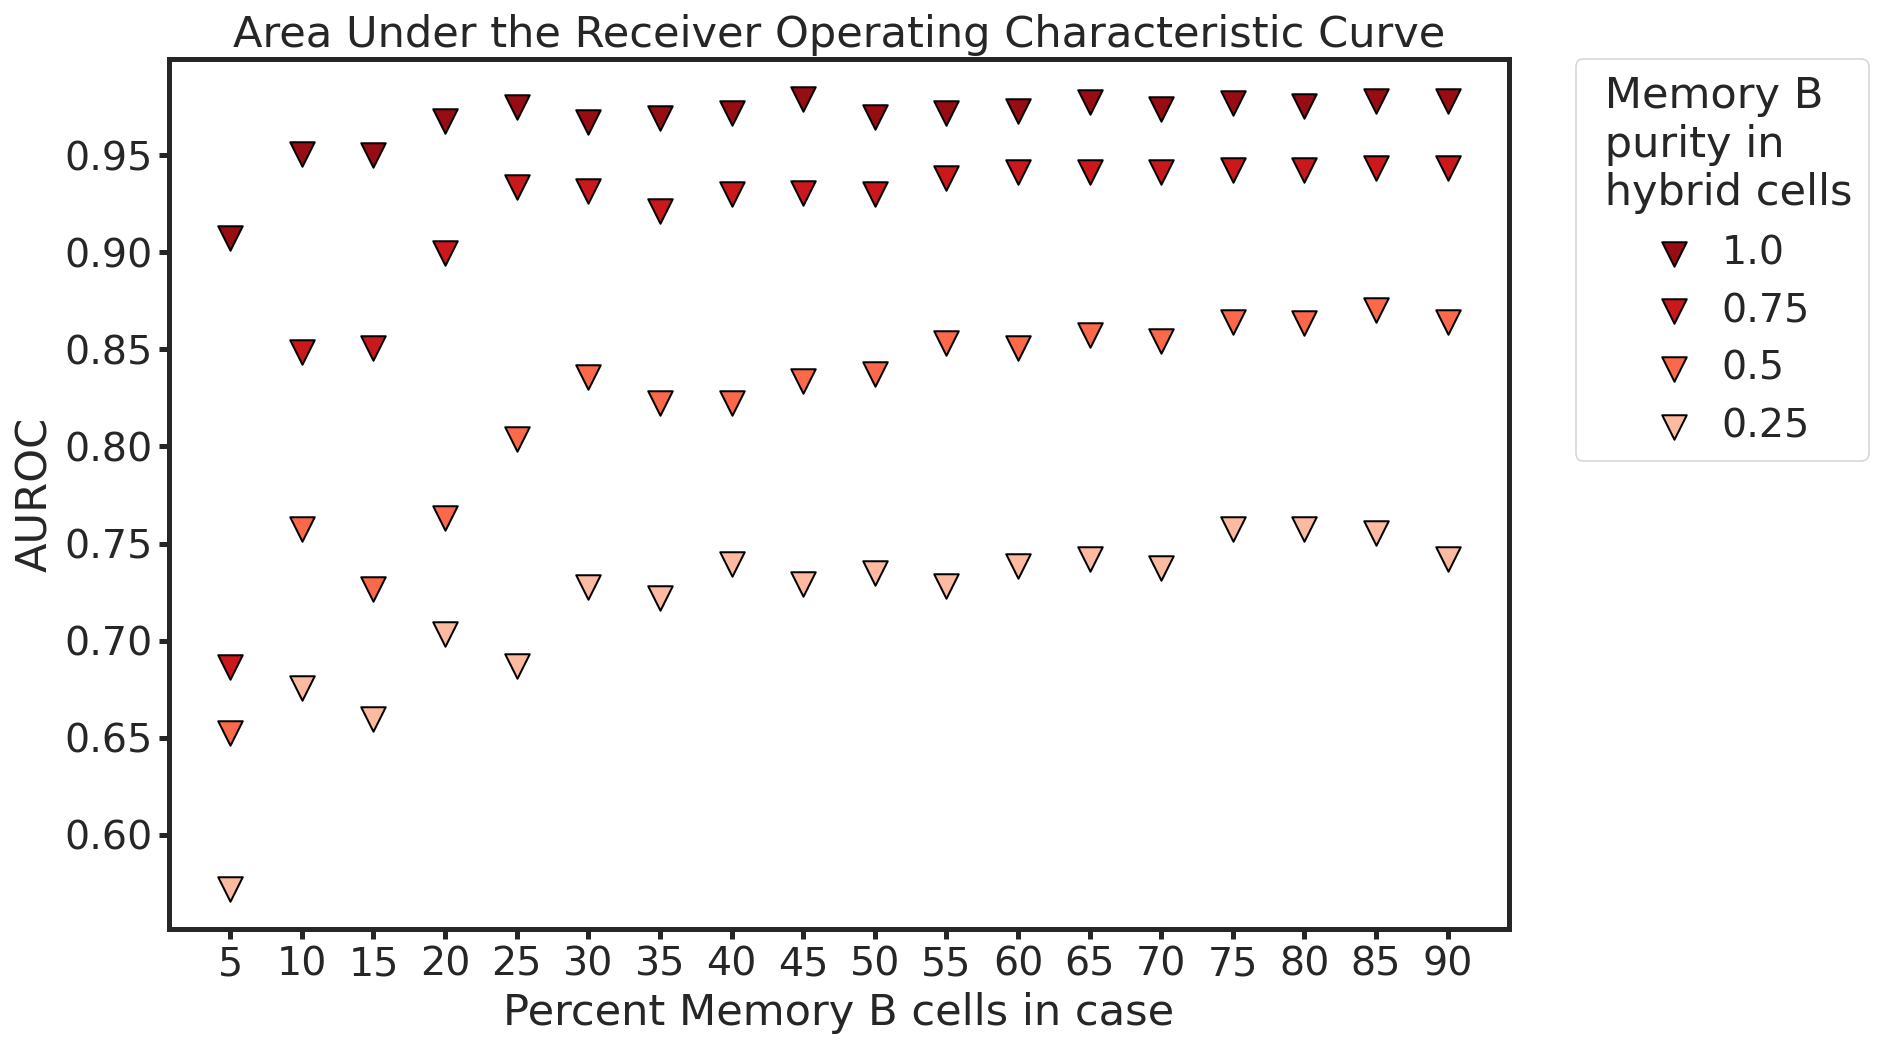

In [197]:
auroc_vec_orig = []
auroc_vec_new = []
auroc_vec_75_new = []
auroc_vec_50_new = []
auroc_vec_25_new = []

for NUM_MEMB in tqdm(['49', '100', '154', '211', '271', '335', '403', '475', '552', '633', '721', '814', '915', '1023', '1140', '1267', '1404', '1555']):
    
    PUCK_SUBNUMBER = 'naiveB_1900'
    PUCK_NUMBER = f'{PUCK_SUBNUMBER}_memoryB_{NUM_MEMB}'
    #adata = sc.read(f'figures/{PUCK_NUMBER}/adata.h5ad')
    
    W_m = 1
    NUM_PCS = optimal_NUM_PCS_dict[f'{PUCK_NUMBER} hybrid {W_m}'] if W_m!=1 else optimal_NUM_PCS_dict[f'{PUCK_NUMBER}']
    y_true = pd.read_csv(f'figures/{PUCK_NUMBER}/ground_truth_{PUCK_NUMBER} {NUM_PCS} PCs.csv')['perturbed'].values == 'Memory B'
    y_pred = pd.read_csv(f'figures/{PUCK_NUMBER}/batch_{PUCK_NUMBER} {NUM_PCS} PCs.csv')['batch'].values
    fpr, tpr, _ = roc_curve(y_true, y_pred)
    roc_auc = auc(fpr, tpr)
    auroc_vec_orig.append(roc_auc)
    y_pred = pd.read_csv(f'figures/{PUCK_NUMBER}/p_hat_{PUCK_NUMBER} {NUM_PCS} PCs.csv')['p_hat'].values
    fpr, tpr, _ = roc_curve(y_true, y_pred)
    roc_auc = auc(fpr, tpr)
    auroc_vec_new.append(roc_auc)
    
    W_m = 0.75
    NUM_PCS = optimal_NUM_PCS_dict[f'{PUCK_NUMBER} hybrid {W_m}'] if W_m!=1 else optimal_NUM_PCS_dict[f'{PUCK_NUMBER}']
    y_true = pd.read_csv(f'figures/{PUCK_NUMBER} hybrid {W_m}/ground_truth_{PUCK_NUMBER} hybrid {W_m} {NUM_PCS} PCs.csv')['perturbed'].values == 'Memory B'
    y_pred = pd.read_csv(f'figures/{PUCK_NUMBER} hybrid {W_m}/p_hat_{PUCK_NUMBER} hybrid {W_m} {NUM_PCS} PCs.csv')['p_hat'].values
    fpr, tpr, _ = roc_curve(y_true, y_pred)
    roc_auc = auc(fpr, tpr)
    auroc_vec_75_new.append(roc_auc)
    
    W_m = 0.5
    NUM_PCS = optimal_NUM_PCS_dict[f'{PUCK_NUMBER} hybrid {W_m}'] if W_m!=1 else optimal_NUM_PCS_dict[f'{PUCK_NUMBER}']
    y_true = pd.read_csv(f'figures/{PUCK_NUMBER} hybrid {W_m}/ground_truth_{PUCK_NUMBER} hybrid {W_m} {NUM_PCS} PCs.csv')['perturbed'].values == 'Memory B'
    y_pred = pd.read_csv(f'figures/{PUCK_NUMBER} hybrid {W_m}/p_hat_{PUCK_NUMBER} hybrid {W_m} {NUM_PCS} PCs.csv')['p_hat'].values
    fpr, tpr, _ = roc_curve(y_true, y_pred)
    roc_auc = auc(fpr, tpr)
    auroc_vec_50_new.append(roc_auc)
    
    W_m = 0.25
    NUM_PCS = optimal_NUM_PCS_dict[f'{PUCK_NUMBER} hybrid {W_m}'] if W_m!=1 else optimal_NUM_PCS_dict[f'{PUCK_NUMBER}']
    y_true = pd.read_csv(f'figures/{PUCK_NUMBER} hybrid {W_m}/ground_truth_{PUCK_NUMBER} hybrid {W_m} {NUM_PCS} PCs.csv')['perturbed'].values == 'Memory B'
    y_pred = pd.read_csv(f'figures/{PUCK_NUMBER} hybrid {W_m}/p_hat_{PUCK_NUMBER} hybrid {W_m} {NUM_PCS} PCs.csv')['p_hat'].values
    fpr, tpr, _ = roc_curve(y_true, y_pred)
    roc_auc = auc(fpr, tpr)
    auroc_vec_25_new.append(roc_auc)
    
plt.scatter(pct_memory_b_cells, auroc_vec_new, c=reds_palette(0.9), s=150, marker='v', alpha=1, edgecolors='k', linewidths=1)
plt.scatter(pct_memory_b_cells, auroc_vec_orig, c='dimgray', s=80, alpha=1, edgecolors='k', linewidths=1)
plt.xlabel('Percent Memory B cells in case')
plt.ylabel('AUROC')
#plt.ylim([-0.1, 1.1]) 
plt.title(f'Area Under the Receiver Operating Characteristic Curve')
plt.legend(['HiDDEN', 'original'], bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0, title='', handletextpad=0.2)
plt.savefig(f'figures/across_datasets/AUROC_HiDDEN_original.png', dpi=300, transparent=True, bbox_inches='tight')
plt.savefig(f'figures/across_datasets/AUROC_HiDDEN_original.svg', transparent=True, bbox_inches='tight')
plt.savefig(f'figures/across_datasets/AUROC_HiDDEN_original.pdf', transparent=True, bbox_inches='tight')
plt.show()

plt.scatter(pct_memory_b_cells, auroc_vec_new, c=reds_palette(0.9), s=150, marker='v', alpha=1, edgecolors='k', linewidths=1)
plt.scatter(pct_memory_b_cells, auroc_vec_75_new, c=reds_palette(0.75), s=150, marker='v', alpha=1, edgecolors='k', linewidths=1)
plt.scatter(pct_memory_b_cells, auroc_vec_50_new, c=reds_palette(0.5), s=150, marker='v', alpha=1, edgecolors='k', linewidths=1)
plt.scatter(pct_memory_b_cells, auroc_vec_25_new, c=reds_palette(0.25), s=150, marker='v', alpha=1, edgecolors='k', linewidths=1)
plt.xlabel('Percent Memory B cells in case')
plt.ylabel('AUROC')
#plt.ylim([-0.1, 1.1]) 
plt.title(f'Area Under the Receiver Operating Characteristic Curve')
plt.legend(['1.0', '0.75', '0.5', '0.25'], bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0, 
           title=' Memory B \n purity in \n hybrid cells', handletextpad=0.2)
plt.savefig(f'figures/across_datasets/AUROC_HiDDEN_ablation.png', dpi=300, transparent=True, bbox_inches='tight')
plt.savefig(f'figures/across_datasets/AUROC_HiDDEN_ablation.svg', transparent=True, bbox_inches='tight')
plt.savefig(f'figures/across_datasets/AUROC_HiDDEN_ablation.pdf', transparent=True, bbox_inches='tight')
plt.show()

  0%|          | 0/18 [00:00<?, ?it/s]

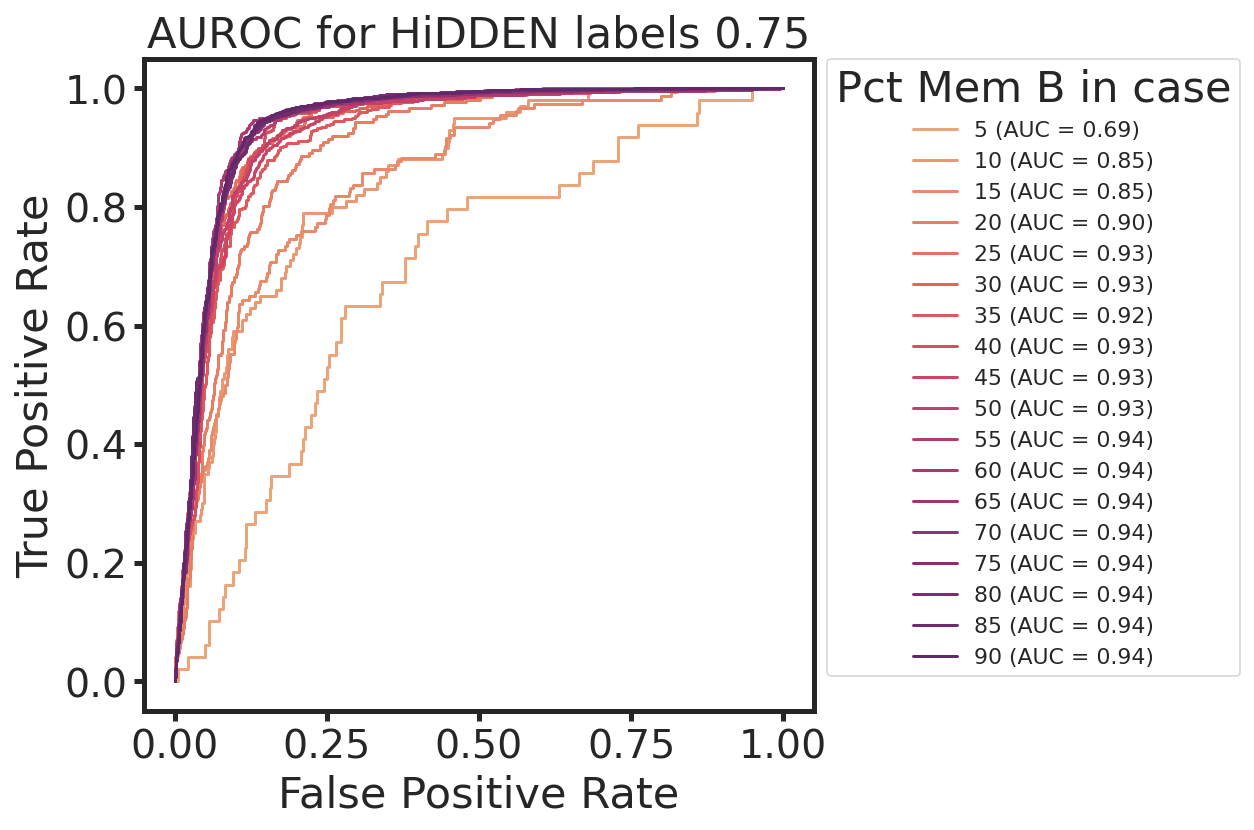

In [202]:
fig = plt.figure(figsize=(6, 6))
ax = plt.gca()
i=0

W_m = 0.75
for NUM_MEMB in tqdm(['49', '100', '154', '211', '271', '335', '403', '475', '552', '633', '721', '814', '915', '1023', '1140', '1267', '1404', '1555']):
    
    pct_memb = pct_memory_b_cells[i]
    PUCK_SUBNUMBER = 'naiveB_1900'
    PUCK_NUMBER = f'{PUCK_SUBNUMBER}_memoryB_{NUM_MEMB} hybrid {W_m}'
    #adata = sc.read(f'figures/{PUCK_NUMBER}/adata.h5ad')
    
    opt_num_pcs = optimal_NUM_PCS_dict[f'{PUCK_NUMBER}']
    y_true = pd.read_csv(f'figures/{PUCK_NUMBER}/ground_truth_{PUCK_NUMBER} {opt_num_pcs} PCs.csv')['perturbed'].values == 'Memory B'
    y_pred = pd.read_csv(f'figures/{PUCK_NUMBER}/p_hat_{PUCK_NUMBER} {opt_num_pcs} PCs.csv')['p_hat'].values
    plot_roc_curve(y_true, y_pred, name=f'{pct_memb}', color=flare_palette(int(pct_memb)/100), lw=1.5)
    i=i+1
    
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0, title='Pct Mem B in case', fontsize=11)
plt.title(f'AUROC for HiDDEN labels {W_m}')
plt.savefig(f'figures/across_datasets/AUROC_HiDDEN_{W_m}_datatsets.png', dpi=300, transparent=True, bbox_inches='tight')
plt.savefig(f'figures/across_datasets/AUROC_HiDDEN_{W_m}_datatsets.svg', transparent=True, bbox_inches='tight')
plt.savefig(f'figures/across_datasets/AUROC_HiDDEN_{W_m}_datatsets.pdf', transparent=True, bbox_inches='tight')
plt.show()
    

  0%|          | 0/18 [00:00<?, ?it/s]

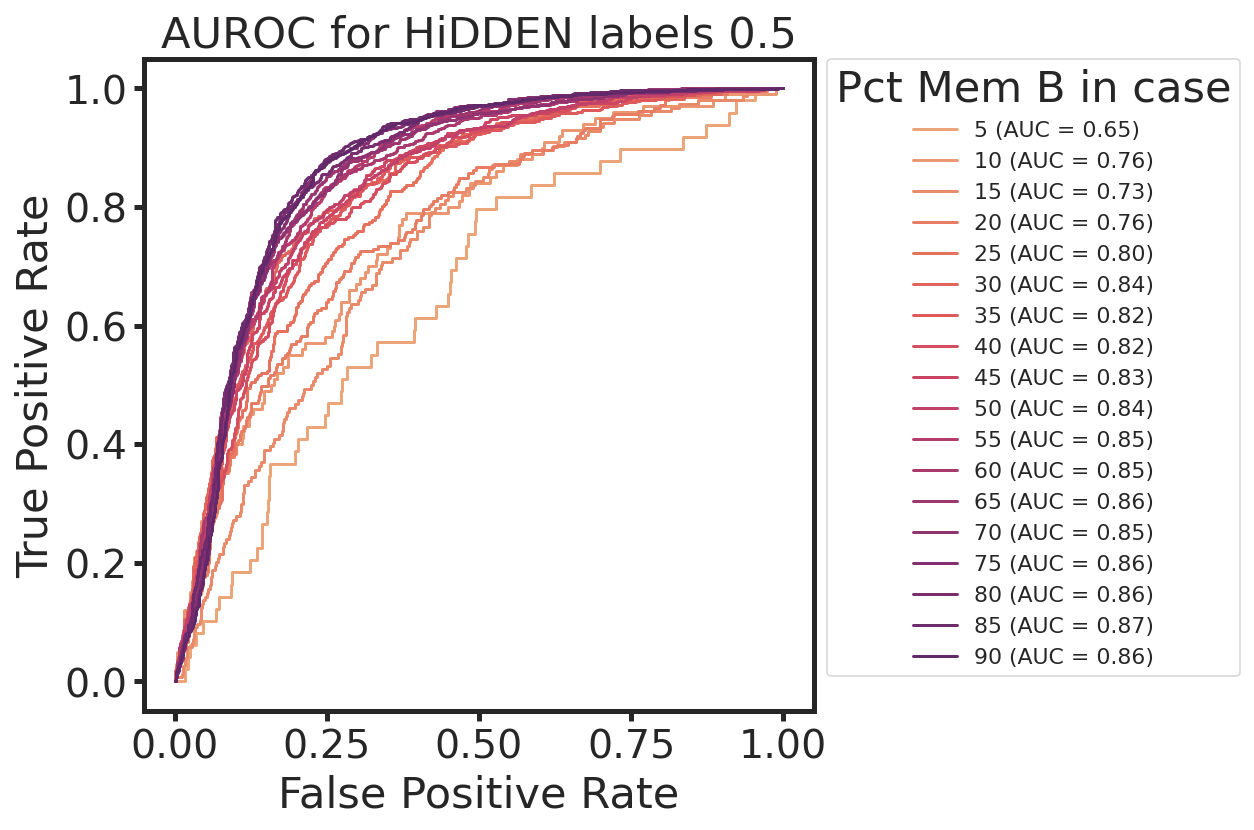

In [203]:
fig = plt.figure(figsize=(6, 6))
ax = plt.gca()
i=0

W_m = 0.5
for NUM_MEMB in tqdm(['49', '100', '154', '211', '271', '335', '403', '475', '552', '633', '721', '814', '915', '1023', '1140', '1267', '1404', '1555']):
    
    pct_memb = pct_memory_b_cells[i]
    PUCK_SUBNUMBER = 'naiveB_1900'
    PUCK_NUMBER = f'{PUCK_SUBNUMBER}_memoryB_{NUM_MEMB} hybrid {W_m}'
    #adata = sc.read(f'figures/{PUCK_NUMBER}/adata.h5ad')
    
    opt_num_pcs = optimal_NUM_PCS_dict[f'{PUCK_NUMBER}']
    y_true = pd.read_csv(f'figures/{PUCK_NUMBER}/ground_truth_{PUCK_NUMBER} {opt_num_pcs} PCs.csv')['perturbed'].values == 'Memory B'
    y_pred = pd.read_csv(f'figures/{PUCK_NUMBER}/p_hat_{PUCK_NUMBER} {opt_num_pcs} PCs.csv')['p_hat'].values
    plot_roc_curve(y_true, y_pred, name=f'{pct_memb}', color=flare_palette(int(pct_memb)/100), lw=1.5)
    i=i+1
    
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0, title='Pct Mem B in case', fontsize=11)
plt.title(f'AUROC for HiDDEN labels {W_m}')
plt.savefig(f'figures/across_datasets/AUROC_HiDDEN_{W_m}_datatsets.png', dpi=300, transparent=True, bbox_inches='tight')
plt.savefig(f'figures/across_datasets/AUROC_HiDDEN_{W_m}_datatsets.svg', transparent=True, bbox_inches='tight')
plt.savefig(f'figures/across_datasets/AUROC_HiDDEN_{W_m}_datatsets.pdf', transparent=True, bbox_inches='tight')
plt.show()
    

  0%|          | 0/18 [00:00<?, ?it/s]

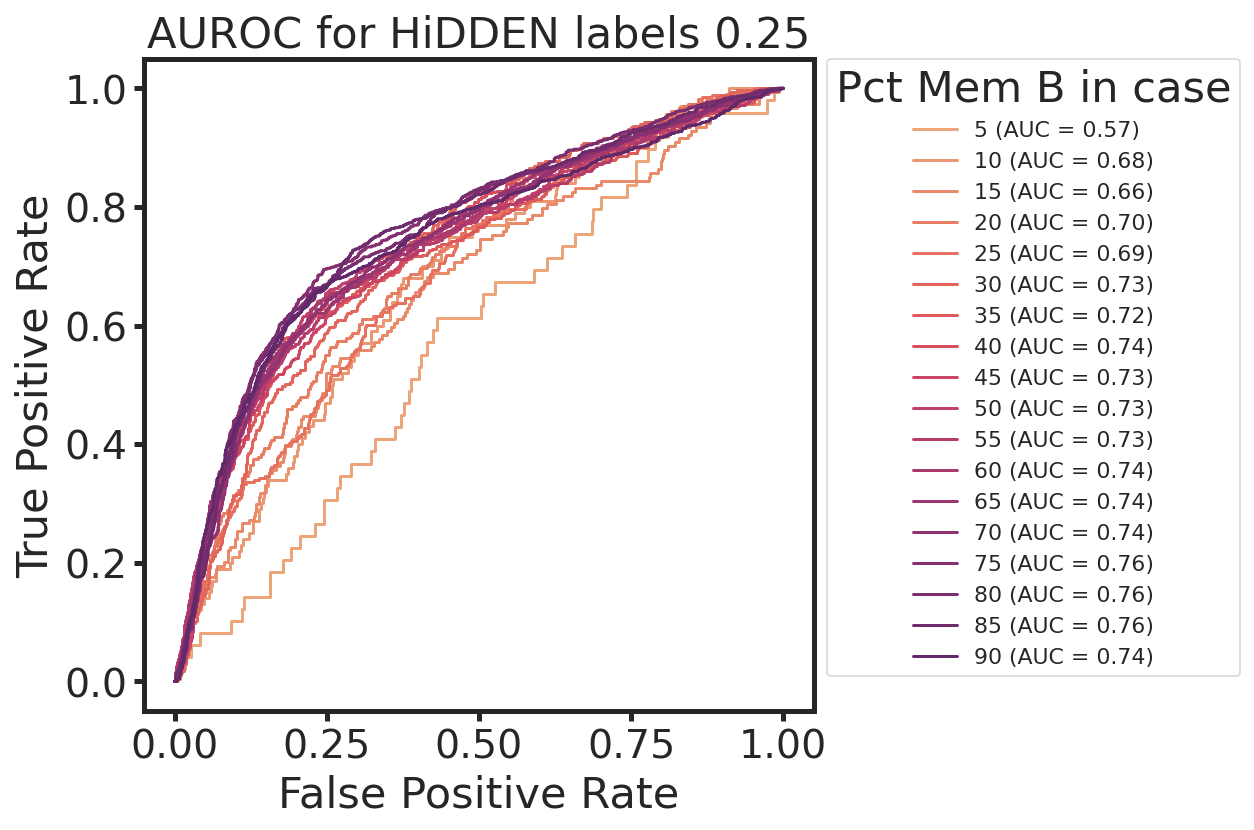

In [204]:
fig = plt.figure(figsize=(6, 6))
ax = plt.gca()
i=0

W_m = 0.25
for NUM_MEMB in tqdm(['49', '100', '154', '211', '271', '335', '403', '475', '552', '633', '721', '814', '915', '1023', '1140', '1267', '1404', '1555']):
    
    pct_memb = pct_memory_b_cells[i]
    PUCK_SUBNUMBER = 'naiveB_1900'
    PUCK_NUMBER = f'{PUCK_SUBNUMBER}_memoryB_{NUM_MEMB} hybrid {W_m}'
    #adata = sc.read(f'figures/{PUCK_NUMBER}/adata.h5ad')
    
    opt_num_pcs = optimal_NUM_PCS_dict[f'{PUCK_NUMBER}']
    y_true = pd.read_csv(f'figures/{PUCK_NUMBER}/ground_truth_{PUCK_NUMBER} {opt_num_pcs} PCs.csv')['perturbed'].values == 'Memory B'
    y_pred = pd.read_csv(f'figures/{PUCK_NUMBER}/p_hat_{PUCK_NUMBER} {opt_num_pcs} PCs.csv')['p_hat'].values
    plot_roc_curve(y_true, y_pred, name=f'{pct_memb}', color=flare_palette(int(pct_memb)/100), lw=1.5)
    i=i+1
    
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0, title='Pct Mem B in case', fontsize=11)
plt.title(f'AUROC for HiDDEN labels {W_m}')
plt.savefig(f'figures/across_datasets/AUROC_HiDDEN_{W_m}_datatsets.png', dpi=300, transparent=True, bbox_inches='tight')
plt.savefig(f'figures/across_datasets/AUROC_HiDDEN_{W_m}_datatsets.svg', transparent=True, bbox_inches='tight')
plt.savefig(f'figures/across_datasets/AUROC_HiDDEN_{W_m}_datatsets.pdf', transparent=True, bbox_inches='tight')
plt.show()
    

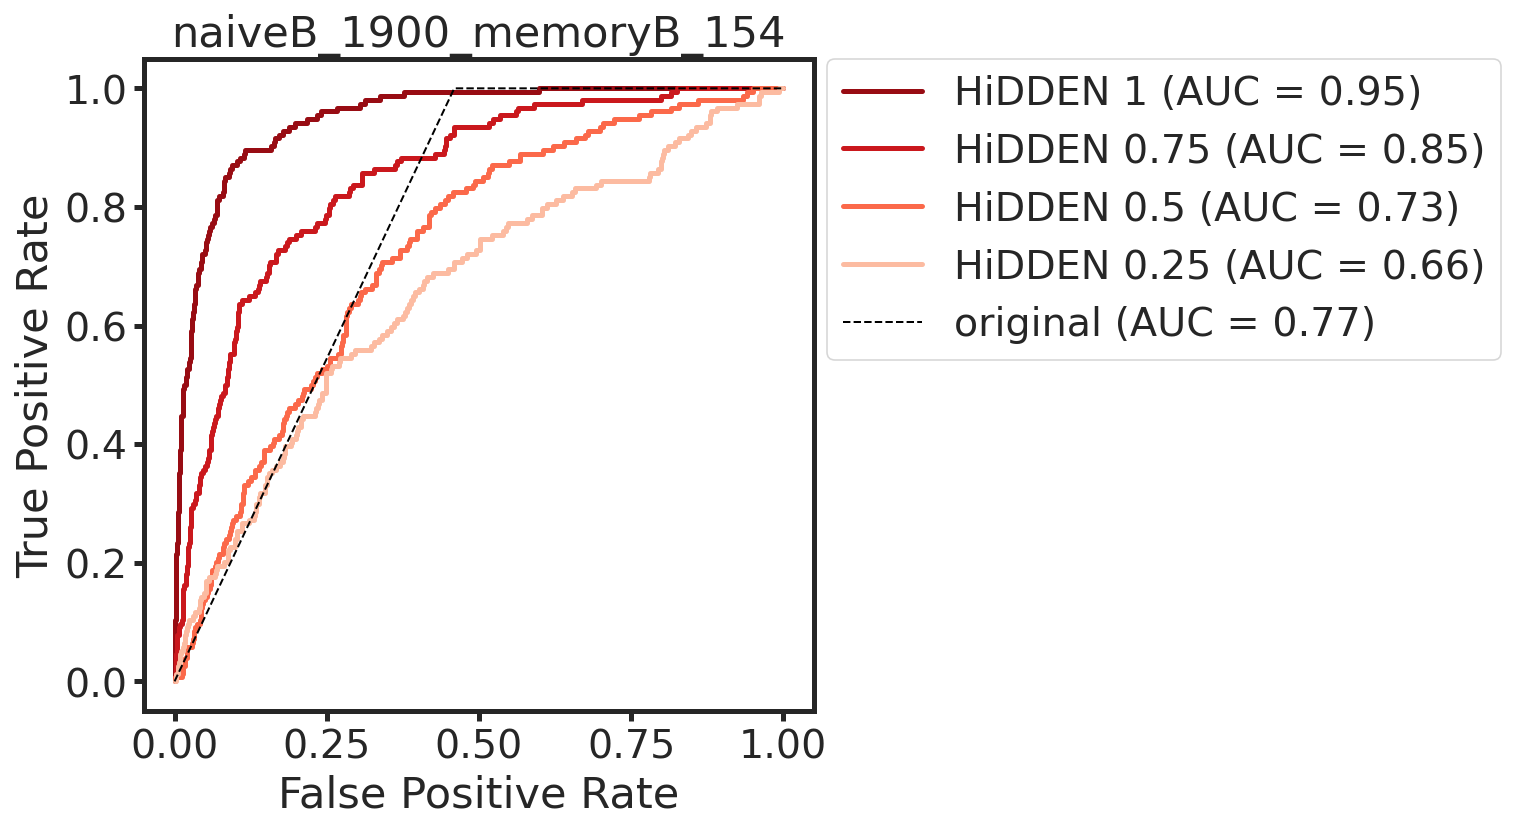

In [340]:
#optimal_NUM_PCS_dict = dict(np.load('figures/ablation/optimal_NUM_PCS_dict_ablation_dict.npz')) # old heuristic
PUCK_NUMBER = 'naiveB_1900_memoryB_154'

optimal_NUM_PCS_dict = dict(np.load('figures/ablation/optimal_NUM_PCS_KS_dict.npz'))

fig = plt.figure(figsize=(6, 6))
ax = plt.gca()

W_m=1
opt_num_pcs = optimal_NUM_PCS_dict[f'{PUCK_NUMBER}']
y_true = pd.read_csv(f'figures/{PUCK_NUMBER}/ground_truth_{PUCK_NUMBER} {opt_num_pcs} PCs.csv')['perturbed'].values == 'Memory B'
y_pred = pd.read_csv(f'figures/{PUCK_NUMBER}/p_hat_{PUCK_NUMBER} {opt_num_pcs} PCs.csv')['p_hat'].values
plot_roc_curve(y_true, y_pred, name=f'HiDDEN {W_m}', color=reds_palette(W_m if W_m!=1 else 0.9), lw=2.5)

W_m = 0.75
opt_num_pcs = optimal_NUM_PCS_dict[f'{PUCK_NUMBER} hybrid {W_m}']
y_true = pd.read_csv(f'figures/{PUCK_NUMBER} hybrid {W_m}/ground_truth_{PUCK_NUMBER} hybrid {W_m} {opt_num_pcs} PCs.csv')['perturbed'].values == 'Memory B'
y_pred = pd.read_csv(f'figures/{PUCK_NUMBER} hybrid {W_m}/p_hat_{PUCK_NUMBER} hybrid {W_m} {opt_num_pcs} PCs.csv')['p_hat'].values
plot_roc_curve(y_true, y_pred, name=f'HiDDEN {W_m}', color=reds_palette(W_m if W_m!=1 else 0.9), lw=2.5)

W_m = 0.5
opt_num_pcs = optimal_NUM_PCS_dict[f'{PUCK_NUMBER} hybrid {W_m}']
y_true = pd.read_csv(f'figures/{PUCK_NUMBER} hybrid {W_m}/ground_truth_{PUCK_NUMBER} hybrid {W_m} {opt_num_pcs} PCs.csv')['perturbed'].values == 'Memory B'
y_pred = pd.read_csv(f'figures/{PUCK_NUMBER} hybrid {W_m}/p_hat_{PUCK_NUMBER} hybrid {W_m} {opt_num_pcs} PCs.csv')['p_hat'].values
plot_roc_curve(y_true, y_pred, name=f'HiDDEN {W_m}', color=reds_palette(W_m if W_m!=1 else 0.9), lw=2.5)

W_m = 0.25
opt_num_pcs = optimal_NUM_PCS_dict[f'{PUCK_NUMBER} hybrid {W_m}']
y_true = pd.read_csv(f'figures/{PUCK_NUMBER} hybrid {W_m}/ground_truth_{PUCK_NUMBER} hybrid {W_m} {opt_num_pcs} PCs.csv')['perturbed'].values == 'Memory B'
y_pred = pd.read_csv(f'figures/{PUCK_NUMBER} hybrid {W_m}/p_hat_{PUCK_NUMBER} hybrid {W_m} {opt_num_pcs} PCs.csv')['p_hat'].values
plot_roc_curve(y_true, y_pred, name=f'HiDDEN {W_m}', color=reds_palette(W_m if W_m!=1 else 0.9), lw=2.5)

y_pred = pd.read_csv(f'figures/{PUCK_NUMBER} hybrid {W_m}/batch_{PUCK_NUMBER} hybrid {W_m} {opt_num_pcs} PCs.csv')['batch'].values
plot_roc_curve(y_true, y_pred, name=f'original', color='k', lw=1, ls='dashed')

plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
plt.title(f'{PUCK_NUMBER}')
#plt.savefig(f'figures/ablation/{PUCK_NUMBER}_AUROC_HiDDEN_ablation_original.png', dpi=300, transparent=True, bbox_inches='tight')
#plt.savefig(f'figures/ablation/{PUCK_NUMBER}_AUROC_HiDDEN_ablation_original_{title_str}.svg', transparent=True, bbox_inches='tight')
#plt.savefig(f'figures/ablation/{PUCK_NUMBER}_AUROC_HiDDEN_ablation_original_{title_str}.pdf', transparent=True, bbox_inches='tight')
plt.show()

  0%|          | 0/18 [00:00<?, ?it/s]

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


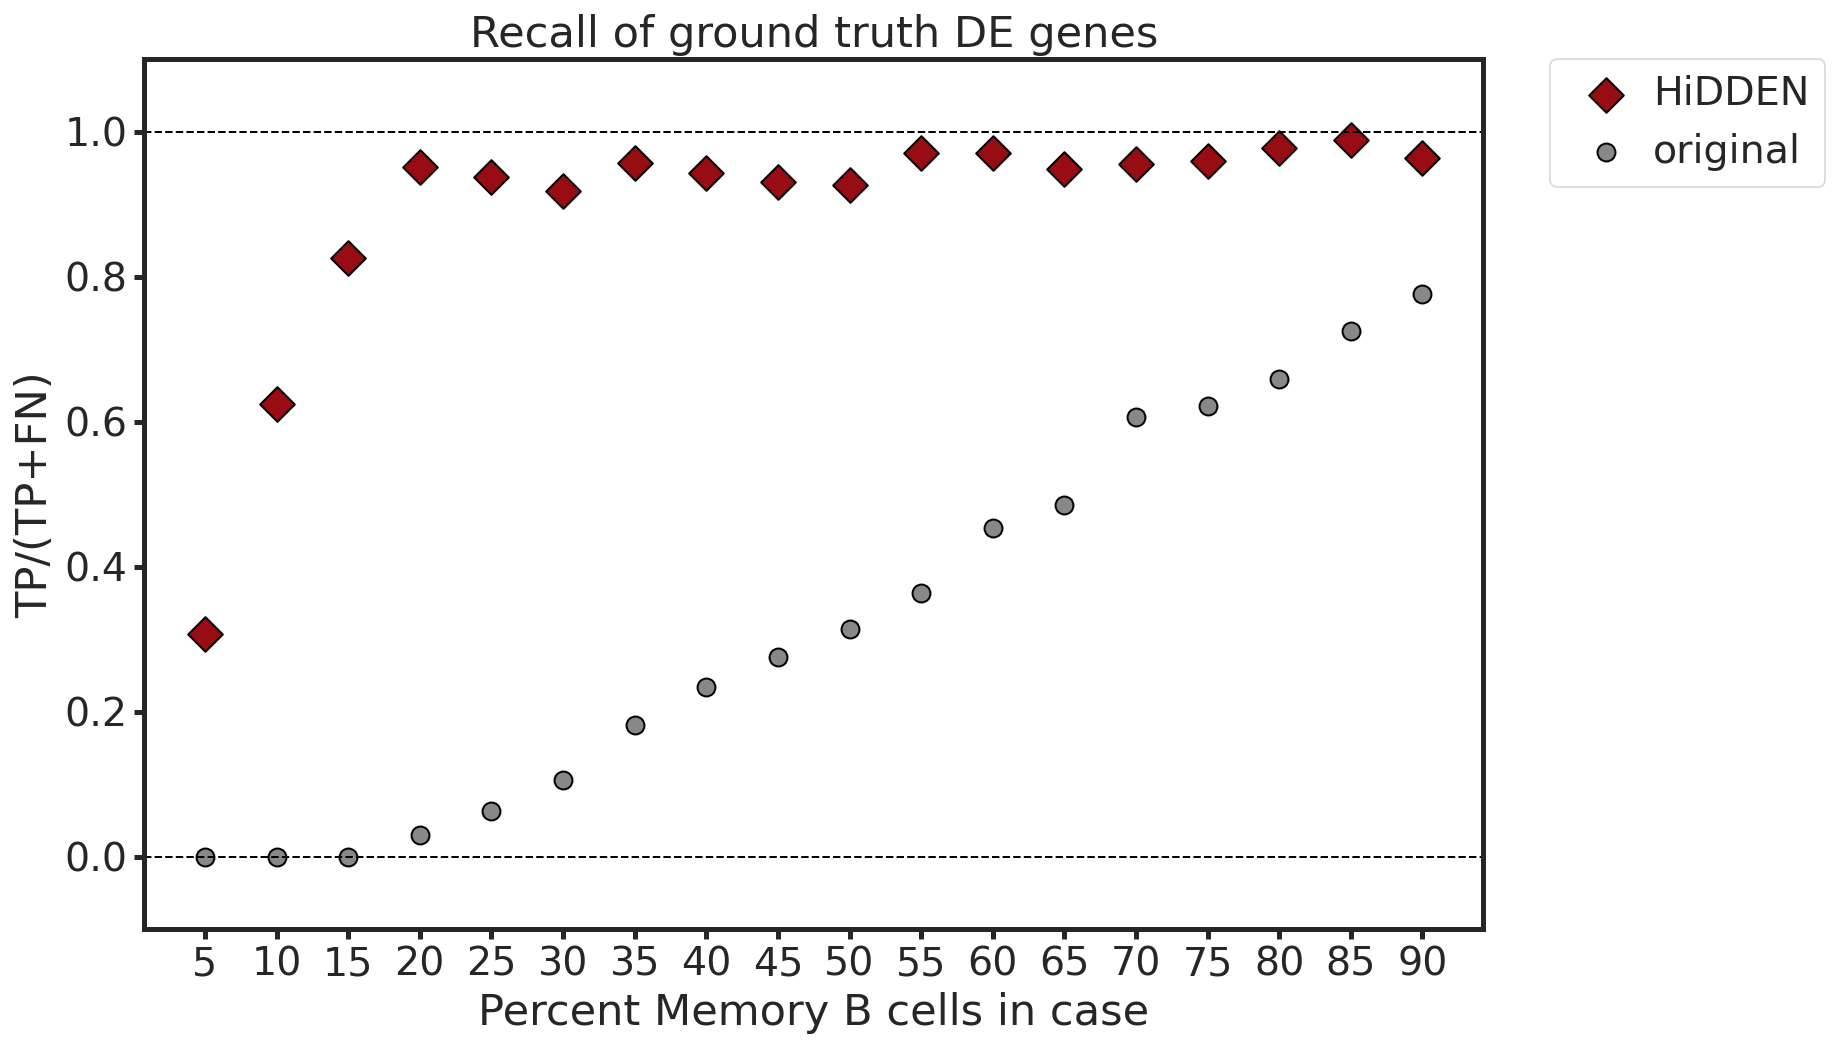

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


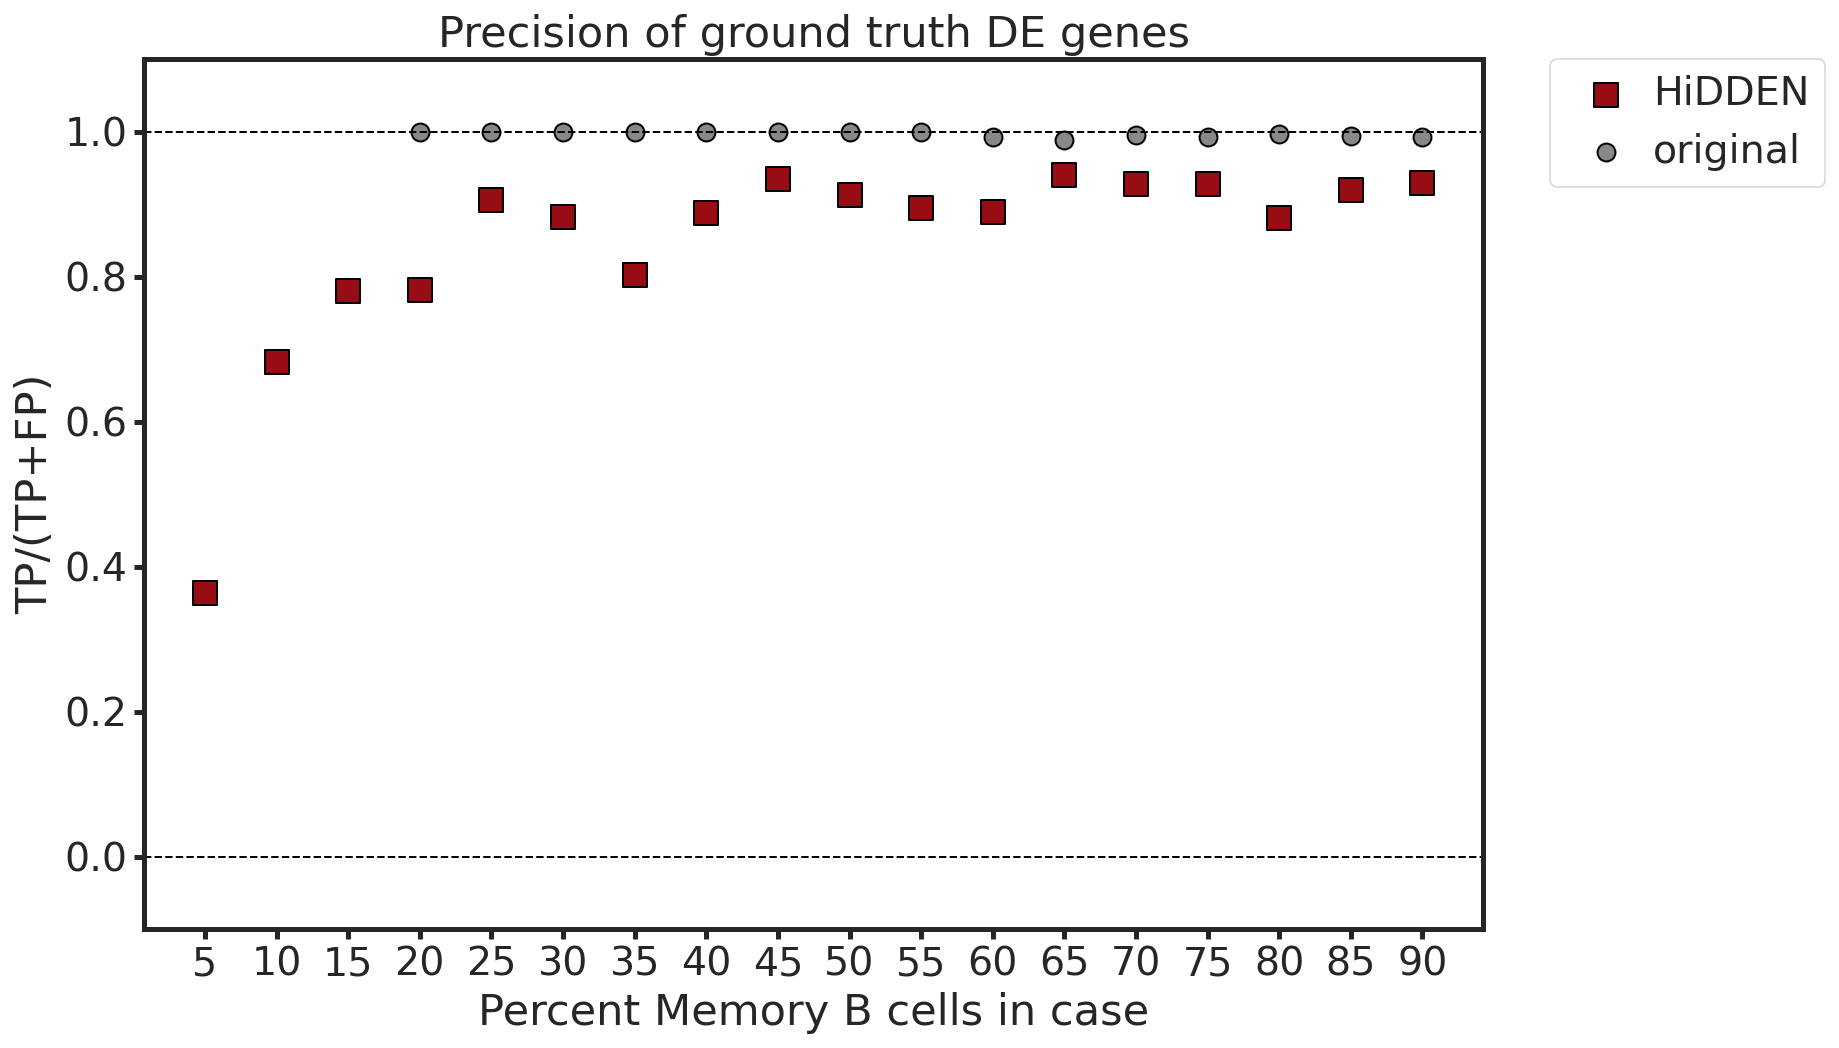

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


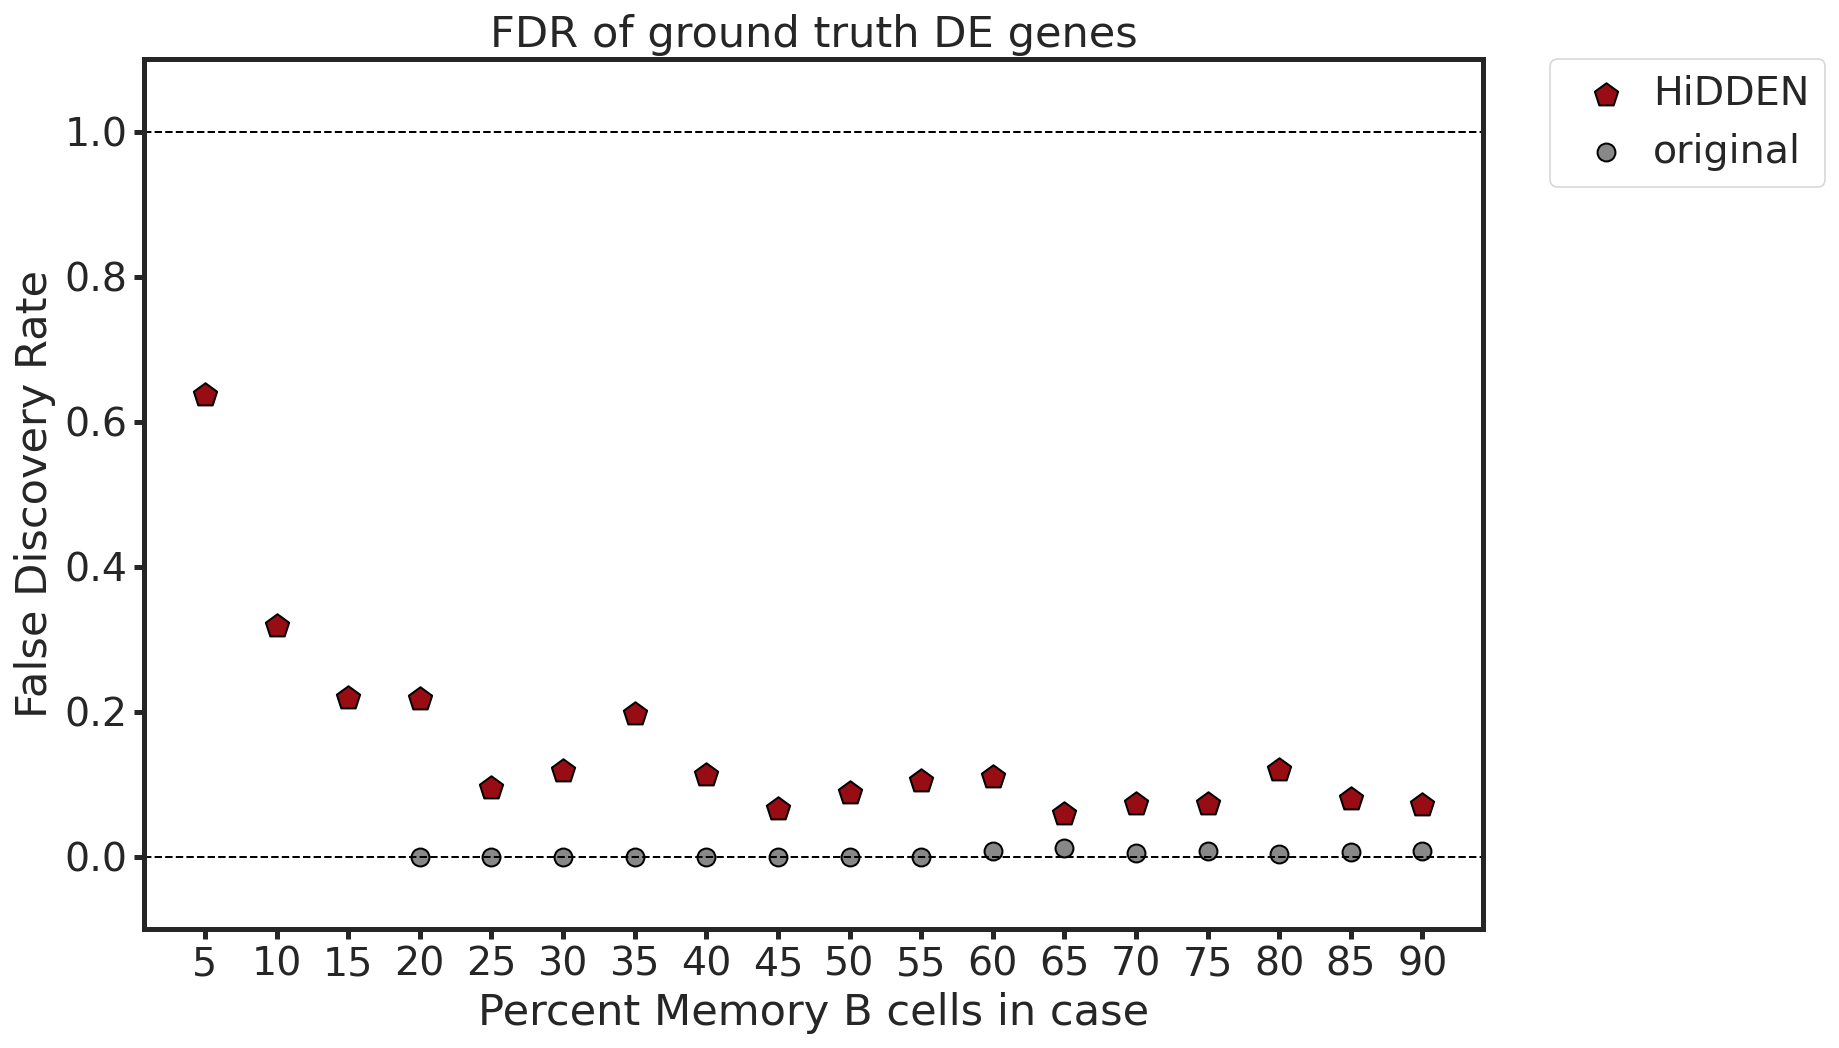

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


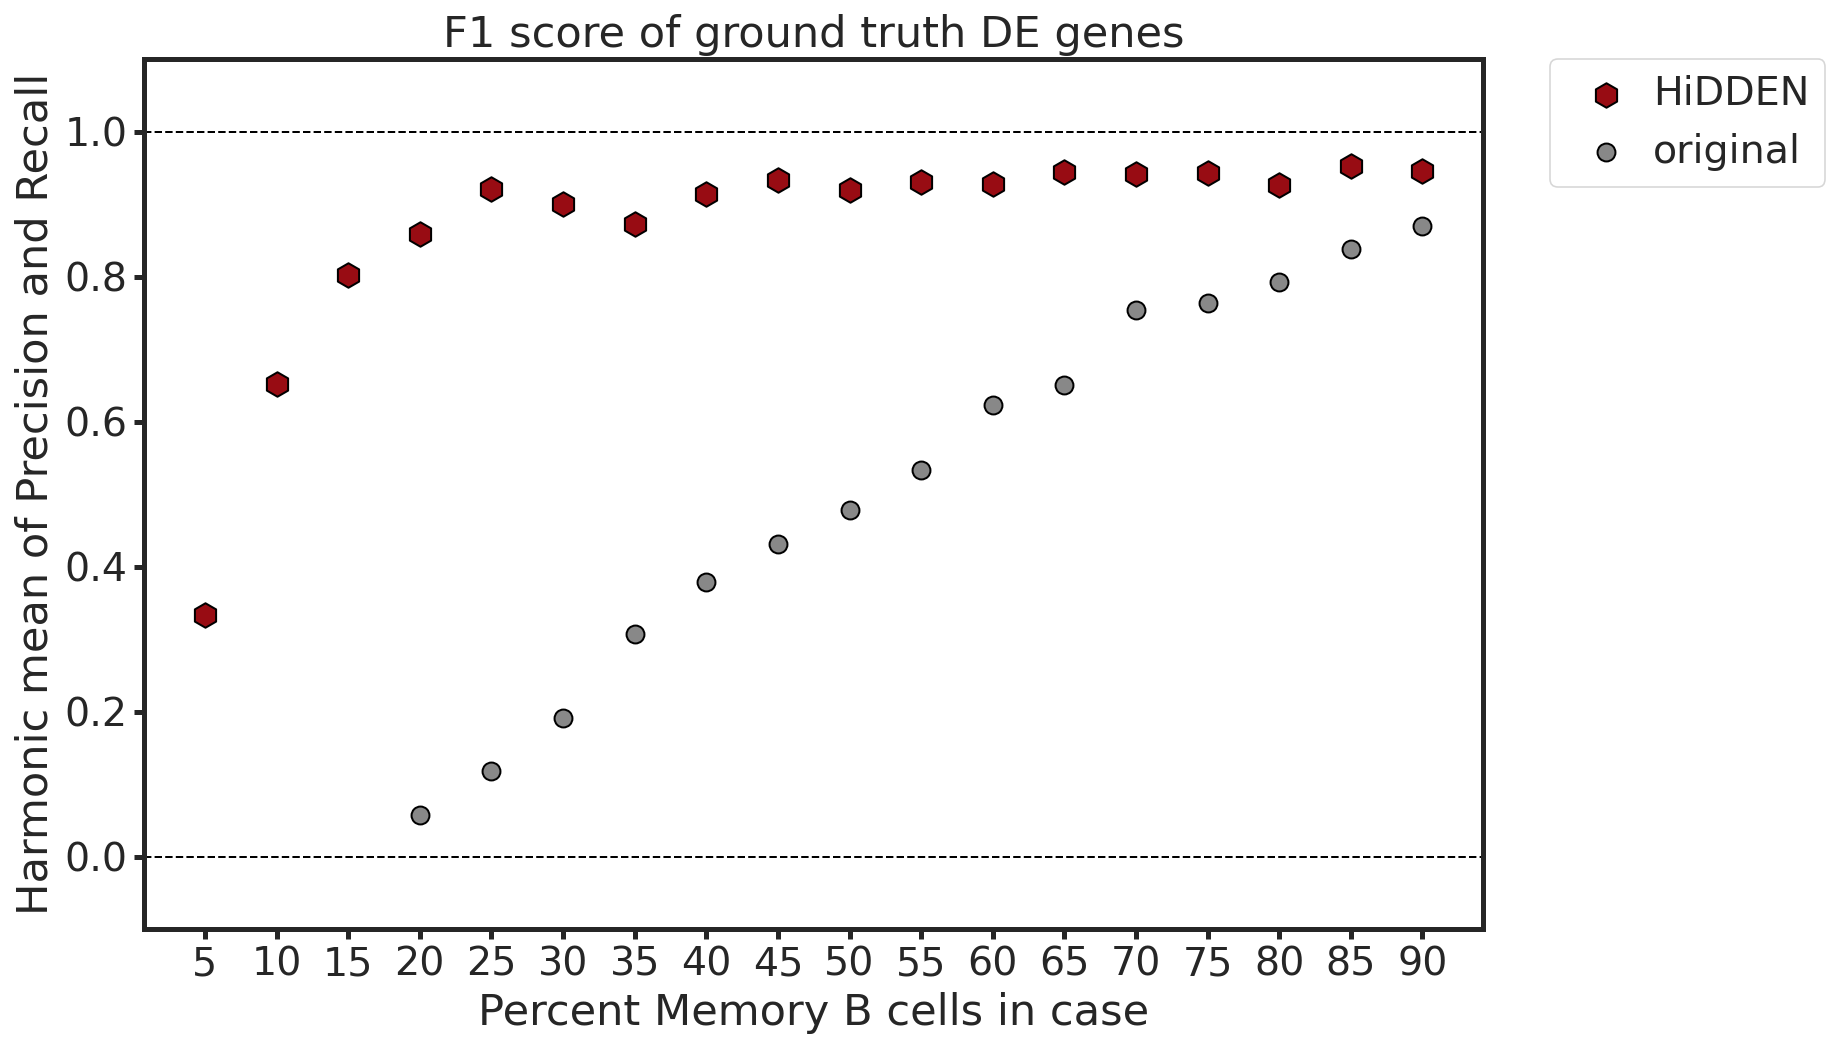

In [206]:
precision_vec_orig = []
recall_vec_orig = []
fdr_vec_orig = []
f1_vec_orig = []
precision_vec_new = []
recall_vec_new = []
fdr_vec_new = []
f1_vec_new = []

for NUM_MEMB in tqdm(['49', '100', '154', '211', '271', '335', '403', '475', '552', '633', '721', '814', '915', '1023', '1140', '1267', '1404', '1555']):
    
    fname = f'figures/naiveB_1900_memoryB_{NUM_MEMB}/DE_results.npz' 
    precision_orig, recall_orig, fdr_orig, f1_score_orig, precision_new, recall_new, fdr_new, f1_score_new = compute_DE_precision_recall_fdr_f1(fname)
    precision_vec_orig, recall_vec_orig, fdr_vec_orig, f1_vec_orig, precision_vec_new, recall_vec_new, fdr_vec_new, f1_vec_new = get_plotting_vecs_precision_recall_fdr_f1(precision_orig, recall_orig, fdr_orig, f1_score_orig, precision_new, recall_new, fdr_new, f1_score_new)

plt.scatter(pct_memory_b_cells, recall_vec_new, c=reds_palette(0.9), s=150, marker='D', alpha=1, edgecolors='k', linewidths=1)
plt.scatter(pct_memory_b_cells, recall_vec_orig, c=greys_palette(0.55), s=80, alpha=1, edgecolors='k', linewidths=1)
plt.xlabel('Percent Memory B cells in case')
plt.ylabel('TP/(TP+FN)')
plt.ylim([-0.1, 1.1]) 
plt.title('Recall of ground truth DE genes')
plt.legend(['HiDDEN', 'original'], bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0, title='', handletextpad=0.2)
plt.axhline(y = 0.0, color = 'k', linestyle = '--', linewidth=1)
plt.axhline(y = 1.0, color = 'k', linestyle = '--', linewidth=1)
plt.savefig(f'figures/across_datasets/Recall_DEgenes_HiDDEN_original.png', dpi=300, transparent=True, bbox_inches='tight')
plt.savefig(f'figures/across_datasets/Recall_DEgenes_HiDDEN_original.svg', transparent=True, bbox_inches='tight')
plt.savefig(f'figures/across_datasets/Recall_DEgenes_HiDDEN_original.pdf', transparent=True, bbox_inches='tight')
plt.show()

plt.scatter(pct_memory_b_cells, precision_vec_new, c=reds_palette(0.9), s=150, marker='s', alpha=1, edgecolors='k', linewidths=1)
plt.scatter(pct_memory_b_cells, precision_vec_orig, c=greys_palette(0.55), s=80, alpha=1, edgecolors='k', linewidths=1)
plt.xlabel('Percent Memory B cells in case')
plt.ylabel('TP/(TP+FP)')
plt.ylim([-0.1, 1.1]) 
plt.title('Precision of ground truth DE genes')
plt.legend(['HiDDEN', 'original'], bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0, title='', handletextpad=0.2)
plt.axhline(y = 0.0, color = 'k', linestyle = '--', linewidth=1)
plt.axhline(y = 1.0, color = 'k', linestyle = '--', linewidth=1)
plt.savefig(f'figures/across_datasets/Precision_DEgenes_HiDDEN_original.png', dpi=300, transparent=True, bbox_inches='tight')
plt.savefig(f'figures/across_datasets/Precision_DEgenes_HiDDEN_original.svg', transparent=True, bbox_inches='tight')
plt.savefig(f'figures/across_datasets/Precision_DEgenes_HiDDEN_original.pdf', transparent=True, bbox_inches='tight')
plt.show()

plt.scatter(pct_memory_b_cells, fdr_vec_new, c=reds_palette(0.9), s=150, marker='p', alpha=1, edgecolors='k', linewidths=1)
plt.scatter(pct_memory_b_cells, fdr_vec_orig, c=greys_palette(0.55), s=80, alpha=1, edgecolors='k', linewidths=1)
plt.xlabel('Percent Memory B cells in case')
plt.ylabel('False Discovery Rate')
plt.ylim([-0.1, 1.1]) 
plt.title('FDR of ground truth DE genes')
plt.legend(['HiDDEN', 'original'], bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0, title='', handletextpad=0.2)
plt.axhline(y = 0.0, color = 'k', linestyle = '--', linewidth=1)
plt.axhline(y = 1.0, color = 'k', linestyle = '--', linewidth=1)
plt.savefig(f'figures/across_datasets/FDR_DEgenes_HiDDEN_original.png', dpi=300, transparent=True, bbox_inches='tight')
plt.savefig(f'figures/across_datasets/FDR_DEgenes_HiDDEN_original.svg', transparent=True, bbox_inches='tight')
plt.savefig(f'figures/across_datasets/FDR_DEgenes_HiDDEN_original.pdf', transparent=True, bbox_inches='tight')
plt.show()

plt.scatter(pct_memory_b_cells, f1_vec_new, c=reds_palette(0.9), s=150, marker='h', alpha=1, edgecolors='k', linewidths=1)
plt.scatter(pct_memory_b_cells, f1_vec_orig, c=greys_palette(0.55), s=80, alpha=1, edgecolors='k', linewidths=1)
plt.xlabel('Percent Memory B cells in case')
plt.ylabel('Harmonic mean of Precision and Recall')
plt.ylim([-0.1, 1.1]) 
plt.title('F1 score of ground truth DE genes')
plt.legend(['HiDDEN', 'original'], bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0, title='', handletextpad=0.2)
plt.axhline(y = 0.0, color = 'k', linestyle = '--', linewidth=1)
plt.axhline(y = 1.0, color = 'k', linestyle = '--', linewidth=1)
plt.savefig(f'figures/across_datasets/F1_DEgenes_HiDDEN_original.png', dpi=300, transparent=True, bbox_inches='tight')
plt.savefig(f'figures/across_datasets/F1_DEgenes_HiDDEN_original.svg', transparent=True, bbox_inches='tight')
plt.savefig(f'figures/across_datasets/F1_DEgenes_HiDDEN_original.pdf', transparent=True, bbox_inches='tight')
plt.show()